# Melanoma Detection with the ResNeSt Model

This code was used in the Hoffman2 Linux Compute Cluster, making use of UCLA's high performance cloud computing resources like the Tesla P4 - GPU (6.1 Compute Capability, 2560 CUDA Cores, 8GB) with additional 32GB RAM.

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
import pickle

## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.017589052123163616


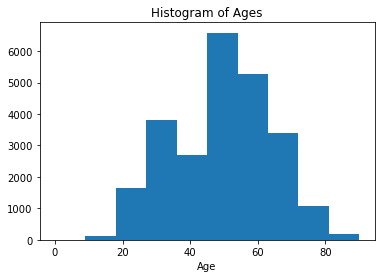

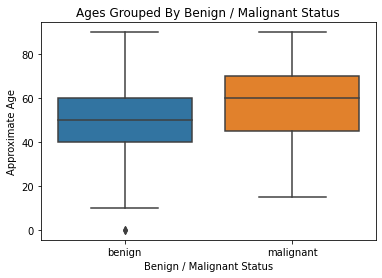

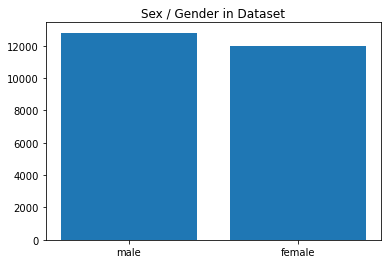

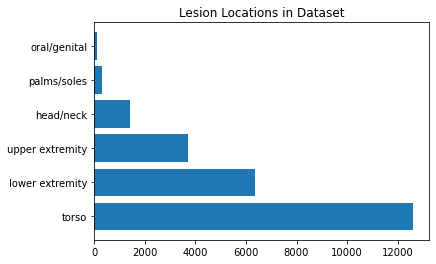

In [2]:
mel_df = pd.read_csv(os.path.join('train_data', 'train.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             11824        170
male               12535        267
Chi-Squared test of independence (P-value): 7.87631386486258e-05 



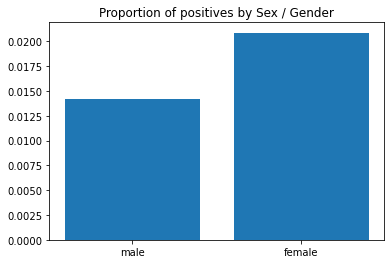



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               629             3363            33   
male                                 767             2966            57   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 111   5683             2001  
male                                   169   6926             1698  
Chi-Squared test of independence (P-value): 3.917186815096256e-37 



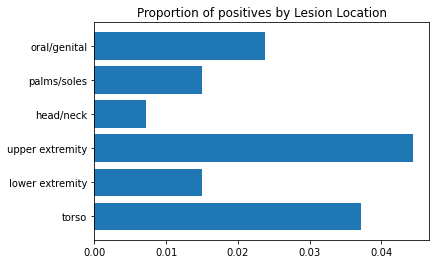

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## ResNeSt (Feature Extraction)

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    n_workers = os.cpu_count()
else:
    n_workers = torch.cuda.device_count()

# If on a CUDA machine, this should print a CUDA device:
print("Device:", device)
print("Number of devices:", n_workers)


Device: cuda:0
Number of devices: 2


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=True,     # sample with replacement
                                         n_samples=num_samples//2)
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2)
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df)
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
        
        image_list.append(torch.unsqueeze(_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out


In [7]:
testing = False

# set our batch size
batch_size = 4

tr_transf = transforms.Compose(
    [transforms.Resize(416),
     transforms.RandomHorizontalFlip(p=0.3),
     transforms.RandomVerticalFlip(p=0.3),
     transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5, 7), sigma=(0.1, 2))]), p=0.2),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     transforms.RandomErasing(scale=(0.02, 0.05), p=0.2)
    ])

val_transf = transforms.Compose(
    [transforms.Resize(416),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
    ])

train_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "train.csv"), 
                            num_samples=10*2*24408, up_sample=True, start_ind=0, transform=tr_transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  collate_fn=pad_collate2d, 
                          num_workers=n_workers)


val_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "val.csv"), 
                            num_samples=2*100, up_sample=True, start_ind=0, transform=val_transf)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=pad_collate2d, 
                        num_workers=n_workers)



# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

In [8]:
# functions to show the image
def imshow(img):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

if testing:
    # get some random training images
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    print("Size:", images.shape)


    # show images
    imshow(images[0,])

    # print labels
    print("Label:", label_id[labels[0,]])

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

In [9]:
load_weights = True
create_new_weights = False
PATH = './melanoma_ResNeSt.pth'

# get list of models
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)

if load_weights:
    print('Loading the pre-trained ResNeSt weights.')
    
    # network weights load
    net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest269', pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 1024),
               nn.BatchNorm1d(1024),
               nn.ReLU(),
               nn.Dropout(p=0.4),
               nn.Linear(1024, 256),
               nn.BatchNorm1d(256),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(256, 1),
               nn.Sigmoid()).to(device)

    checkpoint = torch.load(PATH, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    # optimizer state load
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=12204, gamma=0.5)
    lr_sched.load_state_dict(checkpoint['lr_sched'])
    
    # total mini_batch state load
    mini_batch = checkpoint['mini_batch']
    
    print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
    
elif create_new_weights:
    print('Creating new ResNeSt FC Layer weights.')
    
    net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest269', pretrained=True).to(device)
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 1024),
               nn.BatchNorm1d(1024),
               nn.ReLU(),
               nn.Dropout(p=0.4),
               nn.Linear(1024, 256),
               nn.BatchNorm1d(256),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(256, 1),
               nn.Sigmoid()).to(device)
    
    
    mini_batch = 0
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.fc.parameters(), weight_decay=0)
    lr_sched = optim.lr_scheduler.StepLR(optimizer, step_size=12204, gamma=0.5)
    
    

Downloading: "https://github.com/zhanghang1989/ResNeSt/zipball/master" to /u/home/a/andrewma/.cache/torch/hub/master.zip


Loading the pre-trained ResNeSt weights.


Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


CUDA Memory Allocated: 938062336


In [10]:
learn_weights = True

print("Pre-Training CUDA Memory Allocation:", torch.cuda.max_memory_allocated())

if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)

        loss = criterion(outputs, labels.unsqueeze(-1).float())
        loss.backward()
        optimizer.step()
        lr_sched.step()


        # print statistics
        running_loss += loss.item()
        
        # update mini-batch count
        mini_batch += 1
        epoch = mini_batch // 12204

        # print every mini-batch
        print("CUDA Memory Allocated:", torch.cuda.max_memory_allocated())
        print(f'[Epoch {epoch}, Batch {mini_batch % 12204}] Loss: {running_loss / (i+1)}\n')

        # save and outoput every 100 mini-batch
        if i % 500 == 0:
            print("*********** Saving network weights and optimizer state *********** \n\n")
            # save the weights and optimizer
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, PATH)
            
        # eval every 500 mini-batch
        if i % 500 == 0:
            
            print("******************************************************************")
            print("*********************** Performance Update ***********************")
            print("******************************************************************\n")
            
            net.eval()
            
            ground_truths = []
            probs = []

            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.no_grad():
                for j, valdata in enumerate(val_loader, 0):
                    image, label = valdata
                    image = image.to(device)

                    # save for analysis
                    ground_truths.append(label)

                    # calculate outputs by running images through the network 
                    outputs = net(image)
                    outputs = outputs.to("cpu")

                    # # save for analysis
                    probs.append(outputs)

            print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs))
            
            net.train()

            print("\n******************************************************************")
            print("****************** Performance Update Complete! ******************")
            print("******************************************************************\n\n")

        # save unique set of weights and optimizer for validation later
        if mini_batch % 12204 == 0:

            uPATH = f'./saved_weights4/melanoma_ResNeSt_{epoch}e_{mini_batch % 12204}b.pth'
            torch.save({'mini_batch': mini_batch,
                        'model_state_dict': net.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict(),
                        'lr_sched': lr_sched.state_dict()}, uPATH)

    print('*********** Finished Training this Epoch in', time.time() - start_time, 'seconds ***********')
    
    # save the weights and optimizer
    torch.save({'mini_batch': mini_batch,
                'model_state_dict': net.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict(), 
                'lr_sched': lr_sched.state_dict()}, PATH)
    


Pre-Training CUDA Memory Allocation: 938062336
CUDA Memory Allocated: 7373635072
[Epoch 16, Batch 4573] Loss: 0.4986456632614136

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8602

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4574] Loss: 0.6654359698295593

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4575] Loss: 0.49654029806454975

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4576] Loss: 0.5634768232703209

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4577] Loss: 0.49121904373168945

CUDA Memory Allocated: 7808

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4665] Loss: 0.4923323470578399

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4666] Loss: 0.4907088819494907

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4667] Loss: 0.49157133549451826

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4668] Loss: 0.49801462834390503

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4669] Loss: 0.49673282800568747

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4670] Loss: 0.4955792519054851

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4671] Loss: 0.4938675737892739

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4672] Loss: 0.4997231585532427

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4673] Loss: 0.49873913640137946

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4674] Loss: 0.5001787292752781

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4675] Loss: 0.4981605017792831

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4676] Loss: 0.4946047766134143



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4764] Loss: 0.46731198493701714

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4765] Loss: 0.46796781017681477

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4766] Loss: 0.4676621957998915

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4767] Loss: 0.46725672231270715

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4768] Loss: 0.4669360902388485

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4769] Loss: 0.46787836141695227

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4770] Loss: 0.4682036181441461

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4771] Loss: 0.4673220830496831

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4772] Loss: 0.4664263122528791

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4773] Loss: 0.46552137111253405

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4774] Loss: 0.46732199892844306

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4775] Loss: 0.4657078790547225

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4863] Loss: 0.4577011137023005

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4864] Loss: 0.45914815353510313

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4865] Loss: 0.45973079102336345

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4866] Loss: 0.45894490220412915

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4867] Loss: 0.45852441370992336

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4868] Loss: 0.45845179790882645

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4869] Loss: 0.45786816190288526

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4870] Loss: 0.4571977701513159

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4871] Loss: 0.45641665452200436

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4872] Loss: 0.4557848400622606

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4873] Loss: 0.4561774101714755

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4874] Loss: 0.456448264148653

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4962] Loss: 0.4632618122566969

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4963] Loss: 0.46336679715101065

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4964] Loss: 0.463012438286476

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4965] Loss: 0.4639520677939323

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4966] Loss: 0.4641105264311817

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4967] Loss: 0.463680563112603

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4968] Loss: 0.4643492292462274

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4969] Loss: 0.4641215667804182

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4970] Loss: 0.46323533625758473

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4971] Loss: 0.4628369369004902

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4972] Loss: 0.4629109413176775

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 4973] Loss: 0.4638768054749306

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5061] Loss: 0.46695326498741996

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5062] Loss: 0.46669009226013203

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5063] Loss: 0.4661017381216261

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5064] Loss: 0.46613145957329893

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5065] Loss: 0.4660742617614613

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5066] Loss: 0.46596064902691225

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5067] Loss: 0.4652172784010569

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5068] Loss: 0.46524864333050864

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5069] Loss: 0.4658066427084042

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5070] Loss: 0.465052208986627

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5071] Loss: 0.46516676632340304

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5072] Loss: 0.46504387533664704

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5153] Loss: 0.4608191213411842

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5154] Loss: 0.4613915661996378

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5155] Loss: 0.46096161959970794

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5156] Loss: 0.4603534053169089

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5157] Loss: 0.4599964351353482

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5158] Loss: 0.4594068707764759

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5159] Loss: 0.4589472765918485

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5160] Loss: 0.4586499120001079

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5161] Loss: 0.458425882564943

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5162] Loss: 0.45821568081944675

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5163] Loss: 0.4584303145783807

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5164] Loss: 0.459146638123973

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5252] Loss: 0.45927866909872084

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5253] Loss: 0.4591935332782468

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5254] Loss: 0.4588458635502896

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5255] Loss: 0.4586219312854951

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5256] Loss: 0.4583996570075465

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5257] Loss: 0.4585739254951477

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5258] Loss: 0.45854906490175784

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5259] Loss: 0.4585422503028548

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5260] Loss: 0.45846865018613114

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5261] Loss: 0.458286706396042

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5262] Loss: 0.45790107764195703

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5263] Loss: 0.45874201419039506



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5351] Loss: 0.4622025399902819

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5352] Loss: 0.4628353891846461

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5353] Loss: 0.46322468983989673

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5354] Loss: 0.463292203786428

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5355] Loss: 0.4632963039942019

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5356] Loss: 0.46312861775561254

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5357] Loss: 0.46292329236959956

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5358] Loss: 0.4626588170385846

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5359] Loss: 0.46263779959199997

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5360] Loss: 0.4631787855461769

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5361] Loss: 0.4642416440488721

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5362] Loss: 0.4647420405587064

C

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5450] Loss: 0.4615335059277968

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5451] Loss: 0.46126177365360815

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5452] Loss: 0.4610074711540206

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5453] Loss: 0.46103801089471097

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5454] Loss: 0.4612297168478809

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5455] Loss: 0.46146422510677665

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5456] Loss: 0.46194428401868537

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5457] Loss: 0.46248304999649187

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5458] Loss: 0.46261060548185223

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5459] Loss: 0.4625042611155596

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5460] Loss: 0.46223808369423086

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5461] Loss: 0.462382329068449

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5549] Loss: 0.4613155006157461

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5550] Loss: 0.46151179005915643

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5551] Loss: 0.4614492901757862

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5552] Loss: 0.46120516625137964

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5553] Loss: 0.46090958270488286

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5554] Loss: 0.4608563700740182

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5555] Loss: 0.4612693946168115

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5556] Loss: 0.46123634782294193

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5557] Loss: 0.46096091764378666

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5558] Loss: 0.4610241447588614

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5559] Loss: 0.4608756927386485

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5560] Loss: 0.4613695923269157


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5642] Loss: 0.45847884525901805

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5643] Loss: 0.45845101032854796

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5644] Loss: 0.458831405746681

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5645] Loss: 0.4588835123381321

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5646] Loss: 0.4590224905123369

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5647] Loss: 0.45877774756315143

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5648] Loss: 0.4587640336551963

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5649] Loss: 0.4587889531404195

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5650] Loss: 0.45867639433779167

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5651] Loss: 0.4587192854346005

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5652] Loss: 0.4589931217815589

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5653] Loss: 0.45888957410885384



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5741] Loss: 0.46175226122395824

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5742] Loss: 0.4616281468580421

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5743] Loss: 0.46200291179343234

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5744] Loss: 0.46194661235112583

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5745] Loss: 0.46181617004563436

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5746] Loss: 0.4620918323058997

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5747] Loss: 0.46188765772479645

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5748] Loss: 0.46171865554615144

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5749] Loss: 0.46148127469985084

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5750] Loss: 0.4612847342391472

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5751] Loss: 0.46128028585078656

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5752] Loss: 0.46149169549472

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5840] Loss: 0.4615796083931103

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5841] Loss: 0.46135357247740383

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5842] Loss: 0.4610996598333824

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5843] Loss: 0.46102579471447824

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5844] Loss: 0.4608601835913628

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5845] Loss: 0.4605638087381084

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5846] Loss: 0.4607389878417297

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5847] Loss: 0.46068631703947105

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5848] Loss: 0.46106502235075897

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5849] Loss: 0.4608881186720162

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5850] Loss: 0.46116173330327154

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5851] Loss: 0.4611614167783482


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5939] Loss: 0.46270958454114464

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5940] Loss: 0.4633267629858956

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5941] Loss: 0.4632117385092315

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5942] Loss: 0.46348723346625803

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5943] Loss: 0.4637086175757112

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5944] Loss: 0.4635241144437223

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5945] Loss: 0.46340846360402654

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5946] Loss: 0.46353526537617046

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5947] Loss: 0.4635235528133132

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5948] Loss: 0.46344485879485864

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5949] Loss: 0.4634191051947958

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 5950] Loss: 0.46317513447649594

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6038] Loss: 0.46405183007028383

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6039] Loss: 0.4642303249434947

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6040] Loss: 0.4644517108280344

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6041] Loss: 0.4642326975300898

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6042] Loss: 0.46449767130674147

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6043] Loss: 0.4645219060543603

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6044] Loss: 0.4643858272997338

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6045] Loss: 0.46455451284167887

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6046] Loss: 0.4644695233952967

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6047] Loss: 0.4648388772748284

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6048] Loss: 0.4650747399918513

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6049] Loss: 0.4652687999884583

C

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6130] Loss: 0.4658820405363348

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6131] Loss: 0.4659511381622841

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6132] Loss: 0.46578476674950275

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6133] Loss: 0.4655681056358889

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6134] Loss: 0.4659054829344325

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6135] Loss: 0.46575670477696435

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6136] Loss: 0.46587040090976317

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6137] Loss: 0.4658520987667977

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6138] Loss: 0.4659039046315626

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6139] Loss: 0.4657998637372929

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6140] Loss: 0.46567203276030417

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6141] Loss: 0.4659684817879499



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6229] Loss: 0.46618133535137646

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6230] Loss: 0.4660480479531179

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6231] Loss: 0.46589220824947264

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6232] Loss: 0.46569020310977854

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6233] Loss: 0.4655972857797526

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6234] Loss: 0.4654715818887583

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6235] Loss: 0.46537118238888087

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6236] Loss: 0.46526347594156575

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6237] Loss: 0.46548595857154856

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6238] Loss: 0.46553777867541307

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6239] Loss: 0.46538631575116157

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6240] Loss: 0.46520617416651

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6328] Loss: 0.46296207227050445

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6329] Loss: 0.46281981497460223

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6330] Loss: 0.46273584240481713

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6331] Loss: 0.46261553409985345

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6332] Loss: 0.46270238129337404

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6333] Loss: 0.46301267360385207

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6334] Loss: 0.4629988872343579

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6335] Loss: 0.462977263956028

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6336] Loss: 0.4628303439109301

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6337] Loss: 0.4629986853040649

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6338] Loss: 0.46310082613358683

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6339] Loss: 0.4629729786707509

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6427] Loss: 0.46329012807970743

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6428] Loss: 0.46309136158529796

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6429] Loss: 0.4633479457214178

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6430] Loss: 0.4635364908496453

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6431] Loss: 0.46364926361248915

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6432] Loss: 0.46364530264850584

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6433] Loss: 0.46352738152422746

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6434] Loss: 0.4633986640933633

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6435] Loss: 0.4637731855282269

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6436] Loss: 0.4636476835227959

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6437] Loss: 0.46353789639057486

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6438] Loss: 0.4635577559359332

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6526] Loss: 0.4640923423412329

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6527] Loss: 0.4640229976428744

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6528] Loss: 0.4640623648024349

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6529] Loss: 0.4642387112040086

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6530] Loss: 0.46439605108457516

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6531] Loss: 0.4643592348758696

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6532] Loss: 0.46442489549897764

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6533] Loss: 0.4643716590592048

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6534] Loss: 0.4642081900815898

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6535] Loss: 0.4641792372218274

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6536] Loss: 0.46402190405260885

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6537] Loss: 0.46396298421779053



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6619] Loss: 0.4648306216402175

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6620] Loss: 0.46468423264013836

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6621] Loss: 0.46477936160250255

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6622] Loss: 0.4648533141394941

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6623] Loss: 0.46484530617962927

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6624] Loss: 0.4650925122288584

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6625] Loss: 0.46497703921022615

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6626] Loss: 0.4651346746850269

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6627] Loss: 0.46504612855087524

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6628] Loss: 0.4649861319142789

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6629] Loss: 0.46496345419355195

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6630] Loss: 0.4650035927287575

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6718] Loss: 0.4659073739507881

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6719] Loss: 0.465893867109396

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6720] Loss: 0.46573126616105576

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6721] Loss: 0.465896136628827

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6722] Loss: 0.4661346268688524

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6723] Loss: 0.466196479439486

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6724] Loss: 0.4663739268699155

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6725] Loss: 0.4662763506859278

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6726] Loss: 0.46616451347120513

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6727] Loss: 0.4663156315269437

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6728] Loss: 0.4663470267233523

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6729] Loss: 0.46624586409960406

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6817] Loss: 0.4661075604353556

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6818] Loss: 0.4660832913342004

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6819] Loss: 0.4659566145123351

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6820] Loss: 0.46593497320678207

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6821] Loss: 0.46599196712869495

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6822] Loss: 0.46591571620768973

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6823] Loss: 0.46598726432557

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6824] Loss: 0.4660614344455156

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6825] Loss: 0.46595166406986505

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6826] Loss: 0.46592946136048013

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6827] Loss: 0.46585073458844434

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6828] Loss: 0.4657765654087437



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6916] Loss: 0.4642445667116003

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6917] Loss: 0.46427438020833267

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6918] Loss: 0.46416391490721237

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6919] Loss: 0.4641723839409767

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6920] Loss: 0.4641959377432804

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6921] Loss: 0.4641737946935185

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6922] Loss: 0.4640865544562644

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6923] Loss: 0.4640283300135299

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6924] Loss: 0.4644123510945411

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6925] Loss: 0.4646613061352076

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6926] Loss: 0.46451487334899305

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 6927] Loss: 0.46445591017255866



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7015] Loss: 0.4653658901131207

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7016] Loss: 0.4653050309647661

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7017] Loss: 0.4651779919100929

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7018] Loss: 0.46502752687693716

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7019] Loss: 0.46511616433609443

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7020] Loss: 0.46510725203305

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7021] Loss: 0.4652060134288436

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7022] Loss: 0.4652021752723626

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7023] Loss: 0.4653116098530241

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7024] Loss: 0.465359467608918

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7025] Loss: 0.46557752272631264

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7026] Loss: 0.4654887280690301

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7108] Loss: 0.4662414962948779

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7109] Loss: 0.4660979119057161

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7110] Loss: 0.4661096885941271

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7111] Loss: 0.4660338189844636

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7112] Loss: 0.46612259113765137

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7113] Loss: 0.4661143273818873

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7114] Loss: 0.4660854214446269

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7115] Loss: 0.4660587839861344

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7116] Loss: 0.46594989973957995

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7117] Loss: 0.4658215278492461

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7118] Loss: 0.46589258041610326

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7119] Loss: 0.46581250090995957



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7207] Loss: 0.46667464831296135

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7208] Loss: 0.4666131500929187

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7209] Loss: 0.4667253739168393

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7210] Loss: 0.46665159134452683

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7211] Loss: 0.46679870560115916

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7212] Loss: 0.46680389280346307

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7213] Loss: 0.46673693021830626

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7214] Loss: 0.466672944174311

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7215] Loss: 0.4666743938033436

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7216] Loss: 0.4666275865935161

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7217] Loss: 0.4665683621044195

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7218] Loss: 0.46667239261412385


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7306] Loss: 0.4681390555767614

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7307] Loss: 0.4681902013078904

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7308] Loss: 0.4680925654873731

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7309] Loss: 0.4679858146938347

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7310] Loss: 0.46816871829271056

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7311] Loss: 0.46846497327350445

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7312] Loss: 0.46837223499306363

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7313] Loss: 0.46850854270119424

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7314] Loss: 0.4686806381569345

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7315] Loss: 0.46861726446250385

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7316] Loss: 0.46861081967624474

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7317] Loss: 0.4685440589142844

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7405] Loss: 0.46821268293132134

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7406] Loss: 0.46817178469500914

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7407] Loss: 0.46803973826466416

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7408] Loss: 0.4679807931951895

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7409] Loss: 0.4680542251332192

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7410] Loss: 0.46817318346926323

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7411] Loss: 0.4681442465558359

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7412] Loss: 0.4681559555494869

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7413] Loss: 0.4683042170243211

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7414] Loss: 0.46838749192765194

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7415] Loss: 0.46838021428808124

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7416] Loss: 0.4683380458875966

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7504] Loss: 0.46760136121312235

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7505] Loss: 0.4675980591902016

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7506] Loss: 0.467789815547073

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7507] Loss: 0.46772155830259016

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7508] Loss: 0.46771770686784137

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7509] Loss: 0.46768872620481433

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7510] Loss: 0.46761125406799386

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7511] Loss: 0.4676672870983433

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7512] Loss: 0.4676914755939221

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7513] Loss: 0.46760467737558464

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7514] Loss: 0.46770632285232205

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7515] Loss: 0.4676520984735045

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7596] Loss: 0.46799341926755256

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7597] Loss: 0.4680338198537669

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7598] Loss: 0.4680656957620434

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7599] Loss: 0.46797719041053554

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7600] Loss: 0.46814426562725475

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7601] Loss: 0.4680251099830927

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7602] Loss: 0.4681645170960686

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7603] Loss: 0.4680681255701665

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7604] Loss: 0.46796667967778005

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7605] Loss: 0.4680871184371188

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7606] Loss: 0.4679838045964959

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7607] Loss: 0.46796074707730007


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7695] Loss: 0.4688563820498325

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7696] Loss: 0.4689569471668686

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7697] Loss: 0.4689842476773262

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7698] Loss: 0.4690694587134773

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7699] Loss: 0.46900512464642335

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7700] Loss: 0.4691162690296388

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7701] Loss: 0.4690954683234837

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7702] Loss: 0.4692036262073646

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7703] Loss: 0.46912803567520006

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7704] Loss: 0.4692509128316038

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7705] Loss: 0.4691594369445523

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7706] Loss: 0.4691505375714651

CU

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7794] Loss: 0.4691023431732224

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7795] Loss: 0.46901539280626886

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7796] Loss: 0.46901243029361034

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7797] Loss: 0.46896048836929854

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7798] Loss: 0.4688591531628566

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7799] Loss: 0.46882044750450197

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7800] Loss: 0.4689087353166668

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7801] Loss: 0.4688749008455229

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7802] Loss: 0.4689499595263056

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7803] Loss: 0.468865638826514

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7804] Loss: 0.4688896473432605

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7805] Loss: 0.46884670207882456



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7893] Loss: 0.46939020425987615

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7894] Loss: 0.46935337139119737

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7895] Loss: 0.4692719982101226

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7896] Loss: 0.469340487216318

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7897] Loss: 0.4694373716940557

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7898] Loss: 0.46939157195483355

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7899] Loss: 0.4693439987630575

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7900] Loss: 0.469382729251475

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7901] Loss: 0.4695614253473769

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7902] Loss: 0.46945046856551914

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7903] Loss: 0.46934127145542176

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7904] Loss: 0.46924275527892706



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7992] Loss: 0.46946418676198576

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7993] Loss: 0.4693613136696279

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7994] Loss: 0.4693036978005109

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7995] Loss: 0.46929356930306737

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7996] Loss: 0.4692447204316888

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7997] Loss: 0.4692399382939304

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7998] Loss: 0.46928590760548355

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 7999] Loss: 0.4692182872223722

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8000] Loss: 0.46936028670680424

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8001] Loss: 0.46929105973758234

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8002] Loss: 0.4692867106668456

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8003] Loss: 0.4693959454724338


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8084] Loss: 0.4699991745259061

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8085] Loss: 0.46998184385748965

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8086] Loss: 0.46994282083885874

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8087] Loss: 0.4699547268418465

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8088] Loss: 0.4698507222002616

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8089] Loss: 0.4699119347798272

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8090] Loss: 0.46983766963259616

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8091] Loss: 0.4700584851753715

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8092] Loss: 0.4699872623240067

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8093] Loss: 0.46992756017515247

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8094] Loss: 0.47004187798835145

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8095] Loss: 0.4699357125274742


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8183] Loss: 0.4701734572933738

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8184] Loss: 0.4702611630421507

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8185] Loss: 0.4703367033242816

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8186] Loss: 0.4704029374855391

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8187] Loss: 0.47049700938278544

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8188] Loss: 0.47059121277735494

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8189] Loss: 0.4705476542826117

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8190] Loss: 0.4706642466245632

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8191] Loss: 0.47084947289658635

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8192] Loss: 0.4708029186836758

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8193] Loss: 0.47069581072120104

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8194] Loss: 0.47061495683482507


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8282] Loss: 0.47044927859001084

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8283] Loss: 0.4703867028012362

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8284] Loss: 0.4704847355766607

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8285] Loss: 0.47043127696805653

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8286] Loss: 0.4703793418691501

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8287] Loss: 0.4702735554040842

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8288] Loss: 0.470197656627973

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8289] Loss: 0.4702114450144197

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8290] Loss: 0.47025258770596284

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8291] Loss: 0.47030570815009565

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8292] Loss: 0.470307361274477

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8293] Loss: 0.47029915146451584

C

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8381] Loss: 0.4695142530282359

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8382] Loss: 0.4694895378991062

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8383] Loss: 0.4694401970633182

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8384] Loss: 0.46935203649564905

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8385] Loss: 0.4693200298331711

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8386] Loss: 0.4694384772098058

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8387] Loss: 0.4693514862348024

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8388] Loss: 0.4694357383801002

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8389] Loss: 0.46960499091769253

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8390] Loss: 0.4695518581872838

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8391] Loss: 0.4695102896996898

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8392] Loss: 0.469570557507857

CUD

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8480] Loss: 0.4689808583159682

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8481] Loss: 0.468958593043457

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8482] Loss: 0.4688742541538937

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8483] Loss: 0.4688573610509061

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8484] Loss: 0.4688037130734093

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8485] Loss: 0.46873190929152125

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8486] Loss: 0.46872330245865995

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8487] Loss: 0.4688202234006476

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8488] Loss: 0.4687445883118796

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8489] Loss: 0.4687174168687132

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8490] Loss: 0.468855092745995

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8491] Loss: 0.46875954748462373

CUD

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8574] Loss: 0.46934186301377046

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8575] Loss: 0.46935246193741015

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8576] Loss: 0.46932224043785453

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8577] Loss: 0.4692398436525639

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8578] Loss: 0.46915968023407956

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8579] Loss: 0.4690714670140189

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8580] Loss: 0.46922176197996573

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8581] Loss: 0.469253772590472

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8582] Loss: 0.4691650026345491

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8583] Loss: 0.46913602805901455

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8584] Loss: 0.46921210274367725

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8585] Loss: 0.4691738696718287

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8673] Loss: 0.4691922068505048

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8674] Loss: 0.46913245770224765

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8675] Loss: 0.4690691869748589

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8676] Loss: 0.46914737303260184

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8677] Loss: 0.469127012255639

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8678] Loss: 0.46905028893164585

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8679] Loss: 0.468983191444414

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8680] Loss: 0.46896602860320913

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8681] Loss: 0.4689553527881786

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8682] Loss: 0.4690532973122278

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8683] Loss: 0.4689714513126443

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8684] Loss: 0.46897305740797274

C

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8772] Loss: 0.46834234838861794

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8773] Loss: 0.468419421426074

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8774] Loss: 0.4683464487224661

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8775] Loss: 0.46831295569078313

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8776] Loss: 0.46830273842657044

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8777] Loss: 0.4682849437228706

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8778] Loss: 0.4682812296257975

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8779] Loss: 0.4682669448089594

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8780] Loss: 0.46825117721778303

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8781] Loss: 0.4681664707188256

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8782] Loss: 0.4680977671949144

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8783] Loss: 0.4681339911166406

C

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8871] Loss: 0.46821022608732726

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8872] Loss: 0.468183263980372

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8873] Loss: 0.4681400763721029

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8874] Loss: 0.46810138761401454

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8875] Loss: 0.46803789049934125

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8876] Loss: 0.4681724903786548

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8877] Loss: 0.4681580547083269

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8878] Loss: 0.4680937211104066

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8879] Loss: 0.468050291584876

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8880] Loss: 0.4679900165664563

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8881] Loss: 0.4679368469223508

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8882] Loss: 0.46798789732486634

CU

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8970] Loss: 0.4679379433786506

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8971] Loss: 0.4679706364253565

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8972] Loss: 0.4678973061726852

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8973] Loss: 0.46789212723640766

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8974] Loss: 0.46784702570993

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8975] Loss: 0.4678224785244522

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8976] Loss: 0.46791985141727516

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8977] Loss: 0.46785335710587217

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8978] Loss: 0.4679476336097912

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8979] Loss: 0.46792881394666097

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8980] Loss: 0.4678820087532166

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 8981] Loss: 0.4678129549637812

CU

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9069] Loss: 0.4678599826622094

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9070] Loss: 0.4678156585786649

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9071] Loss: 0.46778945023018825

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9072] Loss: 0.46775825452804565

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9073] Loss: 0.467672911704156

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8747

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9074] Loss: 0.4678058396

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9162] Loss: 0.4669946679265151

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9163] Loss: 0.46704356551520887

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9164] Loss: 0.4671391075970248

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9165] Loss: 0.4671140767126179

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9166] Loss: 0.46710679089771334

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9167] Loss: 0.46709076098376184

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9168] Loss: 0.46712434720782947

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9169] Loss: 0.4671364011150198

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9170] Loss: 0.46707511840371163

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9171] Loss: 0.46711766164143154

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9172] Loss: 0.467093316954763

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9173] Loss: 0.46706791705954104

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9261] Loss: 0.46655585154919615

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9262] Loss: 0.46658059573376864

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9263] Loss: 0.46650584070343526

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9264] Loss: 0.46643773571787384

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9265] Loss: 0.46638584747234185

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9266] Loss: 0.46637068417131217

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9267] Loss: 0.46642574454648805

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9268] Loss: 0.4663979884116471

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9269] Loss: 0.4665154420760989

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9270] Loss: 0.466486040329923

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9271] Loss: 0.4664908619758093

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9272] Loss: 0.4665091961749056

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9360] Loss: 0.46523152166197923

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9361] Loss: 0.4651614363422148

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9362] Loss: 0.4652461427191976

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9363] Loss: 0.4652234081126807

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9364] Loss: 0.4652425257103496

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9365] Loss: 0.46519517636942065

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9366] Loss: 0.46529059199259637

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9367] Loss: 0.465264317304735

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9368] Loss: 0.4652682272942614

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9369] Loss: 0.4652420926822805

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9370] Loss: 0.4651825351127365

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9371] Loss: 0.4652373526329968

CU

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9459] Loss: 0.4652045629499318

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9460] Loss: 0.46519958368866854

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9461] Loss: 0.4652437628744984

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9462] Loss: 0.46523577166999286

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9463] Loss: 0.4653036758864226

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9464] Loss: 0.465368988123385

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9465] Loss: 0.4653504361316102

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9466] Loss: 0.4653393620016943

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9467] Loss: 0.46539479496682384

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9468] Loss: 0.4653943924285058

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9469] Loss: 0.4654152207373234

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9470] Loss: 0.4653968118502321

CU

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9558] Loss: 0.4643684412120003

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9559] Loss: 0.46434119368259236

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9560] Loss: 0.46436528695423124

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9561] Loss: 0.4644273328360586

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9562] Loss: 0.4643685637948986

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9563] Loss: 0.46432529139962997

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9564] Loss: 0.4642655198068286

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9565] Loss: 0.4642470059761561

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9566] Loss: 0.4643612263748824

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9567] Loss: 0.46429327556320854

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9568] Loss: 0.4642409542150455

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9569] Loss: 0.4641829408214692



CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9651] Loss: 0.4642382888789016

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9652] Loss: 0.4644448889023441

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9653] Loss: 0.46446137664015896

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9654] Loss: 0.46455014514048143

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9655] Loss: 0.46466835626473746

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9656] Loss: 0.46463940852709307

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9657] Loss: 0.46468245089054105

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9658] Loss: 0.46470610075199925

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9659] Loss: 0.46464448375471784

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9660] Loss: 0.46476451180137274

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9661] Loss: 0.4648203933448636

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9662] Loss: 0.46480565688523

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9750] Loss: 0.46497317931772014

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9751] Loss: 0.46499335943795145

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9752] Loss: 0.46497113071382046

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9753] Loss: 0.4649298842582917

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9754] Loss: 0.4648891954029655

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9755] Loss: 0.46485868422521165

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9756] Loss: 0.4649633532864283

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9757] Loss: 0.4649435909829581

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9758] Loss: 0.46495131704765214

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9759] Loss: 0.46503917473444295

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9760] Loss: 0.4651583642781401

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9761] Loss: 0.4651795558216462

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9849] Loss: 0.46521410983079126

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9850] Loss: 0.46535969757929857

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9851] Loss: 0.4652932950336614

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9852] Loss: 0.4653444337404587

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9853] Loss: 0.46541530575022694

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9854] Loss: 0.4653583583349714

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9855] Loss: 0.4654024872684172

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9856] Loss: 0.46537426393267606

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9857] Loss: 0.4653608889938416

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9858] Loss: 0.4654040510089299

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9859] Loss: 0.46537055949734585

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9860] Loss: 0.46534990572825685

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9948] Loss: 0.464935629758873

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9949] Loss: 0.4649147776388337

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9950] Loss: 0.4648974398840267

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9951] Loss: 0.464932421419363

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9952] Loss: 0.46489472364016626

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9953] Loss: 0.46483429579337365

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9954] Loss: 0.4649894311636498

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9955] Loss: 0.46508558302115666

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9956] Loss: 0.465024941610546

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9957] Loss: 0.46501329970669725

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9958] Loss: 0.4650435429820331

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 9959] Loss: 0.4650357433599777

CUD

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10046] Loss: 0.46456620273693094

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10047] Loss: 0.46458699782825497

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10048] Loss: 0.464541698456997

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10049] Loss: 0.4645869604806537

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10050] Loss: 0.4645258780499473

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10051] Loss: 0.46463971570892953

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10052] Loss: 0.4645914511292846

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10053] Loss: 0.46457407046350724

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10054] Loss: 0.4645232301040946

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10055] Loss: 0.4644767989683234

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10056] Loss: 0.4645049408428713

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10057] Loss: 0.4645139

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10138] Loss: 0.4642228923277529

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10139] Loss: 0.4641954969244691

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10140] Loss: 0.4642189867625912

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10141] Loss: 0.4641739194839791

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10142] Loss: 0.46413720484615656

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10143] Loss: 0.4640825070712259

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10144] Loss: 0.4640943207667722

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10145] Loss: 0.46409949820328933

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10146] Loss: 0.4641411999233166

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10147] Loss: 0.4641351182752126

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10148] Loss: 0.4641264949376071

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10149] Loss: 0.46411671

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10236] Loss: 0.4632057855116193

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10237] Loss: 0.46320784886853417

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10238] Loss: 0.4632665045714572

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10239] Loss: 0.46329537549409283

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10240] Loss: 0.4632471784365665

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10241] Loss: 0.46326543328191766

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10242] Loss: 0.4633149102014839

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10243] Loss: 0.46338871566260476

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10244] Loss: 0.46348186958271204

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10245] Loss: 0.46344092419995175

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10246] Loss: 0.4635031719074562

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10247] Loss: 0.4635

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10334] Loss: 0.46388896765347076

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10335] Loss: 0.4639484634790676

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10336] Loss: 0.46397532013262377

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10337] Loss: 0.46392857374337476

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10338] Loss: 0.46394709163409037

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10339] Loss: 0.46400172565696307

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10340] Loss: 0.4640828772860059

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10341] Loss: 0.4640600553434939

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10342] Loss: 0.46402963236542466

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10343] Loss: 0.4640251167649166

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10344] Loss: 0.4640156913352504

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10345] Loss: 0.4639

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10432] Loss: 0.46377912261507415

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10433] Loss: 0.46376627685292104

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10434] Loss: 0.46376654826656255

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10435] Loss: 0.46377071511663104

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10436] Loss: 0.4637412301049978

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10437] Loss: 0.46370981750407997

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10438] Loss: 0.4638375912497993

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10439] Loss: 0.4638034564514206

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10440] Loss: 0.4638126100125915

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10441] Loss: 0.4638229230344854

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10442] Loss: 0.46377617373199437

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10443] Loss: 0.4637

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10530] Loss: 0.46341387695686337

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10531] Loss: 0.46335796792798445

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10532] Loss: 0.463445419485637

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10533] Loss: 0.4634388759044808

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10534] Loss: 0.4634106354085002

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10535] Loss: 0.4633785725494529

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10536] Loss: 0.46336944483965137

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10537] Loss: 0.4633324868496186

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10538] Loss: 0.4633551695019736

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10539] Loss: 0.46340925686869244

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10540] Loss: 0.4633728328133476

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10541] Loss: 0.4633910

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10622] Loss: 0.46390789007106104

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10623] Loss: 0.4639441510223787

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10624] Loss: 0.4639897536060429

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10625] Loss: 0.46395289534805984

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10626] Loss: 0.4639210290456117

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10627] Loss: 0.46388990956087134

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10628] Loss: 0.46390878573758837

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10629] Loss: 0.4638532905422541

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10630] Loss: 0.4638152012030218

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10631] Loss: 0.4638796697027476

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10632] Loss: 0.46385816184945233

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10633] Loss: 0.46384

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10719] Loss: 0.4640113890100751

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10720] Loss: 0.4639640919992636

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10721] Loss: 0.4639368212139205

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10722] Loss: 0.46396727122790443

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10723] Loss: 0.4640371774165364

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10724] Loss: 0.4639991450877993

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10725] Loss: 0.4639853439206769

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10726] Loss: 0.46405021453667933

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10727] Loss: 0.46400011862249124

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10728] Loss: 0.46406264834667543

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10729] Loss: 0.46408540950578314

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10730] Loss: 0.46408

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10817] Loss: 0.46409210635123965

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10818] Loss: 0.46418241985569275

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10819] Loss: 0.46413839539017737

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10820] Loss: 0.4640980971304559

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10821] Loss: 0.4642314837980526

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10822] Loss: 0.4642082857334614

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10823] Loss: 0.46431486922523496

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10824] Loss: 0.4643019910434634

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10825] Loss: 0.46427117796534634

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10826] Loss: 0.4642691153498038

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10827] Loss: 0.46428703639170915

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10828] Loss: 0.4642

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10915] Loss: 0.46451133228726854

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10916] Loss: 0.4645396664041044

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10917] Loss: 0.4645486732500101

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10918] Loss: 0.46455366691481115

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10919] Loss: 0.4645092259357065

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10920] Loss: 0.4645102073220746

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10921] Loss: 0.4645086644256391

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10922] Loss: 0.4644852141683965

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10923] Loss: 0.4644439878709728

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10924] Loss: 0.46444001725478384

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10925] Loss: 0.4644105899642157

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 10926] Loss: 0.4643564

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11013] Loss: 0.4644431758754706

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11014] Loss: 0.46442510957550054

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11015] Loss: 0.46447333591858203

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11016] Loss: 0.46441734871699303

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11017] Loss: 0.46441856628244843

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11018] Loss: 0.4644077172791259

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11019] Loss: 0.46440750280516785

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11020] Loss: 0.46447096477093974

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11021] Loss: 0.4644884543236623

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11022] Loss: 0.46450841861639836

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11023] Loss: 0.4644657012737549

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11024] Loss: 0.464

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11105] Loss: 0.4648059646810121

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11106] Loss: 0.46475492356009246

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11107] Loss: 0.4647306241716423

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11108] Loss: 0.46470105619998503

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11109] Loss: 0.46468937328845805

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11110] Loss: 0.4646458530045861

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11111] Loss: 0.4646386548906387

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11112] Loss: 0.46459040236217897

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11113] Loss: 0.464585417017917

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11114] Loss: 0.4645585852254607

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11115] Loss: 0.4646426374879831

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11116] Loss: 0.4647084

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11203] Loss: 0.4642595577653025

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11204] Loss: 0.4642587614440066

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11205] Loss: 0.46422329119418015

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11206] Loss: 0.4641744588901291

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11207] Loss: 0.4641372701269662

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11208] Loss: 0.4640853081904509

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11209] Loss: 0.4640460926856965

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11210] Loss: 0.4639983055459318

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11211] Loss: 0.4640264712966499

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11212] Loss: 0.46400296346856706

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11213] Loss: 0.4639998088073181

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11214] Loss: 0.46398553

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11301] Loss: 0.46376959367676396

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11302] Loss: 0.4637813600707373

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11303] Loss: 0.46381201292107954

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11304] Loss: 0.46383933627350443

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11305] Loss: 0.4638671045598668

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11306] Loss: 0.46383470590722853

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11307] Loss: 0.46379631235587127

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11308] Loss: 0.4637414365829878

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11309] Loss: 0.46378498256463085

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11310] Loss: 0.46374602415912686

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11311] Loss: 0.46381683081348674

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11312] Loss: 0.46

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11399] Loss: 0.4637916192982056

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11400] Loss: 0.4637531284821194

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11401] Loss: 0.4638448167613562

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11402] Loss: 0.46384186313581677

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11403] Loss: 0.46380804039133255

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11404] Loss: 0.4638177039367812

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11405] Loss: 0.4638082796878667

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11406] Loss: 0.4638066782234774

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11407] Loss: 0.4638038086908615

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11408] Loss: 0.4637635479053954

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11409] Loss: 0.46375457434882994

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11410] Loss: 0.4637158

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11497] Loss: 0.46316883706336415

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11498] Loss: 0.46323920951506975

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11499] Loss: 0.4632001418410071

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11500] Loss: 0.46315728459081357

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11501] Loss: 0.4631372566877514

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11502] Loss: 0.4631408438140266

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11503] Loss: 0.4630866148445259

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11504] Loss: 0.4630754640582783

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11505] Loss: 0.4630421162087921

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11506] Loss: 0.46307544263559525

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11507] Loss: 0.4631867929927806

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11508] Loss: 0.463164

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11589] Loss: 0.4633137400743712

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11590] Loss: 0.46327870679304245

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11591] Loss: 0.46325299495992744

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11592] Loss: 0.4632837639596218

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11593] Loss: 0.4633375516225259

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11594] Loss: 0.46329881791136807

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11595] Loss: 0.4633267304504527

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11596] Loss: 0.46334412391032337

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11597] Loss: 0.4634348403262074

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11598] Loss: 0.4634201124441987

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11599] Loss: 0.46339588840808166

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11600] Loss: 0.46344

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11687] Loss: 0.4638743188669375

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11688] Loss: 0.463830537300404

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11689] Loss: 0.46379956224711066

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11690] Loss: 0.46379209848251124

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11691] Loss: 0.46377048024695516

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11692] Loss: 0.4637261218276252

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11693] Loss: 0.46370139344741984

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11694] Loss: 0.4636563388748438

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11695] Loss: 0.46364546348276087

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11696] Loss: 0.4635976761451921

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11697] Loss: 0.46356730757784426

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11698] Loss: 0.46355

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11785] Loss: 0.4638011187116663

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11786] Loss: 0.4638604064326654

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11787] Loss: 0.46385317275653015

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11788] Loss: 0.4638591924219696

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11789] Loss: 0.4638503461341143

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11790] Loss: 0.46381568766038284

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11791] Loss: 0.4637714748171859

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11792] Loss: 0.4637383958391866

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11793] Loss: 0.4636975645094495

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11794] Loss: 0.46367581128843005

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11795] Loss: 0.4636253846676977

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11796] Loss: 0.4636044

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11883] Loss: 0.4639982355216136

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11884] Loss: 0.46397354600429375

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11885] Loss: 0.46394054392885287

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11886] Loss: 0.4639849428231106

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11887] Loss: 0.463946243255862

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11888] Loss: 0.4639083259489984

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11889] Loss: 0.4639427934228372

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11890] Loss: 0.46393890141011357

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11891] Loss: 0.46402744520397066

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11892] Loss: 0.46402490213208025

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11893] Loss: 0.4640303932007195

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11894] Loss: 0.464074

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11981] Loss: 0.46385961425281885

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11982] Loss: 0.4638494101552828

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11983] Loss: 0.4638059875643731

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11984] Loss: 0.4638678518038985

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11985] Loss: 0.46383981895353504

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11986] Loss: 0.4638555255666524

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11987] Loss: 0.46390916331346504

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11988] Loss: 0.4638823772486231

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11989] Loss: 0.4638992212476701

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11990] Loss: 0.46386961360911727

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11991] Loss: 0.4638472044342595

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 11992] Loss: 0.463899

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12074] Loss: 0.4634329797076848

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12075] Loss: 0.46346432887346417

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12076] Loss: 0.4634354895155535

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12077] Loss: 0.46347502746993424

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12078] Loss: 0.46349042369553545

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12079] Loss: 0.4635712785200446

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12080] Loss: 0.46356167354693933

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12081] Loss: 0.46352992283907407

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12082] Loss: 0.4634825915058507

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12083] Loss: 0.46349036704682905

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12084] Loss: 0.46351102992685966

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12085] Loss: 0.463

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12172] Loss: 0.4634143337930896

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12173] Loss: 0.4633949667503529

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12174] Loss: 0.4634441559072373

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12175] Loss: 0.4634182966974132

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12176] Loss: 0.46344261168590944

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12177] Loss: 0.46349866362111025

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12178] Loss: 0.4635785697897406

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12179] Loss: 0.4635305496906504

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12180] Loss: 0.46348499615415223

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12181] Loss: 0.4635580545919204

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12182] Loss: 0.46361525614651683

CUDA Memory Allocated: 7808728576
[Epoch 16, Batch 12183] Loss: 0.463575

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 68] Loss: 0.46327029118580476

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 69] Loss: 0.46327326887363024

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 70] Loss: 0.4633392210516782

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 71] Loss: 0.46338026854750647

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 72] Loss: 0.4634011678449879

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 73] Loss: 0.46339444206238256

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 74] Loss: 0.463435479561377

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 75] Loss: 0.4633891882126675

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 76] Loss: 0.46338523316840374

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 77] Loss: 0.46336360898254014

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 78] Loss: 0.46332964389723874

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 79] Loss: 0.46330178194129656

CUDA Memory Allocated

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 168] Loss: 0.4630965591594577

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 169] Loss: 0.46307475553053556

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 170] Loss: 0.4630666982064535

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 171] Loss: 0.46306016085320645

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 172] Loss: 0.46308240476329315

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 173] Loss: 0.4630824979272964

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 174] Loss: 0.46309915252264694

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 175] Loss: 0.4630701986330106

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 176] Loss: 0.46305368982396683

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 177] Loss: 0.46304415202156834

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 178] Loss: 0.46300417441354824

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 179] Loss: 0.4629669762234989

CUDA Memo

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 268] Loss: 0.4631457603835984

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 269] Loss: 0.4631583254556613

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 270] Loss: 0.4632493681089316

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 271] Loss: 0.46325098092093975

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 272] Loss: 0.4632559828413085

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 273] Loss: 0.46323675540317694

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 274] Loss: 0.4632308925135646

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 275] Loss: 0.46318239504873066

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 276] Loss: 0.4631659365534692

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 277] Loss: 0.46323654267554004

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 278] Loss: 0.46321469866182047

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 279] Loss: 0.46322120744191114

CUDA Memor

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 368] Loss: 0.46319238109048455

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 369] Loss: 0.46315020772292903

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8763000000000001

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 370] Loss: 0.46316020282241915

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 371] Loss: 0.46318921064635626

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 372] Loss: 0.46316755208829563

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 373] Loss: 0.

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 461] Loss: 0.46350129547183805

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 462] Loss: 0.4635716445103365

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 463] Loss: 0.4635526012820252

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 464] Loss: 0.46363843964107276

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 465] Loss: 0.46362673027476103

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 466] Loss: 0.4636025450586404

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 467] Loss: 0.46363981264357157

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 468] Loss: 0.4636065666552311

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 469] Loss: 0.46357706537266274

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 470] Loss: 0.4635466108196563

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 471] Loss: 0.4635352968634477

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 472] Loss: 0.463529537650706

CUDA Memory 

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 561] Loss: 0.46371207010316046

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 562] Loss: 0.46371339162148323

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 563] Loss: 0.46378477103303595

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 564] Loss: 0.46376491928079494

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 565] Loss: 0.463735950472872

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 566] Loss: 0.46379079174674787

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 567] Loss: 0.4637558594753152

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 568] Loss: 0.4638088499363966

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 569] Loss: 0.4637914338149017

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 570] Loss: 0.46381558762657527

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 571] Loss: 0.4639105498781658

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 572] Loss: 0.46395292534047455

CUDA Memor

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 661] Loss: 0.46429198317209086

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 662] Loss: 0.46427808105065244

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 663] Loss: 0.4642511989919086

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 664] Loss: 0.46422349609050223

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 665] Loss: 0.4642021868813896

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 666] Loss: 0.464216740324709

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 667] Loss: 0.464179185825215

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 668] Loss: 0.46414354817605163

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 669] Loss: 0.46420025658107006

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 670] Loss: 0.4642337845744742

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 671] Loss: 0.4642833642070227

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 672] Loss: 0.4642493537131891

CUDA Memory A

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 761] Loss: 0.46474829106638804

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 762] Loss: 0.46474367308068454

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 763] Loss: 0.4648285425902123

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 764] Loss: 0.46481036191088293

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 765] Loss: 0.46480042882670924

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 766] Loss: 0.4648337534216933

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 767] Loss: 0.4648635962496543

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 768] Loss: 0.4648476727980943

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 769] Loss: 0.4648215582190972

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 770] Loss: 0.4648355984281313

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 771] Loss: 0.464886626152216

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 772] Loss: 0.4648663418501374

CUDA Memory A

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 861] Loss: 0.4648787367193715

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 862] Loss: 0.4648584365381587

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 863] Loss: 0.4648669208127516

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 864] Loss: 0.4649404952628801

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 865] Loss: 0.4649357417688463

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 866] Loss: 0.46497699834369555

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 867] Loss: 0.46494272832015443

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 868] Loss: 0.4650151588425917

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 869] Loss: 0.4649915304650645

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
********************************************************

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 955] Loss: 0.4645743174442621

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 956] Loss: 0.46462299769399856

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 957] Loss: 0.4646212434902959

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 958] Loss: 0.46462845248153933

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 959] Loss: 0.46458696043473324

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 960] Loss: 0.4645985355791488

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 961] Loss: 0.46459179901971287

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 962] Loss: 0.46465794484102646

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 963] Loss: 0.46466501833672713

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 964] Loss: 0.4646853478378393

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 965] Loss: 0.4646603435458202

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 966] Loss: 0.46465426536979276

CUDA Memo

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1054] Loss: 0.46460560924966926

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1055] Loss: 0.4646058838059318

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1056] Loss: 0.4646512430142371

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1057] Loss: 0.46462935631922603

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1058] Loss: 0.46461754389218685

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1059] Loss: 0.46458370413598193

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1060] Loss: 0.4646648479933309

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1061] Loss: 0.46464115062836303

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1062] Loss: 0.4646317242576812

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1063] Loss: 0.46469332719839734

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1064] Loss: 0.4646578502285242

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1065] Loss: 0.464647129235445


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1153] Loss: 0.4645504376319368

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1154] Loss: 0.46456737761637384

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1155] Loss: 0.4645521690795768

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1156] Loss: 0.4645418705114341

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1157] Loss: 0.4645087339313774

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1158] Loss: 0.4645403604314528

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1159] Loss: 0.4646044940124219

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1160] Loss: 0.46456170980619427

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1161] Loss: 0.46462883766374935

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1162] Loss: 0.4645869102661979

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1163] Loss: 0.4645803709322245

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1164] Loss: 0.4645556658557216

C

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1252] Loss: 0.4643259273673408

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1253] Loss: 0.46432894976976286

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1254] Loss: 0.46428898853907413

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1255] Loss: 0.4642731421700986

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1256] Loss: 0.46426526867825635

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1257] Loss: 0.464250964051707

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1258] Loss: 0.46425106343724193

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1259] Loss: 0.46427783278509355

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1260] Loss: 0.4642468623069563

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1261] Loss: 0.4642117318073006

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1262] Loss: 0.46426948980384924

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1263] Loss: 0.464296767606435



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1351] Loss: 0.46443807251762204

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1352] Loss: 0.46443608950969506

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1353] Loss: 0.4644393337563999

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1354] Loss: 0.46448754796403013

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1355] Loss: 0.46452867435367057

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1356] Loss: 0.4645473819497921

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1357] Loss: 0.4645288033844605

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1358] Loss: 0.4645376185396556

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1359] Loss: 0.46449393677444323

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1360] Loss: 0.4645259716387281

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1361] Loss: 0.4645371050973112

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1362] Loss: 0.46457804139800435

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1444] Loss: 0.46458453392637045

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1445] Loss: 0.464560526236112

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1446] Loss: 0.4645328602767327

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1447] Loss: 0.4645302106822977

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1448] Loss: 0.4645749187564666

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1449] Loss: 0.46455169297232135

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1450] Loss: 0.4645474309508193

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1451] Loss: 0.4645396645759074

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1452] Loss: 0.46453143823407966

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1453] Loss: 0.4645239145514987

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1454] Loss: 0.46450076015404135

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1455] Loss: 0.4645018977940876

C

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1543] Loss: 0.464318686892616

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1544] Loss: 0.4642992526805962

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1545] Loss: 0.46436437931964375

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1546] Loss: 0.4643612625091573

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1547] Loss: 0.46433019072470005

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1548] Loss: 0.46433370738637214

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1549] Loss: 0.4643024436390201

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1550] Loss: 0.4642831156068029

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1551] Loss: 0.464263431271099

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1552] Loss: 0.46425982187128906

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1553] Loss: 0.4642460736539874

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1554] Loss: 0.4642586124529253

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1642] Loss: 0.46446457445615064

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1643] Loss: 0.4644984421656138

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1644] Loss: 0.46447237131377395

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1645] Loss: 0.4644330543739677

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1646] Loss: 0.4644596347327144

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1647] Loss: 0.4644628943364956

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1648] Loss: 0.46450446743100626

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1649] Loss: 0.4645573123093374

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1650] Loss: 0.4645216754077581

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1651] Loss: 0.46448521574490237

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1652] Loss: 0.46451044122928026

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1653] Loss: 0.46448354840310724

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1741] Loss: 0.46463219299840913

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1742] Loss: 0.4646183436890261

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1743] Loss: 0.4646314970556895

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1744] Loss: 0.4646273104238734

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1745] Loss: 0.4646241521675144

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1746] Loss: 0.4646632143825223

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1747] Loss: 0.4646994068889758

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1748] Loss: 0.4647533448202524

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1749] Loss: 0.46476023426036595

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1750] Loss: 0.46475314193761974

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1751] Loss: 0.4647301875628935

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1752] Loss: 0.46478709892289616



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1840] Loss: 0.4642698045920681

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1841] Loss: 0.4642458406396845

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1842] Loss: 0.464215597996977

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1843] Loss: 0.46418284108739416

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1844] Loss: 0.46418730342354186

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1845] Loss: 0.46419951278656185

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1846] Loss: 0.46417252653527796

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1847] Loss: 0.46413710656636675

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1848] Loss: 0.4641115581923271

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1849] Loss: 0.464101664224527

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1850] Loss: 0.46409414584307046

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1851] Loss: 0.4641089166400554



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1933] Loss: 0.4635334441729447

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1934] Loss: 0.4635178136136737

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1935] Loss: 0.4635700611719844

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1936] Loss: 0.46358206004517954

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1937] Loss: 0.4636227831708524

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1938] Loss: 0.4636127533062187

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1939] Loss: 0.46360965678045063

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1940] Loss: 0.4635919454093825

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1941] Loss: 0.463591757142611

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1942] Loss: 0.46356776042378145

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1943] Loss: 0.46355708893612224

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 1944] Loss: 0.46353385225016197



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2032] Loss: 0.46389277587916133

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2033] Loss: 0.46390167936197046

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2034] Loss: 0.46389750676441954

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2035] Loss: 0.46392366944436414

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2036] Loss: 0.46390995222814674

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2037] Loss: 0.463979569457842

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2038] Loss: 0.4640071290463302

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2039] Loss: 0.46399048093574247

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2040] Loss: 0.4639671643682878

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2041] Loss: 0.46404664297915044

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2042] Loss: 0.46406574291133773

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2043] Loss: 0.464050485593403

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2131] Loss: 0.46433486326617757

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2132] Loss: 0.4643081802491744

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2133] Loss: 0.4642967212294775

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2134] Loss: 0.46428484297539646

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2135] Loss: 0.4642522943044888

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2136] Loss: 0.46425066515650787

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2137] Loss: 0.4642172875366163

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2138] Loss: 0.4642684533124448

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2139] Loss: 0.46426233558208985

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2140] Loss: 0.46424450798968875

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2141] Loss: 0.46422372509248055

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2142] Loss: 0.4641941732985978

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2230] Loss: 0.4641655740080523

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2231] Loss: 0.46416048432800333

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2232] Loss: 0.4641244340965952

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2233] Loss: 0.4641206675067023

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2234] Loss: 0.46412547067269916

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2235] Loss: 0.4641307551571213

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2236] Loss: 0.4641173947806367

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2237] Loss: 0.46409115767675835

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2238] Loss: 0.4641350615305379

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2239] Loss: 0.46411756654874303

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2240] Loss: 0.46413035950558545

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2241] Loss: 0.464111704852858



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2329] Loss: 0.4637290958706699

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2330] Loss: 0.4637150175359397

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2331] Loss: 0.4637282185318551

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2332] Loss: 0.4637239574668207

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2333] Loss: 0.4637151014756989

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2334] Loss: 0.46369770490127993

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2335] Loss: 0.46370151655729236

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2336] Loss: 0.46370425904961976

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2337] Loss: 0.4636725164222698

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2338] Loss: 0.4636529654772614

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2339] Loss: 0.46362314391860676

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2340] Loss: 0.4636257851860201



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2421] Loss: 0.4635748553368555

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2422] Loss: 0.46355546591460695

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2423] Loss: 0.46358217620422804

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2424] Loss: 0.46357538676157584

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2425] Loss: 0.4635695668489876

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2426] Loss: 0.46354869687787154

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2427] Loss: 0.4635988371558758

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2428] Loss: 0.46358609951099394

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2429] Loss: 0.46357218713092585

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2430] Loss: 0.4635493693733708

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2431] Loss: 0.46355426463125526

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2432] Loss: 0.463517588165711

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2520] Loss: 0.4639523079812562

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2521] Loss: 0.4639340848835785

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2522] Loss: 0.4639533418191273

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2523] Loss: 0.4640045365071954

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2524] Loss: 0.4639870126897857

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2525] Loss: 0.46398061071942026

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2526] Loss: 0.46395995662784006

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2527] Loss: 0.4639393108766641

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2528] Loss: 0.4639189221808232

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2529] Loss: 0.4639102536618516

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2530] Loss: 0.4639071203472048

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2531] Loss: 0.4639223542518589

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2619] Loss: 0.4642368572287217

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2620] Loss: 0.4642303285693697

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2621] Loss: 0.4642123508597832

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2622] Loss: 0.4642786857671491

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2623] Loss: 0.46431432198760336

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2624] Loss: 0.46433818797172627

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2625] Loss: 0.46433890073985934

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2626] Loss: 0.46435275135300713

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2627] Loss: 0.4643709778746488

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2628] Loss: 0.46436311620093346

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2629] Loss: 0.4643719446688423

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2630] Loss: 0.4643573693094709


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2718] Loss: 0.46440493767100255

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2719] Loss: 0.46442433998223354

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2720] Loss: 0.4644149658191011

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2721] Loss: 0.46439348910092776

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2722] Loss: 0.4643825966866983

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2723] Loss: 0.4643670601236941

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2724] Loss: 0.46436928886043927

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2725] Loss: 0.4644144980375907

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2726] Loss: 0.4644858173006035

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2727] Loss: 0.4645331425433891

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2728] Loss: 0.46458449722717166

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2729] Loss: 0.46455977218409505

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2817] Loss: 0.46473181063389707

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2818] Loss: 0.46470079472404346

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2819] Loss: 0.46468952876402425

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2820] Loss: 0.46470484226140835

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2821] Loss: 0.46471037974266255

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2822] Loss: 0.46469191781448116

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2823] Loss: 0.4647085926304418

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2824] Loss: 0.4647221961910192

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2825] Loss: 0.4647145500974661

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2826] Loss: 0.46473956653742493

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2827] Loss: 0.464764783199681

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2828] Loss: 0.4647866912392711

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2910] Loss: 0.4646111903802264

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2911] Loss: 0.46460287666977734

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2912] Loss: 0.4645884773412745

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2913] Loss: 0.4645833757080247

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2914] Loss: 0.46459498577471275

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2915] Loss: 0.4645754640050055

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2916] Loss: 0.46454322929177994

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2917] Loss: 0.46454080529083674

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2918] Loss: 0.4645413939845505

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2919] Loss: 0.46452096468147513

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2920] Loss: 0.4645130532744981

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 2921] Loss: 0.46453081480442127

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3009] Loss: 0.46460702411355004

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3010] Loss: 0.46458543238615635

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3011] Loss: 0.46460606458659104

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3012] Loss: 0.4645861370089313

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3013] Loss: 0.4645852545859837

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3014] Loss: 0.46457562712200506

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3015] Loss: 0.464607127728099

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3016] Loss: 0.4645858967493433

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3017] Loss: 0.46458214870953585

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3018] Loss: 0.4645715006948077

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3019] Loss: 0.46455762410609336

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3020] Loss: 0.4645535850263027


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3108] Loss: 0.46431108458935383

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3109] Loss: 0.4643215213323697

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3110] Loss: 0.46433570594243323

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3111] Loss: 0.464318752682396

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3112] Loss: 0.4643516185858487

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3113] Loss: 0.4643432133080045

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3114] Loss: 0.46438378187112417

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3115] Loss: 0.46439285929738294

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3116] Loss: 0.46443165284118765

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3117] Loss: 0.4643995175941294

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3118] Loss: 0.46438855769710485

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3119] Loss: 0.46437588372026006

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3207] Loss: 0.46420173838993084

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3208] Loss: 0.464178575093882

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3209] Loss: 0.4642440537941757

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3210] Loss: 0.46422525878849286

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3211] Loss: 0.4642004683757388

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3212] Loss: 0.464236056704551

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3213] Loss: 0.4642345550544337

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3214] Loss: 0.46428262604434517

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3215] Loss: 0.46426601315280736

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3216] Loss: 0.4642361260529547

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3217] Loss: 0.4642390094983165

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3218] Loss: 0.46421936468285624

C

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3306] Loss: 0.464271600734702

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3307] Loss: 0.46425778070974366

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3308] Loss: 0.4642424468097483

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3309] Loss: 0.46427703260614095

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3310] Loss: 0.464277063331459

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3311] Loss: 0.4642468540801853

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3312] Loss: 0.46424748912645636

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3313] Loss: 0.4642736056032465

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3314] Loss: 0.46428764521124083

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3315] Loss: 0.46428766665241594

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3316] Loss: 0.4642828776551139

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3317] Loss: 0.4642633105258096

C

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3399] Loss: 0.4641581848604829

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3400] Loss: 0.46415686533982886

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3401] Loss: 0.4641805650283292

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3402] Loss: 0.4641713031039428

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3403] Loss: 0.46414529877648564

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3404] Loss: 0.46417814875666313

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3405] Loss: 0.46417441797107145

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3406] Loss: 0.46419474454557824

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3407] Loss: 0.46417195580387444

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3408] Loss: 0.4642053522584636

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3409] Loss: 0.46417363792605215

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3410] Loss: 0.464161710525523

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3498] Loss: 0.46417998644587755

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3499] Loss: 0.4642208289991261

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3500] Loss: 0.46421583540412353

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3501] Loss: 0.4642228088191494

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3502] Loss: 0.46424695996201903

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3503] Loss: 0.464227574069068

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3504] Loss: 0.46421005444744357

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3505] Loss: 0.4641854215055086

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3506] Loss: 0.46419458477467723

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3507] Loss: 0.4641819783210599

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3508] Loss: 0.46419981150474915

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3509] Loss: 0.4641822027218892


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3597] Loss: 0.4641145458644836

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3598] Loss: 0.4640923604027485

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3599] Loss: 0.4640850551756781

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3600] Loss: 0.4640745882948521

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3601] Loss: 0.4640634404932292

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3602] Loss: 0.46410880568398316

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3603] Loss: 0.4641588624462346

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3604] Loss: 0.4641365514824153

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3605] Loss: 0.4641338331208642

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3606] Loss: 0.4641398278876017

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3607] Loss: 0.46415803811079254

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3608] Loss: 0.4641362547944051

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3696] Loss: 0.46418957094271207

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3697] Loss: 0.46418354317272303

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3698] Loss: 0.46417279665219446

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3699] Loss: 0.4642022167743515

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3700] Loss: 0.4641822452268682

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3701] Loss: 0.4641754359403308

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3702] Loss: 0.46420285643002956

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3703] Loss: 0.4642245392505298

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3704] Loss: 0.4642007327112767

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3705] Loss: 0.4641706263059118

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3706] Loss: 0.46416230415138465

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3707] Loss: 0.4641308936312044


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3795] Loss: 0.46417712691300567

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3796] Loss: 0.46418501175046856

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3797] Loss: 0.46419700487772775

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3798] Loss: 0.4641886749673938

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3799] Loss: 0.4641946782430095

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3800] Loss: 0.46417499779696864

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3801] Loss: 0.46416714096481454

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3802] Loss: 0.4641482047381514

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3803] Loss: 0.4641212358507179

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3804] Loss: 0.46411474757697846

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3805] Loss: 0.46411699498077313

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3806] Loss: 0.464104620862278

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3888] Loss: 0.4641032436147927

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3889] Loss: 0.4641021581032155

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3890] Loss: 0.46407430060013855

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3891] Loss: 0.4640715555598662

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3892] Loss: 0.46407301640522713

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3893] Loss: 0.4640681349180655

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3894] Loss: 0.46410568438938365

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3895] Loss: 0.464153722809907

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3896] Loss: 0.4641490173377459

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3897] Loss: 0.46416349332885953

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3898] Loss: 0.46414439560165377

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3899] Loss: 0.46413710462524693


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3987] Loss: 0.46419267456717894

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3988] Loss: 0.46418009099170643

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3989] Loss: 0.4641984811165038

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3990] Loss: 0.46418952205843583

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3991] Loss: 0.4641686874254865

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3992] Loss: 0.4641391069946217

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3993] Loss: 0.4641219133308498

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3994] Loss: 0.4641534289017989

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3995] Loss: 0.46414316976523834

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3996] Loss: 0.464124511266438

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3997] Loss: 0.4641321257704363

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 3998] Loss: 0.464116542103123

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4086] Loss: 0.46378441672612575

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4087] Loss: 0.4638201892207467

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4088] Loss: 0.4638003960719059

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4089] Loss: 0.46378458218095847

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4090] Loss: 0.4638313740842086

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4091] Loss: 0.463860296409831

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4092] Loss: 0.46384723827780483

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4093] Loss: 0.4638345711378019

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4094] Loss: 0.4638265790587757

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4095] Loss: 0.46380823206242583

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4096] Loss: 0.4637968442113727

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4097] Loss: 0.46382443882510355



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4185] Loss: 0.4637749976728903

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4186] Loss: 0.46377865655827155

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4187] Loss: 0.4637829578123159

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4188] Loss: 0.4637898557042536

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4189] Loss: 0.4637844158837123

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4190] Loss: 0.4637782324220203

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4191] Loss: 0.46379148703410994

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4192] Loss: 0.4637976737383562

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4193] Loss: 0.4638260006592717

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4194] Loss: 0.46383806815033546

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4195] Loss: 0.46387597722119256

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4196] Loss: 0.4638737452521638



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4284] Loss: 0.46420479434898443

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4285] Loss: 0.46421854595578765

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4286] Loss: 0.46419013490615013

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4287] Loss: 0.46419832053489507

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4288] Loss: 0.46421291281456667

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4289] Loss: 0.4641899572098333

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4290] Loss: 0.46418334294321145

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4291] Loss: 0.4642251526984849

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4292] Loss: 0.4642810980276683

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4293] Loss: 0.4643244932966787

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4294] Loss: 0.46434157130027476

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4295] Loss: 0.464313207168753

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4377] Loss: 0.46431796612662085

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4378] Loss: 0.4643093599091834

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4379] Loss: 0.46430356070912904

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4380] Loss: 0.4642846327876071

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4381] Loss: 0.46425380910581854

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4382] Loss: 0.4642643285594324

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4383] Loss: 0.4642596676799961

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4384] Loss: 0.464277877877547

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4385] Loss: 0.46426012796083455

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4386] Loss: 0.4642584037586221

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4387] Loss: 0.46426831806802754

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4388] Loss: 0.4642778729164536



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4476] Loss: 0.46424880125542944

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4477] Loss: 0.4642743551216848

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4478] Loss: 0.46426855539464684

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4479] Loss: 0.46428665282434983

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4480] Loss: 0.46426277993034076

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4481] Loss: 0.46427614459795463

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4482] Loss: 0.46428647114368965

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4483] Loss: 0.4643072974276577

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4484] Loss: 0.4643301923912094

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4485] Loss: 0.464299827953374

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4486] Loss: 0.4642910619511804

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4487] Loss: 0.46427938791778983

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4575] Loss: 0.46421331431473456

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4576] Loss: 0.46419353743430425

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4577] Loss: 0.46419253867329785

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4578] Loss: 0.4642214362719306

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4579] Loss: 0.46419372516633517

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4580] Loss: 0.4641895877786745

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4581] Loss: 0.4641870440420931

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4582] Loss: 0.46416495359009086

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4583] Loss: 0.46413342443691674

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4584] Loss: 0.46416789023864335

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4585] Loss: 0.4641537682558151

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4586] Loss: 0.464138674069690

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4674] Loss: 0.463971231732437

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4675] Loss: 0.4639933439195786

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4676] Loss: 0.46396360395771025

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4677] Loss: 0.4639413703085614

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4678] Loss: 0.4639696034136025

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4679] Loss: 0.46400950278385705

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4680] Loss: 0.4639818892515276

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4681] Loss: 0.46395876210052506

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4682] Loss: 0.4639412935984145

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4683] Loss: 0.4639601406921495

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4684] Loss: 0.46398780472212436

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4685] Loss: 0.4639749367117006

C

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4773] Loss: 0.463750733679903

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4774] Loss: 0.463781518675477

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4775] Loss: 0.46376366406514613

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4776] Loss: 0.4637434400613873

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4777] Loss: 0.46372567634083595

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4778] Loss: 0.4637513982577851

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4779] Loss: 0.46380523117229877

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4780] Loss: 0.4637953171193182

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4781] Loss: 0.46378303745224764

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4782] Loss: 0.463780623535212

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4783] Loss: 0.46376142162669104

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4784] Loss: 0.46374547218732276

C

Area Under the ROC Curve: 0.8674000000000001

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4870] Loss: 0.4638327586474566

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4871] Loss: 0.4638197787533896

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4872] Loss: 0.4637937205235855

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4873] Loss: 0.46378299478845136

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4874] Loss: 0.4637813866212928

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4875] Loss: 0.46377490591601833

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4876] Loss: 0.4637843506657323

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4877] Loss: 0.4637684116659833

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4878] Loss: 0.4638096471654354

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4966] Loss: 0.46382868578348496

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4967] Loss: 0.463872547241828

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4968] Loss: 0.4638830756931196

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4969] Loss: 0.4638698792878682

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4970] Loss: 0.46387560133773637

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4971] Loss: 0.4638574751639195

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4972] Loss: 0.4638658789220295

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4973] Loss: 0.4638917011008973

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4974] Loss: 0.4638631881130308

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4975] Loss: 0.46383400095482363

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4976] Loss: 0.4638413087489098

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 4977] Loss: 0.46383328830637316

C

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5065] Loss: 0.46375412441044284

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5066] Loss: 0.46373227233697034

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5067] Loss: 0.4637631244525631

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5068] Loss: 0.46374235750975334

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5069] Loss: 0.46372062919073176

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5070] Loss: 0.46373743146811625

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5071] Loss: 0.4637548074628892

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5072] Loss: 0.4637565074875008

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5073] Loss: 0.4637304026558731

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5074] Loss: 0.46376389331175094

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5075] Loss: 0.46374521982075756

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5076] Loss: 0.463737821960713

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5164] Loss: 0.4635697110218647

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5165] Loss: 0.4635483979858034

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5166] Loss: 0.46354446502189645

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5167] Loss: 0.4635397319124051

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5168] Loss: 0.4635151575927739

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5169] Loss: 0.4635061923021307

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5170] Loss: 0.46350161049417815

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5171] Loss: 0.4634852873963494

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5172] Loss: 0.4634704352596525

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5173] Loss: 0.4634770875541389

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5174] Loss: 0.4634646331845164

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5175] Loss: 0.46349975250808556

C

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5263] Loss: 0.4634398186126505

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5264] Loss: 0.4634538406287216

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5265] Loss: 0.4634649547011485

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5266] Loss: 0.4634817406794515

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5267] Loss: 0.46348004828101996

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5268] Loss: 0.4634612954901748

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5269] Loss: 0.4634477136967492

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5270] Loss: 0.4634583531378651

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5271] Loss: 0.4634873155539977

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5272] Loss: 0.46348152483939914

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5273] Loss: 0.4634637727880261

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5274] Loss: 0.46344479145278683

C

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5362] Loss: 0.46319887943036037

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5363] Loss: 0.4631927346815715

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5364] Loss: 0.46323239441075875

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5365] Loss: 0.463213823276251

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5366] Loss: 0.4632160302261895

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5367] Loss: 0.4632194766053874

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5368] Loss: 0.46321624178697285

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5369] Loss: 0.46320710122400766

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.867

****************************

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5455] Loss: 0.4631398183873556

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5456] Loss: 0.46312175767552016

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5457] Loss: 0.463165582414036

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5458] Loss: 0.4631355097299659

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5459] Loss: 0.4631178788209028

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5460] Loss: 0.4630989383378576

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5461] Loss: 0.46307746951727136

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5462] Loss: 0.46307938666315784

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5463] Loss: 0.4630675836854215

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5464] Loss: 0.4630808421557402

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5465] Loss: 0.46307068960191483

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5466] Loss: 0.46308334491314196



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5554] Loss: 0.4627589541626536

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5555] Loss: 0.46273630760034373

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5556] Loss: 0.46273719351670894

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5557] Loss: 0.46272254248421346

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5558] Loss: 0.46271791686307445

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5559] Loss: 0.4626897851406362

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5560] Loss: 0.4626913538833503

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5561] Loss: 0.46268429831043084

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5562] Loss: 0.4627067774048023

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5563] Loss: 0.46269087909539797

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5564] Loss: 0.462731325260676

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5565] Loss: 0.46271422362402326

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5653] Loss: 0.46290914662039323

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5654] Loss: 0.4629350706133568

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5655] Loss: 0.46295823837097955

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5656] Loss: 0.46300477146612307

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5657] Loss: 0.46301154243957515

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5658] Loss: 0.4630065183144727

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5659] Loss: 0.4630004985576249

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5660] Loss: 0.46305320576576586

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5661] Loss: 0.46308251074313855

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5662] Loss: 0.4630913265753939

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5663] Loss: 0.4630725733067206

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5664] Loss: 0.4630868417038846

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5752] Loss: 0.4631037529654249

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5753] Loss: 0.4631116432012196

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5754] Loss: 0.46309074758843255

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5755] Loss: 0.46309003174720154

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5756] Loss: 0.4630746493257375

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5757] Loss: 0.4630793214572719

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5758] Loss: 0.46305929595233125

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5759] Loss: 0.4630443850217398

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5760] Loss: 0.46302459301764154

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5761] Loss: 0.4630194428362737

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5762] Loss: 0.4630650104972917

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5763] Loss: 0.46306960823938403


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5851] Loss: 0.4629076033549374

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5852] Loss: 0.4629352992655805

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5853] Loss: 0.46296110221350195

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5854] Loss: 0.4629612164929604

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5855] Loss: 0.4629985291007836

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5856] Loss: 0.46304131678497795

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5857] Loss: 0.4630874230382295

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5858] Loss: 0.4631065695447843

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5859] Loss: 0.46308912233967336

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5860] Loss: 0.46308081804035

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5861] Loss: 0.46308916149388857

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5862] Loss: 0.4630791224272596

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5943] Loss: 0.4630895102811672

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5944] Loss: 0.4630932975173519

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5945] Loss: 0.46313063836196716

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5946] Loss: 0.4631195290392493

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5947] Loss: 0.46311682991157294

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5948] Loss: 0.463138477076037

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5949] Loss: 0.46315777839392075

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5950] Loss: 0.46319306180667735

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5951] Loss: 0.46318908633288103

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5952] Loss: 0.46323507558417293

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5953] Loss: 0.4632274433995131

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 5954] Loss: 0.46324086045122725

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6042] Loss: 0.4631714994618793

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6043] Loss: 0.4631627767534426

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6044] Loss: 0.46318087593330065

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6045] Loss: 0.4631554405239339

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6046] Loss: 0.46313926227998664

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6047] Loss: 0.46313535728492455

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6048] Loss: 0.4631607976630439

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6049] Loss: 0.4631389416656219

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6050] Loss: 0.46314860153858894

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6051] Loss: 0.46313370204958304

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6052] Loss: 0.463169788810795

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6053] Loss: 0.4631759268235433



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6141] Loss: 0.46303192825115236

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6142] Loss: 0.46302020211836736

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6143] Loss: 0.46304683705666755

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6144] Loss: 0.4630631224993772

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6145] Loss: 0.46305779935929314

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6146] Loss: 0.46304404615976286

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6147] Loss: 0.4630389273909065

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6148] Loss: 0.46302219229535413

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6149] Loss: 0.46300156700210826

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6150] Loss: 0.46299435297480523

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6151] Loss: 0.46299322828248296

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6152] Loss: 0.4630177120950

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6240] Loss: 0.4626975839271725

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6241] Loss: 0.4626802929376251

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6242] Loss: 0.462659886146588

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6243] Loss: 0.46263838207802255

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6244] Loss: 0.4626534956824985

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6245] Loss: 0.4626466940153961

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6246] Loss: 0.46263819263765105

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6247] Loss: 0.4626271459807798

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6248] Loss: 0.4626165039555548

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6249] Loss: 0.4626596807125481

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6250] Loss: 0.4626484694086287

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6251] Loss: 0.46265123897323146

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6339] Loss: 0.46271538192267775

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6340] Loss: 0.4626988140693387

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6341] Loss: 0.46268116726411324

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6342] Loss: 0.4626548243639904

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6343] Loss: 0.46263690275321706

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6344] Loss: 0.4626333348111329

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6345] Loss: 0.46262425673465757

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6346] Loss: 0.46262961027442573

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6347] Loss: 0.4626024711387562

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6348] Loss: 0.4625826835794873

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6349] Loss: 0.46256299053440236

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6350] Loss: 0.4625651281350455

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6432] Loss: 0.46258126598712906

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6433] Loss: 0.46256036418789737

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6434] Loss: 0.46253575381253337

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6435] Loss: 0.4625118126760496

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6436] Loss: 0.46249961117316934

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6437] Loss: 0.46255213451213706

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6438] Loss: 0.46253957186495276

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6439] Loss: 0.4625354925863258

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6440] Loss: 0.4625400587804658

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6441] Loss: 0.46253073128897365

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6442] Loss: 0.4625334593217147

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6443] Loss: 0.462516740127789

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6531] Loss: 0.4625028056093678

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6532] Loss: 0.4624917747713762

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6533] Loss: 0.4624847795912898

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6534] Loss: 0.4624662317562289

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6535] Loss: 0.46245479039974596

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6536] Loss: 0.4624329117859831

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6537] Loss: 0.4624768874995588

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6538] Loss: 0.462472683892979

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6539] Loss: 0.46244746492482275

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6540] Loss: 0.46242220930817174

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6541] Loss: 0.4624211571985539

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6542] Loss: 0.4624331589994254

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6630] Loss: 0.4625420554813618

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6631] Loss: 0.46256527156374283

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6632] Loss: 0.46260426244742864

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6633] Loss: 0.46259718813182304

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6634] Loss: 0.4625851123421532

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6635] Loss: 0.46256661853011666

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6636] Loss: 0.4625569632812658

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6637] Loss: 0.46255569733698615

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6638] Loss: 0.4625610347811104

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6639] Loss: 0.46255537958883697

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6640] Loss: 0.46253418011226455

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6641] Loss: 0.462540068114702

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6729] Loss: 0.46242171431662116

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6730] Loss: 0.4624172053572847

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6731] Loss: 0.4623988696103544

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6732] Loss: 0.4624482184480974

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6733] Loss: 0.4624315404060553

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6734] Loss: 0.46245923168079717

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6735] Loss: 0.46244482593712655

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6736] Loss: 0.4624653431073034

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6737] Loss: 0.4624998074140804

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6738] Loss: 0.46253993852386766

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6739] Loss: 0.4625226824287934

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6740] Loss: 0.46253181725140113


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6828] Loss: 0.4624877380624537

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6829] Loss: 0.46247962967641215

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6830] Loss: 0.4624578877410265

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6831] Loss: 0.4624333545544484

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6832] Loss: 0.46246526630897183

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6833] Loss: 0.4624504756206898

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6834] Loss: 0.46247666943717897

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6835] Loss: 0.4624685188924701

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6836] Loss: 0.46249320548911443

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6837] Loss: 0.46249409116986373

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6838] Loss: 0.46247425285021887

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6839] Loss: 0.4624633332700923

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6921] Loss: 0.4622331606930047

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6922] Loss: 0.46220769462048583

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6923] Loss: 0.4621973349960736

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6924] Loss: 0.4621956993058717

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6925] Loss: 0.4621769860716973

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6926] Loss: 0.4621694528043929

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6927] Loss: 0.46223342383538957

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6928] Loss: 0.46225760955808703

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6929] Loss: 0.46225325818052126

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6930] Loss: 0.4622408131741488

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6931] Loss: 0.46221655489476404

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 6932] Loss: 0.4622521299868311


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7020] Loss: 0.4625097223222683

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7021] Loss: 0.4624923412652929

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7022] Loss: 0.4625126691177941

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7023] Loss: 0.46250469556611495

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7024] Loss: 0.4624910330408513

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7025] Loss: 0.4624958795936243

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7026] Loss: 0.4624808808642014

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7027] Loss: 0.46246850894763686

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7028] Loss: 0.4624855454998424

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7029] Loss: 0.4624918268118266

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7030] Loss: 0.46246698323132646

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7031] Loss: 0.46245292623632844



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7119] Loss: 0.4622948376812775

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7120] Loss: 0.4622786702765475

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7121] Loss: 0.4623139863735937

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7122] Loss: 0.4622899994400054

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7123] Loss: 0.462280679993541

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7124] Loss: 0.4622889637230603

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7125] Loss: 0.4622732039459972

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7126] Loss: 0.4622501690523288

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7127] Loss: 0.46227015834800217

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7128] Loss: 0.4622648809854759

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7129] Loss: 0.46227007747291066

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7130] Loss: 0.4622477494993296

CUD

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7218] Loss: 0.4620524634016985

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7219] Loss: 0.46206061224490214

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7220] Loss: 0.4620548082739335

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7221] Loss: 0.4620459785445795

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7222] Loss: 0.4620838608187466

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7223] Loss: 0.4620713536748277

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7224] Loss: 0.4620687731944915

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7225] Loss: 0.4620885597716822

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7226] Loss: 0.4620889060222829

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7227] Loss: 0.46207832872944804

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7228] Loss: 0.4620682422480324

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7229] Loss: 0.4620972454859221

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7317] Loss: 0.46226215865259923

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7318] Loss: 0.46225851445617683

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7319] Loss: 0.46229924095749586

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7320] Loss: 0.4622878930367003

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7321] Loss: 0.4622951364147797

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7322] Loss: 0.46227832123815565

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7323] Loss: 0.4622641407919843

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7324] Loss: 0.462250371511919

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7325] Loss: 0.46225422251581777

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7326] Loss: 0.46223604063381285

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7327] Loss: 0.4622288646358376

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7328] Loss: 0.4622647029942868


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7410] Loss: 0.46201023030414407

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7411] Loss: 0.4619913594156478

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7412] Loss: 0.461979636255621

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7413] Loss: 0.46196388908624453

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7414] Loss: 0.4619652946999193

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7415] Loss: 0.461957008469754

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7416] Loss: 0.46195521437504083

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7417] Loss: 0.4619355247895582

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7418] Loss: 0.46191940476257737

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7419] Loss: 0.46191202131837644

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7420] Loss: 0.4618917179249134

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7421] Loss: 0.46188616392221915



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7509] Loss: 0.46178096740553154

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7510] Loss: 0.46178877623187137

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7511] Loss: 0.46177583648172205

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7512] Loss: 0.4617550558660512

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7513] Loss: 0.46178001837664095

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7514] Loss: 0.46175696927117976

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7515] Loss: 0.4617561568881924

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7516] Loss: 0.46174887843318885

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7517] Loss: 0.46173494380181146

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7518] Loss: 0.46176132461738467

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7519] Loss: 0.461745499145616

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7520] Loss: 0.461750550985527

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7608] Loss: 0.46181789385448174

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7609] Loss: 0.46180716322704524

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7610] Loss: 0.4618296419893459

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7611] Loss: 0.46183118351741836

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7612] Loss: 0.46181421336158035

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7613] Loss: 0.46185804503072125

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7614] Loss: 0.46184979012683397

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7615] Loss: 0.46185126464422777

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7616] Loss: 0.46189907021798066

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7617] Loss: 0.4619101643725019

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7618] Loss: 0.4619152629162933

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7619] Loss: 0.46191844522770

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7707] Loss: 0.46195250100096924

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7708] Loss: 0.4619942694302585

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7709] Loss: 0.4619992614731209

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7710] Loss: 0.4620139129669166

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7711] Loss: 0.46201449873332934

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7712] Loss: 0.4620156577257566

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7713] Loss: 0.4620116412583781

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7714] Loss: 0.46200161563516806

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7715] Loss: 0.46200757228615286

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7716] Loss: 0.46203919211977784

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7717] Loss: 0.46203399458105837

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7718] Loss: 0.4620210546199293

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7806] Loss: 0.4616928080149687

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7807] Loss: 0.4616833415281275

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7808] Loss: 0.4616815422606109

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7809] Loss: 0.46167630810365606

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7810] Loss: 0.46166343094071544

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7811] Loss: 0.4616683047229354

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7812] Loss: 0.4616493337467598

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7813] Loss: 0.46164280193601276

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7814] Loss: 0.46162949132085596

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7815] Loss: 0.46165087007696615

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7816] Loss: 0.4616793626815694

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7817] Loss: 0.46166229684958876

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7899] Loss: 0.46172614703288894

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7900] Loss: 0.4617359383418358

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7901] Loss: 0.46175386535078966

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7902] Loss: 0.46177384462766324

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7903] Loss: 0.46176326746773905

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7904] Loss: 0.46174949610698873

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7905] Loss: 0.46175784554483307

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7906] Loss: 0.4617459813756481

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7907] Loss: 0.4617291395362164

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7908] Loss: 0.46171684328015977

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7909] Loss: 0.46170372566471085

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7910] Loss: 0.46168586464552

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7998] Loss: 0.4617014306232152

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 7999] Loss: 0.46171827648507335

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8000] Loss: 0.4616951956144394

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8001] Loss: 0.4617208148139109

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8002] Loss: 0.4617258421311819

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8003] Loss: 0.4617229141985928

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8004] Loss: 0.4617335353869574

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8005] Loss: 0.4617127376055427

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8006] Loss: 0.46173222931031643

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8007] Loss: 0.46175603915213875

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8008] Loss: 0.46176343151222904

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8009] Loss: 0.46178470357640894


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8097] Loss: 0.46178985670373773

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8098] Loss: 0.46179619122933635

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8099] Loss: 0.461797555299125

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8100] Loss: 0.46177581099434806

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8101] Loss: 0.46176007915275663

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8102] Loss: 0.46178079777278475

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8103] Loss: 0.4617986878628177

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8104] Loss: 0.46184302651288817

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8105] Loss: 0.4618642095793833

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8106] Loss: 0.4618498996931722

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8107] Loss: 0.46183630282798854

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8108] Loss: 0.4618857701033297

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8196] Loss: 0.46190220329087694

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8197] Loss: 0.46189010772759714

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8198] Loss: 0.46188476573527615

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8199] Loss: 0.4618726992228634

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8200] Loss: 0.46187235988811143

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8201] Loss: 0.4618760830105887

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8202] Loss: 0.46185852508807035

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8203] Loss: 0.4618617552034686

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8204] Loss: 0.46190152847497196

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8205] Loss: 0.46193253133692264

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8206] Loss: 0.4619596089282422

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8207] Loss: 0.461949165929768

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8295] Loss: 0.46177520697553176

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8296] Loss: 0.46176728693953617

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8297] Loss: 0.46176098104945434

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8298] Loss: 0.4617579899880303

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8299] Loss: 0.4617765756915196

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8300] Loss: 0.4617794785583581

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8301] Loss: 0.4617645955649049

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8302] Loss: 0.46175428369441734

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8303] Loss: 0.46174326263716464

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8304] Loss: 0.46172570129066337

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8305] Loss: 0.46173609621122047

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8306] Loss: 0.461739659691546

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8388] Loss: 0.461553154446966

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8389] Loss: 0.4615426840472572

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8390] Loss: 0.4615191896688442

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8391] Loss: 0.4615053430533023

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8392] Loss: 0.46149795063475124

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8393] Loss: 0.46151259977969106

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8394] Loss: 0.4614999193077983

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8395] Loss: 0.4614948628173594

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8396] Loss: 0.46147544725047573

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8397] Loss: 0.46145921442707677

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8398] Loss: 0.46147495408055006

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8399] Loss: 0.46147679887243986


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8487] Loss: 0.46154283428702986

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8488] Loss: 0.46152617819121955

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8489] Loss: 0.46153625748276517

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8490] Loss: 0.46152499556932414

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8491] Loss: 0.46154981254140365

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8492] Loss: 0.4615392021960074

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8493] Loss: 0.46156277108538984

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8494] Loss: 0.4615918970643147

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8495] Loss: 0.4616281182863294

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8496] Loss: 0.4616358484091174

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8497] Loss: 0.46162407237557596

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8498] Loss: 0.461623751780656

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8586] Loss: 0.4613772100079995

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8587] Loss: 0.4613844926154759

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8588] Loss: 0.4613993918059254

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8589] Loss: 0.46137710682812144

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8590] Loss: 0.46135648271943186

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8591] Loss: 0.46137885080955515

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8592] Loss: 0.4613608299146996

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8593] Loss: 0.46134856124252127

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8594] Loss: 0.4613418833239094

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8595] Loss: 0.4613384643254269

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8596] Loss: 0.4613441438566813

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8597] Loss: 0.4613276790831874



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8685] Loss: 0.4612118096525265

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8686] Loss: 0.4611996787278668

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8687] Loss: 0.46122063753614057

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8688] Loss: 0.4612010589780231

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8689] Loss: 0.4611857744502942

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8690] Loss: 0.46118658196923745

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8691] Loss: 0.46118527197649956

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8692] Loss: 0.46117537850397666

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8693] Loss: 0.46115805391490367

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8694] Loss: 0.46113946010328627

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8695] Loss: 0.4611249237268325

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8696] Loss: 0.4611085145889395

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8784] Loss: 0.4611255474237464

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8785] Loss: 0.4611202800428471

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8786] Loss: 0.4611262459147262

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8787] Loss: 0.46115187693341214

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8788] Loss: 0.4611417017666108

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8789] Loss: 0.46113566106603765

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8790] Loss: 0.4611527108596512

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8791] Loss: 0.4611308764515928

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8792] Loss: 0.46114312984658107

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8793] Loss: 0.4611958469527588

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8794] Loss: 0.46121152799518006

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8795] Loss: 0.4612204537665085



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8877] Loss: 0.4612450450480533

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8878] Loss: 0.46125728820040507

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8879] Loss: 0.46126630687247394

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8880] Loss: 0.4612855506664261

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8881] Loss: 0.46127849905822993

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8882] Loss: 0.4612773194896914

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8883] Loss: 0.46126212150629925

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8884] Loss: 0.4612732275584692

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8885] Loss: 0.461250919788235

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8886] Loss: 0.46124552717974326

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8887] Loss: 0.46122699016647084

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8888] Loss: 0.4612336790421414


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8976] Loss: 0.4613237182005454

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8977] Loss: 0.46132136780172683

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8978] Loss: 0.46129927610185656

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8979] Loss: 0.4613234420280573

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8980] Loss: 0.46131351206706406

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8981] Loss: 0.4613160547114582

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8982] Loss: 0.4613004169012377

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8983] Loss: 0.4613185033980189

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8984] Loss: 0.46134144575462877

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8985] Loss: 0.46134079029334

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8986] Loss: 0.4613566679223423

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 8987] Loss: 0.4613662653300774

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9075] Loss: 0.46133609552690275

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9076] Loss: 0.4613286414900953

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9077] Loss: 0.46131311486712

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9078] Loss: 0.46130324768282605

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9079] Loss: 0.461290281741249

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9080] Loss: 0.46133485433608545

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9081] Loss: 0.4613242296503443

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9082] Loss: 0.4613124448886286

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9083] Loss: 0.461318085964456

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9084] Loss: 0.4613151124761678

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9085] Loss: 0.46130867346206683

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9086] Loss: 0.4612858192575154

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9174] Loss: 0.4616315605403266

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9175] Loss: 0.461631769791734

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9176] Loss: 0.4616284791425824

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9177] Loss: 0.4616430002095191

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9178] Loss: 0.46163238754993496

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9179] Loss: 0.46164547684027113

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9180] Loss: 0.4616747391830076

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9181] Loss: 0.46167399301594975

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9182] Loss: 0.46165226417778327

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9183] Loss: 0.461677189497651

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9184] Loss: 0.4616753400915296

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9185] Loss: 0.4616735466785998

CU

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9273] Loss: 0.46153053087120366

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9274] Loss: 0.46152249214018076

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9275] Loss: 0.4615546751915245

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9276] Loss: 0.4615566150851764

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9277] Loss: 0.46154028040556483

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9278] Loss: 0.46154019495528487

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9279] Loss: 0.4615763588229946

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9280] Loss: 0.46155890444837255

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9281] Loss: 0.4615462124477641

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9282] Loss: 0.4615696318629515

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9283] Loss: 0.4615745705864308

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9284] Loss: 0.4615651448399311


Area Under the ROC Curve: 0.8825000000000001

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9370] Loss: 0.4617501322934644

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9371] Loss: 0.46175526161718944

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9372] Loss: 0.4617704342390402

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9373] Loss: 0.4617504080127124

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9374] Loss: 0.46177022144926566

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9375] Loss: 0.46178315507277945

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9376] Loss: 0.46177210687197084

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9377] Loss: 0.46176675741422063

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9378] Loss: 0.4617526703877161


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9466] Loss: 0.46174244962655314

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9467] Loss: 0.46177212480300733

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9468] Loss: 0.46177072872914243

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9469] Loss: 0.4617778852485692

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9470] Loss: 0.46176443753585195

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9471] Loss: 0.4617573664179132

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9472] Loss: 0.4617943682834607

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9473] Loss: 0.4617900234921238

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9474] Loss: 0.4617791635754264

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9475] Loss: 0.4617671286225051

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9476] Loss: 0.46175982121827625

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9477] Loss: 0.4617580053572837


CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9565] Loss: 0.46192049056152074

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9566] Loss: 0.461922851585979

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9567] Loss: 0.46191438350895164

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9568] Loss: 0.46191072712998926

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9569] Loss: 0.46193001819859514

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9570] Loss: 0.4619525535370639

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9571] Loss: 0.46196262025407137

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9572] Loss: 0.4619515098649138

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9573] Loss: 0.4619396209874859

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9574] Loss: 0.46192233412734723

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9575] Loss: 0.46192261401916557

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9576] Loss: 0.4619120743036052

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9664] Loss: 0.4619055472873927

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9665] Loss: 0.4619252587465986

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9666] Loss: 0.46194385882139255

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9667] Loss: 0.46196302675071244

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9668] Loss: 0.4619437123738186

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9669] Loss: 0.46194055491950625

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9670] Loss: 0.4619290641830992

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9671] Loss: 0.46192685872275885

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9672] Loss: 0.4619184443970408

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9673] Loss: 0.4619106513505914

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9674] Loss: 0.4618954332774652

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9675] Loss: 0.4618847097228809



CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9763] Loss: 0.4618380780257638

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9764] Loss: 0.4618210392368319

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9765] Loss: 0.4618039536638106

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9766] Loss: 0.4618027394455248

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9767] Loss: 0.46179305295657924

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9768] Loss: 0.46178360937377333

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9769] Loss: 0.46182218316871165

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9770] Loss: 0.46180928895461254

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9771] Loss: 0.46182617848130136

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9772] Loss: 0.46181014456026986

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9773] Loss: 0.46180439773573506

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9774] Loss: 0.461819501112584

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9862] Loss: 0.4616949840772369

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9863] Loss: 0.46168150499028693

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9864] Loss: 0.4616744821509206

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9865] Loss: 0.4616778288152621

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9866] Loss: 0.46168039742985384

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9867] Loss: 0.46167820626429656

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9868] Loss: 0.4616619567575199

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9869] Loss: 0.4616425915772193

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.881

****************************

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9955] Loss: 0.4615941115410829

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9956] Loss: 0.46160247531813337

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9957] Loss: 0.46159461670060575

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9958] Loss: 0.4615846921880944

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9959] Loss: 0.46158064921333014

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9960] Loss: 0.4615972977567408

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9961] Loss: 0.4616225048480812

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9962] Loss: 0.4616491742187774

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9963] Loss: 0.4616422622415636

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9964] Loss: 0.46164746762823483

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9965] Loss: 0.46163198921185683

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 9966] Loss: 0.46163984209638637

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10053] Loss: 0.46145394575635457

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10054] Loss: 0.46143396627412797

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10055] Loss: 0.46141316065499566

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10056] Loss: 0.4614384054519701

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10057] Loss: 0.46146189994645453

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10058] Loss: 0.4614557314251374

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10059] Loss: 0.46143674696512155

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10060] Loss: 0.4614379480213732

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10061] Loss: 0.46146153603442874

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10062] Loss: 0.46144335796736324

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10063] Loss: 0.4614347152218252

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10064] Loss: 0.461

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10151] Loss: 0.46170276408727123

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10152] Loss: 0.4617282320754506

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10153] Loss: 0.4617200040797571

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10154] Loss: 0.4617128053586438

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10155] Loss: 0.46169870054638223

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10156] Loss: 0.46168501996746225

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10157] Loss: 0.4616847401673844

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10158] Loss: 0.46169307735414067

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10159] Loss: 0.46167529556008463

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10160] Loss: 0.46167246919487964

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10161] Loss: 0.4616549730232649

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10162] Loss: 0.4616

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10249] Loss: 0.4613018016965339

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10250] Loss: 0.46128104110420776

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10251] Loss: 0.4612709544015775

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10252] Loss: 0.4612568949578983

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10253] Loss: 0.4612541657931601

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10254] Loss: 0.4612868418593185

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10255] Loss: 0.46128711207798084

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10256] Loss: 0.4612864042377792

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10257] Loss: 0.4612718559110206

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10258] Loss: 0.461266594331622

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10259] Loss: 0.46125257609346587

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10260] Loss: 0.46125252

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10347] Loss: 0.4613423426336415

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10348] Loss: 0.46133607609986893

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10349] Loss: 0.4613726504626051

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10350] Loss: 0.46135249314969545

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10351] Loss: 0.46135113376264164

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10352] Loss: 0.4613394638379701

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10353] Loss: 0.4613520720055493

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10354] Loss: 0.46138285202384627

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10355] Loss: 0.4613682556268408

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10356] Loss: 0.46135475494324574

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10357] Loss: 0.46134122081096385

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10358] Loss: 0.4613

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10439] Loss: 0.4614376324023774

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10440] Loss: 0.4614273036917529

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10441] Loss: 0.4614185791751028

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10442] Loss: 0.46142488014135585

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10443] Loss: 0.46145617590426247

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10444] Loss: 0.46147654890131207

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10445] Loss: 0.4614580650705429

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10446] Loss: 0.46147248612178754

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10447] Loss: 0.46152206716505856

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10448] Loss: 0.461525864474088

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10449] Loss: 0.46151990081487976

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10450] Loss: 0.46152

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10537] Loss: 0.46150815051433025

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10538] Loss: 0.46150758207914555

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10539] Loss: 0.46150374011879813

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10540] Loss: 0.46150551860196337

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10541] Loss: 0.46156805812601626

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10542] Loss: 0.4616004827083767

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10543] Loss: 0.4615838550883851

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10544] Loss: 0.46158136261982063

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10545] Loss: 0.46157728950222765

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10546] Loss: 0.4615770667032701

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10547] Loss: 0.461563432678827

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10548] Loss: 0.4615

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10635] Loss: 0.4615626696063023

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10636] Loss: 0.46154183559246137

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10637] Loss: 0.4615463896689874

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10638] Loss: 0.46154433831503205

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10639] Loss: 0.4615336735918649

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10640] Loss: 0.4615206693842658

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10641] Loss: 0.4615185990289864

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10642] Loss: 0.46150749977186767

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10643] Loss: 0.4614942724378996

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10644] Loss: 0.4615282122896563

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10645] Loss: 0.4615133131079756

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10646] Loss: 0.4615178

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10733] Loss: 0.46159311305562156

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10734] Loss: 0.46158614713886453

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10735] Loss: 0.46160183932968696

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10736] Loss: 0.4616034642530797

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10737] Loss: 0.4615955753824322

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10738] Loss: 0.46158366514005833

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10739] Loss: 0.46157768583526954

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10740] Loss: 0.4615626747369354

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10741] Loss: 0.4616267181590669

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10742] Loss: 0.4616209806843374

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10743] Loss: 0.4616398500911638

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10744] Loss: 0.46166

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10831] Loss: 0.4618491002871044

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10832] Loss: 0.46185476814483034

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10833] Loss: 0.4618597306884097

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10834] Loss: 0.4618715974823533

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10835] Loss: 0.4618611335344889

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10836] Loss: 0.46185139436210215

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10837] Loss: 0.46185487740270675

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10838] Loss: 0.4618359368201698

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10839] Loss: 0.4618369911803244

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10840] Loss: 0.46186826277734777

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10841] Loss: 0.46185339965720384

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10842] Loss: 0.46185

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10923] Loss: 0.46183884073981407

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10924] Loss: 0.46186285517691417

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10925] Loss: 0.461864371371443

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10926] Loss: 0.461866173052323

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10927] Loss: 0.4619042473376035

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10928] Loss: 0.4618888407273234

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10929] Loss: 0.46188289921311887

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10930] Loss: 0.4618928004008049

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10931] Loss: 0.46188479565151813

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10932] Loss: 0.46188685645230326

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10933] Loss: 0.4618789371732124

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 10934] Loss: 0.4619070

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11021] Loss: 0.46197467871716896

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11022] Loss: 0.46199396644352786

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11023] Loss: 0.46199373676494276

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11024] Loss: 0.46201825346362396

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11025] Loss: 0.4620211931350751

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11026] Loss: 0.46202503666237776

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11027] Loss: 0.4620242436406515

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11028] Loss: 0.4620521878009105

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11029] Loss: 0.46207673729554416

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11030] Loss: 0.4620717727887488

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11031] Loss: 0.46210457711844194

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11032] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11119] Loss: 0.46209385697082467

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11120] Loss: 0.4621160682944387

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11121] Loss: 0.4621042274943827

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11122] Loss: 0.4621161085160061

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11123] Loss: 0.4621127811331283

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11124] Loss: 0.46210404915135694

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11125] Loss: 0.46210358796149975

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11126] Loss: 0.46211902749101985

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11127] Loss: 0.46212288144574953

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11128] Loss: 0.46210270773416867

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11129] Loss: 0.46209311454453283

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11130] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11217] Loss: 0.46209578090516085

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11218] Loss: 0.462080582529504

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11219] Loss: 0.4621140507897292

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11220] Loss: 0.46211273115248425

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11221] Loss: 0.4621009754203428

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11222] Loss: 0.46208962785611385

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11223] Loss: 0.4620936584973313

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11224] Loss: 0.46208599412704726

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11225] Loss: 0.46210158230934306

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11226] Loss: 0.4620847957220013

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11227] Loss: 0.4620703799237524

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11228] Loss: 0.462062

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11315] Loss: 0.4621836277578348

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11316] Loss: 0.4621696307418047

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11317] Loss: 0.4621625564335012

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11318] Loss: 0.46214484870492784

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11319] Loss: 0.462142704016676

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11320] Loss: 0.46216373704039676

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11321] Loss: 0.4621663119722352

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11322] Loss: 0.4621534441212829

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11323] Loss: 0.4621433747595751

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11324] Loss: 0.46215316780264476

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11325] Loss: 0.4621501436568362

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11326] Loss: 0.46213620

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11407] Loss: 0.4621457627781866

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11408] Loss: 0.4621396204936044

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11409] Loss: 0.46214200871678707

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11410] Loss: 0.46216935458626424

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11411] Loss: 0.4621623899978008

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11412] Loss: 0.46217566723838477

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11413] Loss: 0.46219475054563297

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11414] Loss: 0.4621946586705341

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11415] Loss: 0.46219493645589677

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11416] Loss: 0.46218724910021985

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11417] Loss: 0.46218177509678493

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11418] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11505] Loss: 0.46213415566209487

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11506] Loss: 0.4621299955346082

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11507] Loss: 0.4621252434173359

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11508] Loss: 0.46215460633133054

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11509] Loss: 0.4621463691019042

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11510] Loss: 0.4621566343237512

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11511] Loss: 0.46214767459271866

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11512] Loss: 0.4621409435041959

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11513] Loss: 0.4621361786244229

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11514] Loss: 0.46212374758172636

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11515] Loss: 0.46211093608154735

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11516] Loss: 0.46210

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11603] Loss: 0.46214430227116515

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11604] Loss: 0.4621586687605302

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11605] Loss: 0.46213991246649266

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11606] Loss: 0.46213059687634733

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11607] Loss: 0.46212154532334426

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11608] Loss: 0.46211067130789163

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11609] Loss: 0.4621172735095721

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11610] Loss: 0.4621070617866617

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11611] Loss: 0.4621030588436897

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11612] Loss: 0.46209486695174906

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11613] Loss: 0.4620788401372636

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11614] Loss: 0.4620

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11701] Loss: 0.46196344015308705

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11702] Loss: 0.4619459584191576

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11703] Loss: 0.4619383544937828

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11704] Loss: 0.4619477546710658

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11705] Loss: 0.4619380292525202

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11706] Loss: 0.461942352724975

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11707] Loss: 0.46193095671962764

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11708] Loss: 0.46193576155224625

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11709] Loss: 0.4619296818767851

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11710] Loss: 0.4619219102130679

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11711] Loss: 0.4619167810684876

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11712] Loss: 0.46189898

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11799] Loss: 0.4616449022404211

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11800] Loss: 0.46167353670120076

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11801] Loss: 0.461675722128224

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11802] Loss: 0.4617005469005494

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11803] Loss: 0.4616941008067987

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11804] Loss: 0.46169012840944573

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11805] Loss: 0.461682473277283

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11806] Loss: 0.46167218074649463

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11807] Loss: 0.4616773886761996

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11808] Loss: 0.4617007680821765

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11809] Loss: 0.46169778914984855

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11810] Loss: 0.46170442

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11891] Loss: 0.4616593021142115

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11892] Loss: 0.46164281631380477

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11893] Loss: 0.46163964436297683

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11894] Loss: 0.4616326152807872

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11895] Loss: 0.461629755174788

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11896] Loss: 0.46163042199987553

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11897] Loss: 0.4616455705214071

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11898] Loss: 0.4616452321377752

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11899] Loss: 0.46166090524862374

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11900] Loss: 0.46165807774878265

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11901] Loss: 0.4616459602995374

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11902] Loss: 0.461633

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11989] Loss: 0.4615574900512195

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11990] Loss: 0.4615503895295731

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11991] Loss: 0.4615431134722144

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11992] Loss: 0.461532395986648

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11993] Loss: 0.4615273699113138

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11994] Loss: 0.46155528243793226

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11995] Loss: 0.4615472502689105

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11996] Loss: 0.46154772368395813

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11997] Loss: 0.4615617186084243

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11998] Loss: 0.46155519242618104

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 11999] Loss: 0.4615389794742413

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12000] Loss: 0.46152820

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12087] Loss: 0.46130942612016645

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12088] Loss: 0.4613070463960042

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12089] Loss: 0.4612950121364389

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12090] Loss: 0.46128689702371684

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12091] Loss: 0.4612881665563844

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12092] Loss: 0.46128570242467426

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12093] Loss: 0.4613063965473414

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12094] Loss: 0.4613023834527944

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12095] Loss: 0.4613144824381138

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12096] Loss: 0.46130777831530745

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12097] Loss: 0.4613246314833325

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12098] Loss: 0.461307

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12185] Loss: 0.4613327829373748

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12186] Loss: 0.4613185188305304

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12187] Loss: 0.4613287045439324

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12188] Loss: 0.46132362493108037

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12189] Loss: 0.4613131144736728

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12190] Loss: 0.4612996600827272

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12191] Loss: 0.4612912207408512

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12192] Loss: 0.46129432859375047

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12193] Loss: 0.4612954187421375

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12194] Loss: 0.46128026137693484

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12195] Loss: 0.46128574868815114

CUDA Memory Allocated: 7808728576
[Epoch 17, Batch 12196] Loss: 0.461321

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 81] Loss: 0.4612579671410248

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 82] Loss: 0.46125631671646133

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 83] Loss: 0.4612968671849794

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 84] Loss: 0.4612808501521821

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 85] Loss: 0.46126550817300677

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 86] Loss: 0.46126099375824847

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 87] Loss: 0.46125129757176314

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 88] Loss: 0.4612494278360735

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 89] Loss: 0.4612393811111393

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 90] Loss: 0.4612334069129314

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 91] Loss: 0.46126733491498306

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 92] Loss: 0.4612579302552344

CUDA Memory Allocated: 

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 175] Loss: 0.4613804006856451

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 176] Loss: 0.46138452295907917

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 177] Loss: 0.46137235386194075

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 178] Loss: 0.46139471444991026

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 179] Loss: 0.46141703063801265

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 180] Loss: 0.4614139522314533

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 181] Loss: 0.4614260302057331

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 182] Loss: 0.4614286149976384

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 183] Loss: 0.46142591133481486

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 184] Loss: 0.4614350018553905

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 185] Loss: 0.4614282417529801

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 186] Loss: 0.4614099978530991

CUDA Memory

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 275] Loss: 0.4613187915792942

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 276] Loss: 0.4613115983741401

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 277] Loss: 0.4613265165329285

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 278] Loss: 0.46135619089049607

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 279] Loss: 0.46135633261274733

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 280] Loss: 0.46134914030804475

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 281] Loss: 0.4613894985393101

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 282] Loss: 0.46141682075598967

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 283] Loss: 0.4614460822617912

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 284] Loss: 0.4614931806179493

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 285] Loss: 0.46150785185417775

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 286] Loss: 0.4614964518603502

CUDA Memory

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 375] Loss: 0.46170982425712354

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 376] Loss: 0.4617292989381196

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 377] Loss: 0.46171484897202064

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 378] Loss: 0.46173707175691375

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 379] Loss: 0.46174025256744183

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 380] Loss: 0.4617316576093509

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 381] Loss: 0.4617383792668783

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 382] Loss: 0.46174492326452965

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 383] Loss: 0.46173814747809944

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 384] Loss: 0.46176257341543747

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 385] Loss: 0.46176708696932256

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 386] Loss: 0.46175747517164384

CUDA Me

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 475] Loss: 0.4616477426071254

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 476] Loss: 0.461636956292012

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 477] Loss: 0.4616362932730738

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 478] Loss: 0.46162295044645807

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 479] Loss: 0.46161846661788475

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 480] Loss: 0.4616143152267724

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 481] Loss: 0.461604449629568

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 482] Loss: 0.46159537789956484

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 483] Loss: 0.46160445945039763

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 484] Loss: 0.461618155205263

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 485] Loss: 0.46163048486205005

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 486] Loss: 0.46163830121150723

CUDA Memory A

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 575] Loss: 0.46192248916414697

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 576] Loss: 0.46192010549119195

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 577] Loss: 0.46191303320026483

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 578] Loss: 0.4619061231485053

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 579] Loss: 0.4618959967797873

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 580] Loss: 0.4618887411991388

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 581] Loss: 0.4618994226534059

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 582] Loss: 0.46190852157659196

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 583] Loss: 0.461906228130214

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 584] Loss: 0.46189801167207795

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 585] Loss: 0.4618970630991912

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 586] Loss: 0.46191685476633404

CUDA Memory

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 669] Loss: 0.4617407789176352

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 670] Loss: 0.4617432894143947

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 671] Loss: 0.46173386267284783

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 672] Loss: 0.46172987527455767

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 673] Loss: 0.4617265715737006

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 674] Loss: 0.4617546168278116

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 675] Loss: 0.46179247311791877

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 676] Loss: 0.461802873343655

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 677] Loss: 0.4617911848357509

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 678] Loss: 0.46179995044213823

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 679] Loss: 0.461812373806384

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 680] Loss: 0.4618369611641103

CUDA Memory Al

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 769] Loss: 0.46181380136376504

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 770] Loss: 0.4618070276256491

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 771] Loss: 0.46180649785165034

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 772] Loss: 0.46180251286880647

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 773] Loss: 0.46180093499133984

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 774] Loss: 0.4617839481171866

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 775] Loss: 0.4617703590851329

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 776] Loss: 0.46177099662506327

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 777] Loss: 0.46176388130359663

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 778] Loss: 0.46175464908835917

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 779] Loss: 0.46175276918132097

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 780] Loss: 0.4617477416991103

CUDA Mem

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 869] Loss: 0.46169886378631214

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 870] Loss: 0.46172846480826213

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 871] Loss: 0.4617219349443078

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 872] Loss: 0.4617284232425283

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 873] Loss: 0.461723075916718

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 874] Loss: 0.4617093363747123

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 875] Loss: 0.461691887630777

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 876] Loss: 0.46169372506935386

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 877] Loss: 0.4616802684989368

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 878] Loss: 0.4616636765847968

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 879] Loss: 0.46168900210137903

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 880] Loss: 0.46168850873422357

CUDA Memory A

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 969] Loss: 0.4618527446430095

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 970] Loss: 0.4618484043564293

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 971] Loss: 0.46183374082406337

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 972] Loss: 0.46182721147030126

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 973] Loss: 0.46182467211054884

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 974] Loss: 0.4618241128629429

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 975] Loss: 0.4618458199033689

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 976] Loss: 0.4618674853523789

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 977] Loss: 0.46186302571164983

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 978] Loss: 0.46184938484048443

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 979] Loss: 0.46184076081613296

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 980] Loss: 0.46182196952426213

CUDA Memo

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1068] Loss: 0.4620740209813766

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1069] Loss: 0.4620817952870225

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1070] Loss: 0.4620696490891203

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1071] Loss: 0.46205537191129725

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1072] Loss: 0.4620449177231992

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1073] Loss: 0.4620364656500574

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1074] Loss: 0.4620423325270215

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1075] Loss: 0.46202768707772357

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1076] Loss: 0.46202680103209326

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1077] Loss: 0.46201417933190614

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1078] Loss: 0.4620283832501927

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1079] Loss: 0.4620377119827393



******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8609

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1166] Loss: 0.46189783773741605

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1167] Loss: 0.46189270081826944

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1168] Loss: 0.46192294705504494

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1169] Loss: 0.4619225374385945

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1170] Loss: 0.46192352981738

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1171] Loss: 0.46191433544742894

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1172] Loss

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1259] Loss: 0.4619154741572144

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1260] Loss: 0.46190643275564885

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1261] Loss: 0.4618959711248241

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1262] Loss: 0.4619317766545957

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1263] Loss: 0.46192257376073875

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1264] Loss: 0.46191812197796966

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1265] Loss: 0.46193970907330345

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1266] Loss: 0.4619450119284572

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1267] Loss: 0.46195970824477217

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1268] Loss: 0.4619781687815827

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1269] Loss: 0.46197333401168333

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1270] Loss: 0.4619601860980967

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1358] Loss: 0.4620752991143306

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1359] Loss: 0.46206742630083764

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1360] Loss: 0.46206466698761417

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1361] Loss: 0.46207334695380126

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1362] Loss: 0.4620617369089864

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1363] Loss: 0.4620597732170648

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1364] Loss: 0.4620588771846005

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1365] Loss: 0.46205960014615977

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1366] Loss: 0.4620471730079432

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1367] Loss: 0.462039440712334

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1368] Loss: 0.46202496139231103

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1369] Loss: 0.46204200036150894


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1457] Loss: 0.4621289429403847

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1458] Loss: 0.462117622358471

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1459] Loss: 0.46211677048181277

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1460] Loss: 0.4621296225489655

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1461] Loss: 0.4621193645817702

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1462] Loss: 0.46211094364607147

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1463] Loss: 0.4620982341627847

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1464] Loss: 0.46213801349709993

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1465] Loss: 0.4621292596835846

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1466] Loss: 0.46213187881719253

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1467] Loss: 0.462123020120297

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1468] Loss: 0.4621121284948509

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1556] Loss: 0.46198207118531737

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1557] Loss: 0.4619930852393499

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1558] Loss: 0.4619779400901852

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1559] Loss: 0.4619608523650171

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1560] Loss: 0.4619493521319918

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1561] Loss: 0.46195383660623074

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1562] Loss: 0.46197062714580917

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1563] Loss: 0.46197725640008996

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1564] Loss: 0.4619991001871493

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1565] Loss: 0.46199502536482073

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1566] Loss: 0.46199897375804094

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1567] Loss: 0.4620125075559488

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1655] Loss: 0.4620084865092829

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1656] Loss: 0.4620026992810739

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1657] Loss: 0.4620108854087826

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1658] Loss: 0.46201271471060756

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1659] Loss: 0.4620006729505746

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1660] Loss: 0.46199665909077087

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1661] Loss: 0.46200516982624523

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1662] Loss: 0.46200762542080925

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1663] Loss: 0.46200818395970467

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1664] Loss: 0.4619980997573151

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1665] Loss: 0.4619989003035782

*********** Saving network weights and optimizer state *********** 


************

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1748] Loss: 0.4619238898311683

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1749] Loss: 0.46191595420690085

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1750] Loss: 0.46190794018834735

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1751] Loss: 0.46193347020683817

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1752] Loss: 0.46191904015065327

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1753] Loss: 0.4619362237853968

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1754] Loss: 0.46193961360892555

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1755] Loss: 0.46192766724446893

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1756] Loss: 0.46192086836124385

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1757] Loss: 0.461933124591698

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1758] Loss: 0.46192864403925643

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1759] Loss: 0.461927281515890

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1847] Loss: 0.4621135852440641

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1848] Loss: 0.4621090727473931

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1849] Loss: 0.46210896708973137

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1850] Loss: 0.46210101120693403

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1851] Loss: 0.46209743077684096

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1852] Loss: 0.462099833638802

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1853] Loss: 0.4620934000396881

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1854] Loss: 0.46208333102337856

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1855] Loss: 0.46208793282880506

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1856] Loss: 0.4620884566554271

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1857] Loss: 0.4620802899017962

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1858] Loss: 0.4620680999391332



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1946] Loss: 0.46192895402370265

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1947] Loss: 0.4619210847813222

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1948] Loss: 0.4619051232276292

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1949] Loss: 0.461897746892165

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1950] Loss: 0.4619199189328476

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1951] Loss: 0.461907814310665

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1952] Loss: 0.46190908976834133

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1953] Loss: 0.46190465815501064

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1954] Loss: 0.4618929028334955

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1955] Loss: 0.46191542696403165

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1956] Loss: 0.46190742745317886

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 1957] Loss: 0.46191776227531633



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2045] Loss: 0.46199715080157744

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2046] Loss: 0.46200861247897707

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2047] Loss: 0.46199399592285184

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2048] Loss: 0.4619881279020616

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2049] Loss: 0.4619786951228762

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2050] Loss: 0.4619686708065676

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2051] Loss: 0.46196948506702956

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2052] Loss: 0.4619654180144698

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2053] Loss: 0.4619602244411155

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2054] Loss: 0.46194872170594825

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2055] Loss: 0.4619532137808679

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2056] Loss: 0.46194210995081253

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2144] Loss: 0.4623653964362395

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2145] Loss: 0.4623589913540124

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2146] Loss: 0.46236725579569316

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2147] Loss: 0.462355264037392

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2148] Loss: 0.46234615347493885

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2149] Loss: 0.46235717342544175

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2150] Loss: 0.46235780236703933

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2151] Loss: 0.46235489868606594

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2152] Loss: 0.4623470185036529

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2153] Loss: 0.4623344595813793

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2154] Loss: 0.46232058070600035

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2155] Loss: 0.46230744632341886

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2237] Loss: 0.4621737406148218

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2238] Loss: 0.46216020454911066

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2239] Loss: 0.46216513888060307

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2240] Loss: 0.46216539474949037

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2241] Loss: 0.46215427496288736

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2242] Loss: 0.46215575987096685

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2243] Loss: 0.46217767273476307

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2244] Loss: 0.4621659005403289

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2245] Loss: 0.462183697014105

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2246] Loss: 0.4621735729093923

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2247] Loss: 0.462161324157962

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2248] Loss: 0.4621659442456836



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2336] Loss: 0.46208513261850814

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2337] Loss: 0.46207409556213336

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2338] Loss: 0.46207566143961826

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2339] Loss: 0.46206706470220843

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2340] Loss: 0.46205089777028713

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2341] Loss: 0.46203868244052115

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2342] Loss: 0.46203680578305134

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2343] Loss: 0.46202524787285265

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2344] Loss: 0.46206063452866214

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2345] Loss: 0.462049377052877

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2346] Loss: 0.4620420767409006

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2347] Loss: 0.46205896962981

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2435] Loss: 0.462005771766654

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2436] Loss: 0.46200476570911947

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2437] Loss: 0.4619986341077598

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2438] Loss: 0.4620066915781826

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2439] Loss: 0.461996960729762

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2440] Loss: 0.4619876661236401

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2441] Loss: 0.46197712923445966

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2442] Loss: 0.4619827074670047

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2443] Loss: 0.4620054525216741

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2444] Loss: 0.4620336978967156

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2445] Loss: 0.4620248247641049

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2446] Loss: 0.4620234177960037

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2534] Loss: 0.4621241113536516

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2535] Loss: 0.4621241691504274

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2536] Loss: 0.46212076257525325

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2537] Loss: 0.46210699342382705

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2538] Loss: 0.46212222589817736

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2539] Loss: 0.4621114068282716

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2540] Loss: 0.46211506264493357

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2541] Loss: 0.46210924265312303

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2542] Loss: 0.46210573490038853

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2543] Loss: 0.46213660506258847

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2544] Loss: 0.4621263042310381

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2545] Loss: 0.462117552862958

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2633] Loss: 0.46228721566046316

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2634] Loss: 0.46228451248114116

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2635] Loss: 0.462272419119221

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2636] Loss: 0.46226412641287684

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2637] Loss: 0.46225815183934654

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2638] Loss: 0.4622624613000883

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2639] Loss: 0.4622583721717353

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2640] Loss: 0.4622484807687155

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2641] Loss: 0.46223795523043043

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2642] Loss: 0.4622560696912871

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2643] Loss: 0.4622476959389002

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2644] Loss: 0.4622697032585382



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2726] Loss: 0.46237256156171497

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2727] Loss: 0.462361701290353

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2728] Loss: 0.4623808574895303

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2729] Loss: 0.46237213964651014

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2730] Loss: 0.462360947909677

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2731] Loss: 0.4623461905879242

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2732] Loss: 0.4623414236348676

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2733] Loss: 0.4623313993190802

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2734] Loss: 0.46232083198665175

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2735] Loss: 0.46232365150088633

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2736] Loss: 0.4623183596484137

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2737] Loss: 0.4623527946060787

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2825] Loss: 0.46239189287491184

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2826] Loss: 0.4623789444216291

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2827] Loss: 0.4624068898358457

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2828] Loss: 0.46239256944117474

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2829] Loss: 0.46240040449207387

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2830] Loss: 0.46241655254513514

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2831] Loss: 0.46242493812640517

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2832] Loss: 0.46242237584302226

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2833] Loss: 0.4624177683503878

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2834] Loss: 0.4624044688595159

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2835] Loss: 0.4623951623987341

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2836] Loss: 0.4623842009087865

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2924] Loss: 0.46243478621950335

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2925] Loss: 0.4624222140125991

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2926] Loss: 0.4624150728491148

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2927] Loss: 0.462435269212379

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2928] Loss: 0.4624336350336409

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2929] Loss: 0.46242601335385775

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2930] Loss: 0.4624264860435892

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2931] Loss: 0.4624266664740499

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2932] Loss: 0.462415716829281

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2933] Loss: 0.4624269164020789

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2934] Loss: 0.46242182499331946

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 2935] Loss: 0.46241352269572

CUDA 

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3023] Loss: 0.46231476251487186

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3024] Loss: 0.46232612389640937

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3025] Loss: 0.4623154518120149

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3026] Loss: 0.4623118480482527

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3027] Loss: 0.46230446537509734

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3028] Loss: 0.4622936366382397

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3029] Loss: 0.46230309985589463

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3030] Loss: 0.46228898010840386

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3031] Loss: 0.4622911618540353

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3032] Loss: 0.4622836177829814

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3033] Loss: 0.46227661067014514

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3034] Loss: 0.4622809522819860

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3122] Loss: 0.4622155424416447

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3123] Loss: 0.46221591718843746

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3124] Loss: 0.46220721287428945

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3125] Loss: 0.46219271250702865

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3126] Loss: 0.4621865808330726

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3127] Loss: 0.46222834154504056

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3128] Loss: 0.4622152142573529

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3129] Loss: 0.4622024930637243

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3130] Loss: 0.46220314382243494

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3131] Loss: 0.46219844901269647

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3132] Loss: 0.4622265995348418

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3133] Loss: 0.4622141323251229

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3215] Loss: 0.4621511334547301

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3216] Loss: 0.46213651111851406

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3217] Loss: 0.4621417896547946

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3218] Loss: 0.46214033617526795

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3219] Loss: 0.4621315417969222

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3220] Loss: 0.46213795395298507

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3221] Loss: 0.4621307290069374

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3222] Loss: 0.46216384155317264

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3223] Loss: 0.4621695729237585

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3224] Loss: 0.46218620715396286

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3225] Loss: 0.4621728412709417

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3226] Loss: 0.4621745999915409


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3314] Loss: 0.46247037869630697

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3315] Loss: 0.4624667956710343

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3316] Loss: 0.46246033764647676

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3317] Loss: 0.46245047292143426

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3318] Loss: 0.46244563758157664

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3319] Loss: 0.46244444296510473

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3320] Loss: 0.4624333286195888

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3321] Loss: 0.46243635586261383

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3322] Loss: 0.462428531738569

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3323] Loss: 0.4624120006465241

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3324] Loss: 0.4624242688265399

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3325] Loss: 0.46244333126784826

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3413] Loss: 0.46264868317099583

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3414] Loss: 0.46264429740255236

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3415] Loss: 0.46262923821077584

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3416] Loss: 0.46264862795994033

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3417] Loss: 0.4626647712960721

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3418] Loss: 0.4626736058973316

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3419] Loss: 0.46266651989435975

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3420] Loss: 0.4626566289547968

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3421] Loss: 0.462644127637376

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3422] Loss: 0.4626369726198557

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3423] Loss: 0.4626286908136268

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3424] Loss: 0.46266934281248706


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3512] Loss: 0.4626564743132591

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3513] Loss: 0.4626823443383498

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3514] Loss: 0.4626800063285953

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3515] Loss: 0.462672092939909

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3516] Loss: 0.4626630698869904

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3517] Loss: 0.4626466674467052

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3518] Loss: 0.46263667706081446

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3519] Loss: 0.46263427268023843

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3520] Loss: 0.462623428416651

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3521] Loss: 0.4626444243634699

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3522] Loss: 0.4626598144434147

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3523] Loss: 0.46265433104155795

CUD

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3611] Loss: 0.46254241559420123

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3612] Loss: 0.4625431284540708

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3613] Loss: 0.4625611645135995

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3614] Loss: 0.46255434547135954

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3615] Loss: 0.4625539238972568

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3616] Loss: 0.4625486611159407

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3617] Loss: 0.4625444706301125

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3618] Loss: 0.4625509247186023

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3619] Loss: 0.4625420693126258

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3620] Loss: 0.4625318452389021

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3621] Loss: 0.46252721547937514

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3622] Loss: 0.4625271035167583

C

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3704] Loss: 0.4626339496626893

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3705] Loss: 0.46263254002789933

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3706] Loss: 0.46263324282557045

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3707] Loss: 0.46263445440816026

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3708] Loss: 0.46263600335001687

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3709] Loss: 0.462643461000751

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3710] Loss: 0.46263388914998993

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3711] Loss: 0.4626366598213213

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3712] Loss: 0.462643347336484

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3713] Loss: 0.462638909952111

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3714] Loss: 0.4626427801109993

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3715] Loss: 0.4626423173420842

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3803] Loss: 0.4627322341517598

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3804] Loss: 0.46272575890349127

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3805] Loss: 0.4627382305797526

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3806] Loss: 0.4627343317302033

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3807] Loss: 0.46274548258410414

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3808] Loss: 0.4627505038344813

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3809] Loss: 0.46274263055711123

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3810] Loss: 0.4627321898975981

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3811] Loss: 0.4627417925622842

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3812] Loss: 0.46276062093054465

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3813] Loss: 0.4627478514863004

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3814] Loss: 0.4627655871881932



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3902] Loss: 0.4627710749214012

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3903] Loss: 0.4627876796187391

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3904] Loss: 0.462795271812181

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3905] Loss: 0.4628041176670918

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3906] Loss: 0.46279833414960975

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3907] Loss: 0.46280082262127065

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3908] Loss: 0.4627901057904458

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3909] Loss: 0.4628012523395522

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3910] Loss: 0.4627926250037873

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3911] Loss: 0.46277735631450323

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3912] Loss: 0.4628116826372934

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 3913] Loss: 0.4627962252282397

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4001] Loss: 0.46268398243684333

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4002] Loss: 0.46267353197929617

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4003] Loss: 0.46266417115401054

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4004] Loss: 0.4626541319248523

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4005] Loss: 0.4626651780840687

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4006] Loss: 0.46265041804390034

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4007] Loss: 0.4626377480770862

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4008] Loss: 0.462641239594815

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4009] Loss: 0.462632773079339

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4010] Loss: 0.4626161291516376

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4011] Loss: 0.46260830199169967

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4012] Loss: 0.462623799038368

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4100] Loss: 0.46268972633160615

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4101] Loss: 0.4626752859025144

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4102] Loss: 0.46266651813668214

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4103] Loss: 0.46265239924135787

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4104] Loss: 0.4626398799947168

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4105] Loss: 0.4626735366465745

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4106] Loss: 0.46265713862449903

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4107] Loss: 0.4626518857713165

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4108] Loss: 0.46265271323478807

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4109] Loss: 0.46265152664059733

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4110] Loss: 0.46263645554270516

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4111] Loss: 0.462626367291071

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4193] Loss: 0.46267941547164315

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4194] Loss: 0.46266622559132176

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4195] Loss: 0.4626708862444486

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4196] Loss: 0.46266174687183625

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4197] Loss: 0.4626507160355314

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4198] Loss: 0.46264534878285735

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4199] Loss: 0.46264643907556297

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4200] Loss: 0.4626524393477896

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4201] Loss: 0.4626407657583772

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4202] Loss: 0.46265551408179234

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4203] Loss: 0.4626472494585678

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4204] Loss: 0.4626373498626177

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4292] Loss: 0.46268067271612334

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4293] Loss: 0.4626924690961346

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4294] Loss: 0.46267821730970965

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4295] Loss: 0.4626641919327187

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4296] Loss: 0.4626687743248578

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4297] Loss: 0.4626674076810622

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4298] Loss: 0.4626566126411332

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4299] Loss: 0.4626800593724218

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4300] Loss: 0.46268867806355224

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4301] Loss: 0.46269734065573653

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4302] Loss: 0.46271319402637506

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4303] Loss: 0.4627181316925261


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4391] Loss: 0.46269824855472735

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4392] Loss: 0.4627052424063475

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4393] Loss: 0.4627085795363203

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4394] Loss: 0.46273417293985447

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4395] Loss: 0.4627280463735334

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4396] Loss: 0.4627498345341645

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4397] Loss: 0.4627452333585477

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4398] Loss: 0.46275564182214296

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4399] Loss: 0.46274197952730006

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4400] Loss: 0.46274122824920993

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4401] Loss: 0.4627411238284767

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4402] Loss: 0.4627265777080459


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4490] Loss: 0.46259847004540844

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4491] Loss: 0.4626105376413026

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4492] Loss: 0.4626138457678998

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4493] Loss: 0.4626105304658437

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4494] Loss: 0.46262536238767193

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4495] Loss: 0.4626388676482318

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4496] Loss: 0.46264576401926494

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4497] Loss: 0.4626448374370651

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4498] Loss: 0.4626486081292581

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4499] Loss: 0.462658885514005

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4500] Loss: 0.4626591714550015

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4501] Loss: 0.46265422818601293

C

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4589] Loss: 0.46256403962918535

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4590] Loss: 0.46255362240697806

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4591] Loss: 0.46254777971447875

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4592] Loss: 0.4625578988863505

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4593] Loss: 0.46254533883602794

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4594] Loss: 0.4625479263776926

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4595] Loss: 0.4625397949487106

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4596] Loss: 0.462527156332215

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4597] Loss: 0.46252315184440324

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4598] Loss: 0.46251560594900876

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4599] Loss: 0.462503438384097

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4600] Loss: 0.46248937225300696


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4682] Loss: 0.462470080589997

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4683] Loss: 0.4624671737728286

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4684] Loss: 0.46246013411626125

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4685] Loss: 0.4624715854527863

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4686] Loss: 0.462467825241966

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4687] Loss: 0.4624895262263625

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4688] Loss: 0.46248195530952135

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4689] Loss: 0.4624841768149511

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4690] Loss: 0.4624706168477445

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4691] Loss: 0.46246333478220875

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4692] Loss: 0.4624589260839793

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4693] Loss: 0.46245120930592837

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4781] Loss: 0.46258696405840605

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4782] Loss: 0.4625740093190775

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4783] Loss: 0.46258788833271247

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4784] Loss: 0.4625860612738082

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4785] Loss: 0.46259264173149184

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4786] Loss: 0.46258589345742424

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4787] Loss: 0.46261045612061663

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4788] Loss: 0.46261986922832776

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4789] Loss: 0.46261147740150466

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4790] Loss: 0.4626027887503591

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4791] Loss: 0.46260147929871087

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4792] Loss: 0.46260780011392

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4880] Loss: 0.46264351894730843

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4881] Loss: 0.46265364127771613

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4882] Loss: 0.4626639648270938

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4883] Loss: 0.4626558682350774

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4884] Loss: 0.4626465749717393

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4885] Loss: 0.46264864331989325

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4886] Loss: 0.4626364803414687

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4887] Loss: 0.4626315109270816

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4888] Loss: 0.4626212609501499

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4889] Loss: 0.4626168219847614

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4890] Loss: 0.4626195930141281

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4891] Loss: 0.46260973222126767



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4979] Loss: 0.46247627010631653

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4980] Loss: 0.462487457803319

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4981] Loss: 0.4624807230561399

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4982] Loss: 0.4624705214947414

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4983] Loss: 0.4624589844264405

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4984] Loss: 0.462459693423275

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4985] Loss: 0.4624554827477043

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4986] Loss: 0.46245123005277244

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4987] Loss: 0.4624441032549021

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4988] Loss: 0.4624335206677411

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4989] Loss: 0.4624212674796581

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 4990] Loss: 0.46241499994901186

CUD

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5078] Loss: 0.46248420555764486

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5079] Loss: 0.4624910998224506

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5080] Loss: 0.462483302115656

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5081] Loss: 0.46248308450917125

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5082] Loss: 0.46248973165751245

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5083] Loss: 0.4624767048634456

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5084] Loss: 0.46248783908865115

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5085] Loss: 0.46248609233275517

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5086] Loss: 0.46248607410823667

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5087] Loss: 0.4624814552331243

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5088] Loss: 0.4624933678869955

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5089] Loss: 0.4624895473819977


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5171] Loss: 0.4623199714628603

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5172] Loss: 0.46231990470670126

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5173] Loss: 0.462315412900284

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5174] Loss: 0.4623202549958708

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5175] Loss: 0.46234015731163236

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5176] Loss: 0.4623319192531978

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5177] Loss: 0.46232682686884846

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5178] Loss: 0.462321554931576

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5179] Loss: 0.4623178279350132

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5180] Loss: 0.46231453532149325

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5181] Loss: 0.462315596106862

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5182] Loss: 0.46232057125158343

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5270] Loss: 0.46232818733474335

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5271] Loss: 0.4623166971100344

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5272] Loss: 0.4623364933084068

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5273] Loss: 0.4623623123835554

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5274] Loss: 0.46235491384157545

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5275] Loss: 0.4623447680544478

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5276] Loss: 0.46234576104300207

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5277] Loss: 0.46233516845006445

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5278] Loss: 0.4623361594645394

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5279] Loss: 0.4623522492237248

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5280] Loss: 0.4623515337673278

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5281] Loss: 0.46235892398970857


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5369] Loss: 0.4624601588928671

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5370] Loss: 0.4624761718465056

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5371] Loss: 0.46247313723627825

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5372] Loss: 0.46246154559539737

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5373] Loss: 0.46245853631687783

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5374] Loss: 0.46244803742387025

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5375] Loss: 0.46244776618239647

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5376] Loss: 0.46244531687273427

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5377] Loss: 0.46243635765557767

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5378] Loss: 0.46243441795472695

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5379] Loss: 0.4624356945729518

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5380] Loss: 0.46246104722628

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5468] Loss: 0.46244341459191823

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5469] Loss: 0.46244926238334993

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5470] Loss: 0.46244791404986785

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5471] Loss: 0.46244158472517094

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5472] Loss: 0.46243198907424676

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5473] Loss: 0.46245048131727945

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5474] Loss: 0.4624373933368818

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5475] Loss: 0.4624243967731382

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5476] Loss: 0.4624261434492272

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5477] Loss: 0.462429943956352

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5478] Loss: 0.4624198843161611

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5479] Loss: 0.46240908394032565

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5567] Loss: 0.4625548903459661

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5568] Loss: 0.46255082997473357

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5569] Loss: 0.46254998453150603

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5570] Loss: 0.46256605779929116

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5571] Loss: 0.46255635292428265

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5572] Loss: 0.4625566649423403

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5573] Loss: 0.46254632661398476

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5574] Loss: 0.46253841770362053

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5575] Loss: 0.46253891240401207

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5576] Loss: 0.46255384665774174

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5577] Loss: 0.46255251759167676

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5578] Loss: 0.4625555573312

******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8609

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5666] Loss: 0.4626894825826254

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5667] Loss: 0.46269569234425956

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5668] Loss: 0.46268955674539514

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5669] Loss: 0.46268057956812525

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5670] Loss: 0.46267289026159614

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5671] Loss: 0.4626671531585151

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5672] Lo

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5759] Loss: 0.4626756438656893

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5760] Loss: 0.4626936541714798

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5761] Loss: 0.46268299713162636

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5762] Loss: 0.462678254986781

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5763] Loss: 0.46267405589550237

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5764] Loss: 0.4626855509735469

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5765] Loss: 0.46268148666264386

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5766] Loss: 0.4626719143253867

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5767] Loss: 0.4626764514705147

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5768] Loss: 0.4626776659401438

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5769] Loss: 0.46268133693181007

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5770] Loss: 0.46266905460289903



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5858] Loss: 0.4625484285261556

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5859] Loss: 0.4625656440667047

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5860] Loss: 0.46255295862809664

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5861] Loss: 0.462562822411886

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5862] Loss: 0.46255424697654024

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5863] Loss: 0.46255374296947654

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5864] Loss: 0.4625442921739898

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5865] Loss: 0.46253431037539156

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5866] Loss: 0.4625536708600263

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5867] Loss: 0.46254897043479976

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5868] Loss: 0.4625462494853454

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5869] Loss: 0.46253434602715376


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5957] Loss: 0.46247507490135936

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5958] Loss: 0.46246134733520244

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5959] Loss: 0.4624553645495055

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5960] Loss: 0.46244641133955366

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5961] Loss: 0.4624397069495637

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5962] Loss: 0.4624262329743164

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5963] Loss: 0.4624251840922256

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5964] Loss: 0.4624314798693382

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5965] Loss: 0.46244240182661156

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5966] Loss: 0.46243754298412565

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5967] Loss: 0.4624275459813348

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 5968] Loss: 0.46242407442812167

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6056] Loss: 0.46246094945714594

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6057] Loss: 0.46245475580589

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6058] Loss: 0.4624783435480076

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6059] Loss: 0.4624674052818617

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6060] Loss: 0.4624632146454896

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6061] Loss: 0.4624482998861437

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6062] Loss: 0.4624525505295073

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6063] Loss: 0.4624376842074113

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6064] Loss: 0.4624294453878028

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6065] Loss: 0.46241558376353203

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6066] Loss: 0.4624082770833704

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6067] Loss: 0.46240294198203385

CUD

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6155] Loss: 0.462449612902255

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6156] Loss: 0.4624491644386579

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6157] Loss: 0.4624457992458531

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6158] Loss: 0.46244380789245493

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6159] Loss: 0.46245006133421934

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6160] Loss: 0.4624567770333664

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6161] Loss: 0.4624445188814777

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6162] Loss: 0.4624379732708308

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6163] Loss: 0.46243144793372815

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6164] Loss: 0.4624300576306593

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6165] Loss: 0.46243044558016616

*********** Saving network weights and optimizer state *********** 


**************

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6247] Loss: 0.46231671710925426

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6248] Loss: 0.46230850286717234

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6249] Loss: 0.4623190415679312

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6250] Loss: 0.46230909585644864

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6251] Loss: 0.4623063731701977

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6252] Loss: 0.4622967513059647

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6253] Loss: 0.4622878858079872

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6254] Loss: 0.46228701926128146

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6255] Loss: 0.46227580372265964

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6256] Loss: 0.4622852612495543

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6257] Loss: 0.4622995559142843

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6258] Loss: 0.46229511867579626

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6346] Loss: 0.46234932100665976

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6347] Loss: 0.46234474347801385

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6348] Loss: 0.46234103485277755

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6349] Loss: 0.46233474250889267

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6350] Loss: 0.46233144303503376

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6351] Loss: 0.4623245717714712

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6352] Loss: 0.4623145178463683

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6353] Loss: 0.4623270978186486

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6354] Loss: 0.46232789835503946

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6355] Loss: 0.4623400315266571

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6356] Loss: 0.4623446979737177

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6357] Loss: 0.4623355017394340

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6445] Loss: 0.46226460122172747

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6446] Loss: 0.46225453594814453

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6447] Loss: 0.4622530613184005

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6448] Loss: 0.46224840877050705

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6449] Loss: 0.46224545255042604

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6450] Loss: 0.46224573740874114

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6451] Loss: 0.4622374522784696

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6452] Loss: 0.4622348103400465

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6453] Loss: 0.4622231279775977

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6454] Loss: 0.4622134223808497

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6455] Loss: 0.46220120571125506

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6456] Loss: 0.4622195907891823

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6544] Loss: 0.4621872429418928

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6545] Loss: 0.46217813662441026

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6546] Loss: 0.4621905244441512

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6547] Loss: 0.46218811337321164

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6548] Loss: 0.46219431068660694

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6549] Loss: 0.46217975747549717

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6550] Loss: 0.46217852033096424

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6551] Loss: 0.4621760228747395

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6552] Loss: 0.46217177758436345

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6553] Loss: 0.46218404485056536

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6554] Loss: 0.46218579586845154

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6555] Loss: 0.46217495280443

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6643] Loss: 0.46221458602198195

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6644] Loss: 0.46221295650359073

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6645] Loss: 0.46220983230476476

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6646] Loss: 0.46220466092729123

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6647] Loss: 0.46219892687531494

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6648] Loss: 0.46220017484760734

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6649] Loss: 0.4622033413808335

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6650] Loss: 0.4622025297130321

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6651] Loss: 0.46220039486405184

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6652] Loss: 0.4621980528167737

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6653] Loss: 0.4622229893836235

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6654] Loss: 0.462212269795547

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6736] Loss: 0.4621933038735794

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6737] Loss: 0.46218002354433546

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6738] Loss: 0.46218288576932315

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6739] Loss: 0.4621875142452578

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6740] Loss: 0.46218190147134397

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6741] Loss: 0.46220473675019796

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6742] Loss: 0.462212930918351

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6743] Loss: 0.462204363232969

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6744] Loss: 0.4621949028491447

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6745] Loss: 0.46218860821045776

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6746] Loss: 0.46218496626595457

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6747] Loss: 0.4621815937479963



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6835] Loss: 0.4621077334668019

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6836] Loss: 0.4621285830712953

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6837] Loss: 0.4621238993903359

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6838] Loss: 0.46212204271821195

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6839] Loss: 0.4621348184317825

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6840] Loss: 0.4621252531472307

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6841] Loss: 0.46212682841688424

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6842] Loss: 0.4621186755879383

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6843] Loss: 0.4621374409128732

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6844] Loss: 0.4621266113478283

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6845] Loss: 0.46213246485864373

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6846] Loss: 0.4621218005983404

C

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6934] Loss: 0.46212242056570774

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6935] Loss: 0.4621465468104936

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6936] Loss: 0.46213915344020445

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6937] Loss: 0.4621492743048815

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6938] Loss: 0.46214022305562047

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6939] Loss: 0.46214304900066416

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6940] Loss: 0.4621335966925771

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6941] Loss: 0.46212672157010043

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6942] Loss: 0.46213661465941036

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6943] Loss: 0.46212990884906485

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6944] Loss: 0.46214546925075983

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 6945] Loss: 0.46215203965104

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7033] Loss: 0.4621360071988936

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7034] Loss: 0.46212982823223064

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7035] Loss: 0.4621461123805631

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7036] Loss: 0.46213989423745405

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7037] Loss: 0.46214936198085504

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7038] Loss: 0.46215596238090617

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7039] Loss: 0.4621628696833932

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7040] Loss: 0.462173202665544

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7041] Loss: 0.46216729222609915

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7042] Loss: 0.46216311420619144

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7043] Loss: 0.46217873673150817

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7044] Loss: 0.4621723550165327

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7132] Loss: 0.4622590272508902

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7133] Loss: 0.4622758494423396

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7134] Loss: 0.46227091313621205

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7135] Loss: 0.4622585380873995

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7136] Loss: 0.4622476223546

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7137] Loss: 0.46226185056380686

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7138] Loss: 0.46224935425487834

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7139] Loss: 0.46224044681023513

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7140] Loss: 0.4622323908825148

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7141] Loss: 0.46225124638631615

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7142] Loss: 0.4622560576176392

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7143] Loss: 0.4622502358888304

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7224] Loss: 0.46220673092015235

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7225] Loss: 0.4622159049008245

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7226] Loss: 0.4622038979257849

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7227] Loss: 0.4621911675209528

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7228] Loss: 0.46219081813970564

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7229] Loss: 0.4621887968382035

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7230] Loss: 0.4621849807122028

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7231] Loss: 0.4621743167130057

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7232] Loss: 0.46216024527455873

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7233] Loss: 0.46215638321052277

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7234] Loss: 0.462182891037622

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7235] Loss: 0.46218826077034364



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7323] Loss: 0.46217781389190093

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7324] Loss: 0.46216806654910253

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7325] Loss: 0.4621630724431574

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7326] Loss: 0.46216367253896945

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7327] Loss: 0.4621678389443188

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7328] Loss: 0.4621873826550726

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7329] Loss: 0.46220879343875027

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7330] Loss: 0.46219952106637646

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7331] Loss: 0.46219245439963214

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7332] Loss: 0.46218908808506187

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7333] Loss: 0.462179128946902

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7334] Loss: 0.4621681288782786

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7422] Loss: 0.4621389929007831

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7423] Loss: 0.4621304537122589

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7424] Loss: 0.4621185220721959

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7425] Loss: 0.46211695050172497

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7426] Loss: 0.4621135271528417

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7427] Loss: 0.4621088745264672

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7428] Loss: 0.46210995683282013

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7429] Loss: 0.46212514897450796

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7430] Loss: 0.4621469258669394

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7431] Loss: 0.4621514654189439

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7432] Loss: 0.46214507526797455

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7433] Loss: 0.46214650715049127


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7521] Loss: 0.46213754961596587

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7522] Loss: 0.462144348812456

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7523] Loss: 0.4621377865509467

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7524] Loss: 0.462131939504203

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7525] Loss: 0.46213700702010696

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7526] Loss: 0.462151412848909

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7527] Loss: 0.4621417749129508

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7528] Loss: 0.4621374229420651

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7529] Loss: 0.462128083375343

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7530] Loss: 0.4621230851794057

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7531] Loss: 0.4621345085612323

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7532] Loss: 0.4621273518866105

CUDA M

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7620] Loss: 0.4622086964517513

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7621] Loss: 0.46219930484875743

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7622] Loss: 0.4621978706718023

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7623] Loss: 0.4621953897225928

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7624] Loss: 0.4621888177854654

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7625] Loss: 0.46219468862998536

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7626] Loss: 0.46218467626809384

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7627] Loss: 0.4621794255463187

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7628] Loss: 0.46217261402163207

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7629] Loss: 0.46216343650192526

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7630] Loss: 0.4621563043962381

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7631] Loss: 0.46215015876795873

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7713] Loss: 0.4621062281718433

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7714] Loss: 0.4621011980525649

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7715] Loss: 0.4620885661836685

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7716] Loss: 0.46207859747138297

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7717] Loss: 0.46207371278402076

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7718] Loss: 0.46208748964576185

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7719] Loss: 0.4620995949508328

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7720] Loss: 0.46208711934898744

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7721] Loss: 0.46208383512503115

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7722] Loss: 0.46207698652839396

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7723] Loss: 0.46207635114726764

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7724] Loss: 0.462093419900247

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7812] Loss: 0.46200236513969783

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7813] Loss: 0.46201793343039477

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7814] Loss: 0.4620065202054721

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7815] Loss: 0.46203347925161553

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7816] Loss: 0.4620266811449054

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7817] Loss: 0.46203151281034066

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7818] Loss: 0.46203454138219807

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7819] Loss: 0.4620518886652083

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7820] Loss: 0.46208185287804543

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7821] Loss: 0.46208503270609247

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7822] Loss: 0.46207875394594994

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7823] Loss: 0.46207381379415

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7911] Loss: 0.46214107091420425

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7912] Loss: 0.4621305659557527

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7913] Loss: 0.4621268000139969

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7914] Loss: 0.46212452723059033

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7915] Loss: 0.46211600150415105

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7916] Loss: 0.4621049575117017

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7917] Loss: 0.4621073437427594

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7918] Loss: 0.46210620986775436

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7919] Loss: 0.4620985858029631

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7920] Loss: 0.46208812588188836

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7921] Loss: 0.4620936289444428

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 7922] Loss: 0.462082540216996



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8010] Loss: 0.4620885424472989

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8011] Loss: 0.4620776314041024

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8012] Loss: 0.462103199202105

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8013] Loss: 0.4620978398465056

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8014] Loss: 0.46209256008147015

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8015] Loss: 0.4620910252930221

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8016] Loss: 0.4621011785865654

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8017] Loss: 0.46209189470885337

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8018] Loss: 0.46211042074890385

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8019] Loss: 0.4621115765283414

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8020] Loss: 0.46211343701291746

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8021] Loss: 0.46213187010407225



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8109] Loss: 0.46223714001307464

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8110] Loss: 0.46223295424598765

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8111] Loss: 0.46222894051264096

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8112] Loss: 0.46223052510136214

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8113] Loss: 0.46223732637464543

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8114] Loss: 0.4622746508597848

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8115] Loss: 0.4622703181438233

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8116] Loss: 0.46225932857907165

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8117] Loss: 0.46224875696488804

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8118] Loss: 0.4622608783175181

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8119] Loss: 0.4622651392519687

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8120] Loss: 0.462261934980823

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8202] Loss: 0.46213388886512374

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8203] Loss: 0.46213370416050475

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8204] Loss: 0.46212671974928954

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8205] Loss: 0.46212046399769957

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8206] Loss: 0.46212824776056094

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8207] Loss: 0.462133012281992

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8208] Loss: 0.4621407726703597

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8209] Loss: 0.46213836902073413

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8210] Loss: 0.4621294434053171

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8211] Loss: 0.46212990938712367

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8212] Loss: 0.46214116006067973

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8213] Loss: 0.462137680325697

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8301] Loss: 0.46202896682795574

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8302] Loss: 0.4620221609674562

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8303] Loss: 0.46202778165306807

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8304] Loss: 0.4620261271478239

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8305] Loss: 0.4620229416858431

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8306] Loss: 0.4620192785000822

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8307] Loss: 0.46201017990552684

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8308] Loss: 0.4620112261443434

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8309] Loss: 0.46200922645852144

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8310] Loss: 0.4620034113895088

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8311] Loss: 0.4619978564671703

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8312] Loss: 0.4619858763518819



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8400] Loss: 0.4619343201567149

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8401] Loss: 0.46193137642592597

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8402] Loss: 0.4619336090809139

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8403] Loss: 0.46193256683138684

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8404] Loss: 0.4619223101158223

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8405] Loss: 0.4619199201800498

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8406] Loss: 0.46191743392161994

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8407] Loss: 0.46193110538312276

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8408] Loss: 0.46192617937508323

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8409] Loss: 0.4619239718659691

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8410] Loss: 0.46191403144830867

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8411] Loss: 0.4619112406893348

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8499] Loss: 0.4618247309372615

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8500] Loss: 0.46182936999380464

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8501] Loss: 0.4618370397527866

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8502] Loss: 0.4618312280006721

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8503] Loss: 0.4618213557313174

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8504] Loss: 0.4618093371182291

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8505] Loss: 0.46181118290210604

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8506] Loss: 0.46181914591825945

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8507] Loss: 0.461838567195652

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8508] Loss: 0.46184776273166755

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8509] Loss: 0.46186449129267815

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8510] Loss: 0.461858134972628

C

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8598] Loss: 0.4621293616561765

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8599] Loss: 0.46211802118418716

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8600] Loss: 0.46211204173774123

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8601] Loss: 0.4621079394993848

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8602] Loss: 0.46210546394960333

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8603] Loss: 0.4620942790529533

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8604] Loss: 0.4621123786225821

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8605] Loss: 0.46210862696655447

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8606] Loss: 0.46209477556654716

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8607] Loss: 0.46208504401049133

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8608] Loss: 0.46207577475669986

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8609] Loss: 0.462068830512622

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8691] Loss: 0.46209282430886084

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8692] Loss: 0.4620801393621441

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8693] Loss: 0.4620771406862752

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8694] Loss: 0.4620755698970596

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8695] Loss: 0.4620627240358421

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8696] Loss: 0.4620752545438167

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8697] Loss: 0.46209196098780997

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8698] Loss: 0.4620890757510924

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8699] Loss: 0.4621034719903738

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8700] Loss: 0.46210757719393575

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8701] Loss: 0.4621142863463099

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8702] Loss: 0.46210555545071935



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8790] Loss: 0.46201516064190373

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8791] Loss: 0.462026805459488

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8792] Loss: 0.4620378287303482

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8793] Loss: 0.46203808250457623

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8794] Loss: 0.4620374381098502

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8795] Loss: 0.46204671076786186

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8796] Loss: 0.46204521599805726

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8797] Loss: 0.4620688706916154

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8798] Loss: 0.46206518063506324

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8799] Loss: 0.4620579447949174

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8800] Loss: 0.46204891090309536

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8801] Loss: 0.4620477892029153


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8889] Loss: 0.4621514435104695

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8890] Loss: 0.46215152310175456

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8891] Loss: 0.46217018763235523

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8892] Loss: 0.4621851136515021

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8893] Loss: 0.46218172758841014

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8894] Loss: 0.4621703583817168

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8895] Loss: 0.4621627161928987

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8896] Loss: 0.4621616604017177

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8897] Loss: 0.46215131666521797

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8898] Loss: 0.46215099012688565

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8899] Loss: 0.4621537053357659

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8900] Loss: 0.4621653684054788


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8988] Loss: 0.4622261501938392

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8989] Loss: 0.46221249289584493

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8990] Loss: 0.46221825353850876

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8991] Loss: 0.46220848129170344

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8992] Loss: 0.462218783219879

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8993] Loss: 0.4622297241149009

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8994] Loss: 0.46221939743823715

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8995] Loss: 0.4622165962108135

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8996] Loss: 0.4622099246227903

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8997] Loss: 0.46219767168499143

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8998] Loss: 0.4621952075078146

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 8999] Loss: 0.46218401801098835


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9087] Loss: 0.4623067930967509

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9088] Loss: 0.4623057640347871

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9089] Loss: 0.4623243876463551

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9090] Loss: 0.46234030619509375

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9091] Loss: 0.4623289672496805

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9092] Loss: 0.4623166913962748

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9093] Loss: 0.4623168936027154

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9094] Loss: 0.46231132787245083

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9095] Loss: 0.4623020585276253

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9096] Loss: 0.4622981296211005

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9097] Loss: 0.4623080146937488

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9098] Loss: 0.4623127575799449

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9180] Loss: 0.4623259673710848

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9181] Loss: 0.4623435755744389

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9182] Loss: 0.46233645277207586

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9183] Loss: 0.46234006687589

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9184] Loss: 0.4623391410061187

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9185] Loss: 0.46233676827948256

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9186] Loss: 0.46232796613588834

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9187] Loss: 0.46231735926025846

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9188] Loss: 0.46231091176295736

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9189] Loss: 0.46230626504640454

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9190] Loss: 0.46229577053155785

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9191] Loss: 0.46229545445568915

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9279] Loss: 0.462329462381336

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9280] Loss: 0.4623343469851412

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9281] Loss: 0.4623472517372973

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9282] Loss: 0.4623341031380991

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9283] Loss: 0.46232437305368623

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9284] Loss: 0.4623386526381812

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9285] Loss: 0.46232936881421965

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9286] Loss: 0.46232025688783385

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9287] Loss: 0.4623168000296289

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9288] Loss: 0.46232090611752674

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9289] Loss: 0.46232390493678943

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9290] Loss: 0.4623111900231731



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9378] Loss: 0.46238983725231086

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9379] Loss: 0.4623867590734603

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9380] Loss: 0.4623782882727795

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9381] Loss: 0.46237509603896365

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9382] Loss: 0.4623665893978866

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9383] Loss: 0.46235811939275795

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9384] Loss: 0.4623730682477885

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9385] Loss: 0.46236879951954357

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9386] Loss: 0.4623608338403036

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9387] Loss: 0.46237434544090156

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9388] Loss: 0.4623736246838776

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9389] Loss: 0.462364095649192



CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9477] Loss: 0.46235906492034334

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9478] Loss: 0.4623544811375148

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9479] Loss: 0.4623639579629168

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9480] Loss: 0.46235578533730665

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9481] Loss: 0.4623480393513582

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9482] Loss: 0.46235886492974637

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9483] Loss: 0.4623538514611847

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9484] Loss: 0.46236497621594497

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9485] Loss: 0.4623540882349618

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9486] Loss: 0.4623558331772875

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9487] Loss: 0.4623700805886026

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9488] Loss: 0.46235959316931474


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9576] Loss: 0.46242535687305664

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9577] Loss: 0.46242879411930177

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9578] Loss: 0.4624415915819081

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9579] Loss: 0.4624340949792522

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9580] Loss: 0.46242957457361566

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9581] Loss: 0.4624199180191638

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9582] Loss: 0.4624134651207012

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9583] Loss: 0.4624171936484692

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9584] Loss: 0.4624360680910629

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9585] Loss: 0.4624299347571096

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9586] Loss: 0.4624320017654393

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9587] Loss: 0.462438224966861

CU

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9668] Loss: 0.462356458377288

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9669] Loss: 0.4623502696229379

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9670] Loss: 0.46235217872633594

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9671] Loss: 0.46236856087242334

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9672] Loss: 0.46235652616538153

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9673] Loss: 0.4623585396136583

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9674] Loss: 0.46237048429340094

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9675] Loss: 0.4623652069071464

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9676] Loss: 0.4623578419522871

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9677] Loss: 0.4623461855248582

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9678] Loss: 0.46234595910875426

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9679] Loss: 0.46234652888993477


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9767] Loss: 0.4624161518834861

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9768] Loss: 0.4624040512027819

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9769] Loss: 0.46240467926793416

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9770] Loss: 0.46240747806661486

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9771] Loss: 0.46240423692511556

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9772] Loss: 0.4623964296331012

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9773] Loss: 0.46238899957104923

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9774] Loss: 0.46239190154200327

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9775] Loss: 0.46238706265410906

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9776] Loss: 0.46239127317390905

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9777] Loss: 0.46239578101591644

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9778] Loss: 0.46239795508618

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9866] Loss: 0.46236343550758624

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9867] Loss: 0.46237743403009446

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9868] Loss: 0.4623692407706186

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9869] Loss: 0.4623674578922071

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9870] Loss: 0.46236139816448163

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9871] Loss: 0.46236889985646357

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9872] Loss: 0.4623644010843369

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9873] Loss: 0.4623624111311826

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9874] Loss: 0.4623588631119553

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9875] Loss: 0.4623572325424167

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9876] Loss: 0.46236325908082654

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9877] Loss: 0.4623837436117477


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9965] Loss: 0.4623924767210555

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9966] Loss: 0.4623959114412933

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9967] Loss: 0.46239385951578016

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9968] Loss: 0.46238541853711773

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9969] Loss: 0.46240362686509257

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9970] Loss: 0.46240392579515033

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9971] Loss: 0.46243300256233266

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9972] Loss: 0.46242982030384266

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9973] Loss: 0.4624291155587901

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9974] Loss: 0.4624180396018423

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9975] Loss: 0.46241046982428685

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 9976] Loss: 0.462400956670296

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10063] Loss: 0.4622776760080883

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10064] Loss: 0.46227342399827714

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10065] Loss: 0.4622675324643945

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10066] Loss: 0.4622637141397771

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10067] Loss: 0.46226482926233015

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10068] Loss: 0.4622590042050996

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10069] Loss: 0.46225820792220124

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10070] Loss: 0.462246256471323

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10071] Loss: 0.46223404262712275

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10072] Loss: 0.4622436840822319

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10073] Loss: 0.4622394237249443

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10074] Loss: 0.4622267

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10161] Loss: 0.46210025961010637

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10162] Loss: 0.46211470007840294

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10163] Loss: 0.4621114675816798

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10164] Loss: 0.46212633421806

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10165] Loss: 0.4621240356786492

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8638

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10166] Loss: 0.46212

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10253] Loss: 0.4619572039028368

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10254] Loss: 0.46195261408313343

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10255] Loss: 0.4619525670699461

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10256] Loss: 0.46195038336944555

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10257] Loss: 0.46194270377679664

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10258] Loss: 0.46195810941162657

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10259] Loss: 0.46195592285304254

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10260] Loss: 0.46194987832434903

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10261] Loss: 0.46196263510286145

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10262] Loss: 0.4619574853363843

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10263] Loss: 0.46195659345787143

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10264] Loss: 0.46

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10351] Loss: 0.4620750723767947

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10352] Loss: 0.46206899601753887

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10353] Loss: 0.4620663321054202

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10354] Loss: 0.46207637883322983

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10355] Loss: 0.46207774887885894

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10356] Loss: 0.4620848794354972

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10357] Loss: 0.4620774661532917

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10358] Loss: 0.46207419846009745

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10359] Loss: 0.46206856195089

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10360] Loss: 0.4620828896057483

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10361] Loss: 0.4620788227183847

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10362] Loss: 0.46206759

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10449] Loss: 0.4621770798883236

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10450] Loss: 0.46216684610046654

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10451] Loss: 0.4621605360719672

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10452] Loss: 0.4621485047138552

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10453] Loss: 0.4621489205801047

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10454] Loss: 0.4621408675242303

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10455] Loss: 0.4621524332276118

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10456] Loss: 0.46215912350425764

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10457] Loss: 0.462154838040993

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10458] Loss: 0.4621455549785276

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10459] Loss: 0.4621607454769396

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10460] Loss: 0.462152858

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10547] Loss: 0.46213095238811097

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10548] Loss: 0.46213371788196683

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10549] Loss: 0.46214530439089546

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10550] Loss: 0.46213564010300096

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10551] Loss: 0.46212836280543584

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10552] Loss: 0.46213923232406534

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10553] Loss: 0.4621342122872279

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10554] Loss: 0.4621239418185348

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10555] Loss: 0.46212871293942903

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10556] Loss: 0.46214212855950754

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10557] Loss: 0.4621300424890063

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10558] Loss: 0.46

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10645] Loss: 0.4621191993004989

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10646] Loss: 0.4621277946930411

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10647] Loss: 0.4621416674060722

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10648] Loss: 0.4621579387319186

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10649] Loss: 0.46214694832646397

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10650] Loss: 0.4621489259545064

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10651] Loss: 0.4621448755692201

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10652] Loss: 0.46215445917342624

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10653] Loss: 0.46214640994836875

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10654] Loss: 0.4621471784922159

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10655] Loss: 0.46214120614133686

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10656] Loss: 0.462136

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10736] Loss: 0.4621598417766516

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10737] Loss: 0.4621666483793083

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10738] Loss: 0.46218044555095306

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10739] Loss: 0.4621810892983382

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10740] Loss: 0.46219354673349194

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10741] Loss: 0.4621993588287252

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10742] Loss: 0.46221610628661997

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10743] Loss: 0.4622212557613737

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10744] Loss: 0.46221655577170234

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10745] Loss: 0.46222634612843955

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10746] Loss: 0.46222623920327727

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10747] Loss: 0.4622

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10834] Loss: 0.46219531359472277

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10835] Loss: 0.462188199128353

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10836] Loss: 0.4622009041342383

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10837] Loss: 0.4622106025026963

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10838] Loss: 0.46220019088567754

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10839] Loss: 0.4621891206037784

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10840] Loss: 0.46218137073560467

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10841] Loss: 0.46218193177607764

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10842] Loss: 0.4621694839712925

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10843] Loss: 0.46218075046875634

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10844] Loss: 0.46219235697489186

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10845] Loss: 0.46220

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10932] Loss: 0.4621058099604591

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10933] Loss: 0.4620958680843394

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10934] Loss: 0.4620852971212805

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10935] Loss: 0.4620753684940123

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10936] Loss: 0.4620787477119304

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10937] Loss: 0.46209197406655317

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10938] Loss: 0.46208073448903275

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10939] Loss: 0.46209035459485215

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10940] Loss: 0.4620905906705935

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10941] Loss: 0.4620866166235215

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10942] Loss: 0.4620989633021955

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 10943] Loss: 0.4620923

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11030] Loss: 0.4620714702685153

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11031] Loss: 0.4620598279771026

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11032] Loss: 0.4620554047004663

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11033] Loss: 0.46204744912969975

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11034] Loss: 0.4620461307744793

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11035] Loss: 0.4620725524399296

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11036] Loss: 0.4620715347985078

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11037] Loss: 0.46206284360620753

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11038] Loss: 0.4620533434452972

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11039] Loss: 0.46204436964411966

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11040] Loss: 0.4620628057603695

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11041] Loss: 0.4620611

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11128] Loss: 0.46207823047344404

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11129] Loss: 0.46207133186134425

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11130] Loss: 0.46206620125470427

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11131] Loss: 0.4620742906552278

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11132] Loss: 0.4620659706342529

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11133] Loss: 0.4620592863452895

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11134] Loss: 0.46205357105576744

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11135] Loss: 0.4620539758479881

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11136] Loss: 0.46204546238456307

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11137] Loss: 0.46203836223931855

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11138] Loss: 0.46203595818774323

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11139] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11220] Loss: 0.4620316207207622

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11221] Loss: 0.4620267416039543

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11222] Loss: 0.4620153437074044

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11223] Loss: 0.4620176832531053

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11224] Loss: 0.46202660304124193

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11225] Loss: 0.4620222347119547

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11226] Loss: 0.46201388364092044

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11227] Loss: 0.46200283926132757

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11228] Loss: 0.46199926735661556

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11229] Loss: 0.46199145244226714

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11230] Loss: 0.4619874714264621

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11231] Loss: 0.46198

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11318] Loss: 0.4621507693031872

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11319] Loss: 0.46214915879777435

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11320] Loss: 0.46214647969896533

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11321] Loss: 0.4621463072213823

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11322] Loss: 0.46214252321517174

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11323] Loss: 0.4621478824474028

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11324] Loss: 0.46214878952575417

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11325] Loss: 0.46216381997846046

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11326] Loss: 0.4621658898976331

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11327] Loss: 0.46215679102575746

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11328] Loss: 0.46216144699635836

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11329] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11416] Loss: 0.4622276369216459

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11417] Loss: 0.46222212610404706

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11418] Loss: 0.4622241587028191

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11419] Loss: 0.46222388873687553

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11420] Loss: 0.46221260919116697

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11421] Loss: 0.4622128333215985

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11422] Loss: 0.46221222141666435

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11423] Loss: 0.4622086144608606

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11424] Loss: 0.46220067779683127

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11425] Loss: 0.46218944712686816

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11426] Loss: 0.46220549710612574

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11427] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11513] Loss: 0.4621902085068764

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11514] Loss: 0.46220952201462345

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11515] Loss: 0.4622104134017189

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11516] Loss: 0.46220960495774865

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11517] Loss: 0.4622148417800915

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11518] Loss: 0.46221125090490356

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11519] Loss: 0.4622146613570354

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11520] Loss: 0.46222682199107645

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11521] Loss: 0.46221855059304107

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11522] Loss: 0.46221812374550564

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11523] Loss: 0.46223800278445254

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11524] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11611] Loss: 0.4621919126203916

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11612] Loss: 0.46218165017333224

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11613] Loss: 0.46217484704697864

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11614] Loss: 0.4621652954841693

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11615] Loss: 0.46216341760906765

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11616] Loss: 0.4621672999168519

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11617] Loss: 0.4621699419328233

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11618] Loss: 0.4621626676473661

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11619] Loss: 0.4621628252573535

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11620] Loss: 0.46215223800876515

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11621] Loss: 0.46216112010901683

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11622] Loss: 0.46215

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11702] Loss: 0.462154713062014

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11703] Loss: 0.46216317063501705

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11704] Loss: 0.4621665940613509

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11705] Loss: 0.4621683070211417

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11706] Loss: 0.46217245109063715

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11707] Loss: 0.4621671194661385

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11708] Loss: 0.46216516899636556

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11709] Loss: 0.4621555203027205

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11710] Loss: 0.4621631101245938

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11711] Loss: 0.46216765177987434

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11712] Loss: 0.4621670011694777

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11713] Loss: 0.4621709

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11800] Loss: 0.462230706930689

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11801] Loss: 0.462230670644688

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11802] Loss: 0.46222877485450464

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11803] Loss: 0.46222319325884964

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11804] Loss: 0.46221655047123056

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11805] Loss: 0.46220869379896495

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11806] Loss: 0.4622094427617996

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11807] Loss: 0.4622096359110278

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11808] Loss: 0.46221543549175165

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11809] Loss: 0.4622108609549646

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11810] Loss: 0.4622004390765126

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11811] Loss: 0.4621989

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11898] Loss: 0.46217300621916524

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11899] Loss: 0.4621678773688814

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11900] Loss: 0.4621623171804948

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11901] Loss: 0.46215994242168734

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11902] Loss: 0.46216158978983773

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11903] Loss: 0.46216145675908604

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11904] Loss: 0.46215593895001106

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11905] Loss: 0.46216523826419453

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11906] Loss: 0.46217224563119125

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11907] Loss: 0.4621751461284508

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11908] Loss: 0.4621719589092883

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11909] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11996] Loss: 0.4622563756142185

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11997] Loss: 0.46226083882668184

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11998] Loss: 0.4622564572600331

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 11999] Loss: 0.46227081785206986

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12000] Loss: 0.4622614713638922

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12001] Loss: 0.46228153604576344

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12002] Loss: 0.46228577283710265

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12003] Loss: 0.4622999964604087

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12004] Loss: 0.46230316443998254

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12005] Loss: 0.46229622843583035

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12006] Loss: 0.4622970726689648

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12007] Loss: 0.4623

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12094] Loss: 0.462280877979313

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12095] Loss: 0.4622752427454442

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12096] Loss: 0.46226994650988845

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12097] Loss: 0.4622760619099645

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12098] Loss: 0.4622866435834696

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12099] Loss: 0.4622832071757595

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12100] Loss: 0.462281823101223

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12101] Loss: 0.4622795071648703

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12102] Loss: 0.4622720091063239

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12103] Loss: 0.4622823693573908

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12104] Loss: 0.4622845556737439

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12105] Loss: 0.46228971724

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12186] Loss: 0.46232216512950375

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12187] Loss: 0.46231603271033334

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12188] Loss: 0.4623153777182327

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12189] Loss: 0.46232568025042264

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12190] Loss: 0.4623217256009822

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12191] Loss: 0.4623220535792262

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12192] Loss: 0.46232395399193427

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12193] Loss: 0.46232418729876124

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12194] Loss: 0.462324596112091

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12195] Loss: 0.46232217190216324

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12196] Loss: 0.4623136522340729

CUDA Memory Allocated: 7808728576
[Epoch 18, Batch 12197] Loss: 0.46230

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 83] Loss: 0.4622840882197713

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 84] Loss: 0.4622945263319654

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 85] Loss: 0.46229249171674947

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 86] Loss: 0.46231133011856496

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 87] Loss: 0.46231425342510335

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 88] Loss: 0.4623080524287801

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 89] Loss: 0.462313450879739

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 90] Loss: 0.46233524134608117

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 91] Loss: 0.4623540662069527

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 92] Loss: 0.4623437172966397

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 93] Loss: 0.46233460390790465

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 94] Loss: 0.46234649583489107

CUDA Memory Allocated: 

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 183] Loss: 0.4624920298545074

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 184] Loss: 0.4625110532423711

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 185] Loss: 0.4625078797988923

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 186] Loss: 0.4625134304669158

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 187] Loss: 0.46251847996126855

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 188] Loss: 0.46251290059173716

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 189] Loss: 0.46251829913908804

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 190] Loss: 0.46251467195805596

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 191] Loss: 0.4625269970088427

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 192] Loss: 0.4625197195255661

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 193] Loss: 0.4625210872550618

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 194] Loss: 0.46251409354906814

CUDA Memory

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 283] Loss: 0.46252673549715145

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 284] Loss: 0.46252767015834

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 285] Loss: 0.46254353110343566

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 286] Loss: 0.46255005155447143

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 287] Loss: 0.4625659226023165

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 288] Loss: 0.4625836403440547

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 289] Loss: 0.46260971060399114

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 290] Loss: 0.4626098478162829

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 291] Loss: 0.4626079031714866

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 292] Loss: 0.462613592808853

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 293] Loss: 0.46260409250692297

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 294] Loss: 0.4626126581025393

CUDA Memory Al

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 383] Loss: 0.4626762096674198

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 384] Loss: 0.4626787292601919

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 385] Loss: 0.4626821977156304

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 386] Loss: 0.46267679510002224

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 387] Loss: 0.46267063988783214

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 388] Loss: 0.46266440817468446

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 389] Loss: 0.4626585701585906

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 390] Loss: 0.46266181259104455

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 391] Loss: 0.46265787499370126

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 392] Loss: 0.4626459363740228

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 393] Loss: 0.46264308621361516

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 394] Loss: 0.4626369618869233

CUDA Memor

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 477] Loss: 0.4625699665308847

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 478] Loss: 0.46258306918498854

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 479] Loss: 0.46259351082840616

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 480] Loss: 0.46259737567779086

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 481] Loss: 0.462599470731124

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 482] Loss: 0.46259351933830783

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 483] Loss: 0.4625942099711046

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 484] Loss: 0.4625884553996218

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 485] Loss: 0.4625903268508917

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 486] Loss: 0.462595328460816

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 487] Loss: 0.46260110646704805

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 488] Loss: 0.4626030504956165

CUDA Memory A

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 577] Loss: 0.46268259364401526

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 578] Loss: 0.46267477665225576

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 579] Loss: 0.4626629063809617

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 580] Loss: 0.4626560582832452

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 581] Loss: 0.46266551595012784

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 582] Loss: 0.4626548027937298

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 583] Loss: 0.4626477703947019

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 584] Loss: 0.4626543403130624

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 585] Loss: 0.46265993015667944

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 586] Loss: 0.46267948022881494

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 587] Loss: 0.46267403586493216

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 588] Loss: 0.46269186877846386

CUDA Memo

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 677] Loss: 0.4625910864002878

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 678] Loss: 0.46258339607472493

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 679] Loss: 0.462575786983548

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 680] Loss: 0.4625694421603866

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 681] Loss: 0.46256611943515896

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 682] Loss: 0.46256476153927145

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 683] Loss: 0.4625579642419777

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 684] Loss: 0.46254883810698844

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 685] Loss: 0.46255540683250834

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 686] Loss: 0.46255602808794993

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 687] Loss: 0.4625597008129959

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 688] Loss: 0.46256313050590114

CUDA Memor

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 777] Loss: 0.46275660925667594

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 778] Loss: 0.4627519289914874

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 779] Loss: 0.46277151061641664

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 780] Loss: 0.4627746493665139

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 781] Loss: 0.4627939416757622

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 782] Loss: 0.4627872941635645

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 783] Loss: 0.46278313671390264

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 784] Loss: 0.4627779783550972

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 785] Loss: 0.4627940430913776

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 786] Loss: 0.46280082769343317

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 787] Loss: 0.4627924586254489

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 788] Loss: 0.4627834530195476

CUDA Memory 

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 877] Loss: 0.4627479717091745

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 878] Loss: 0.4627619003472465

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 879] Loss: 0.4627533000150536

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 880] Loss: 0.4627448440300819

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 881] Loss: 0.46274044936084524

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 882] Loss: 0.46274210027214274

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 883] Loss: 0.46273513309617065

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 884] Loss: 0.4627267475572701

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 885] Loss: 0.462715592559147

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 886] Loss: 0.4627113587078795

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 887] Loss: 0.4627227131937482

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 888] Loss: 0.4627171863302402

CUDA Memory Al

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 971] Loss: 0.46271729555008867

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 972] Loss: 0.462719417834359

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 973] Loss: 0.4627211250270444

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 974] Loss: 0.4627137268925185

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 975] Loss: 0.4627052269706749

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 976] Loss: 0.46272050957643407

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 977] Loss: 0.4627160704756321

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 978] Loss: 0.46273147737286596

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 979] Loss: 0.46272564156846235

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 980] Loss: 0.46272210915110945

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 981] Loss: 0.4627357975447437

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 982] Loss: 0.4627461964841547

CUDA Memory 

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1070] Loss: 0.4627400708295083

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1071] Loss: 0.46276009695305226

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1072] Loss: 0.4627511016769129

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1073] Loss: 0.46274487120645985

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1074] Loss: 0.46274922399673024

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1075] Loss: 0.462758972300502

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1076] Loss: 0.462753553052473

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1077] Loss: 0.4627470676676256

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1078] Loss: 0.4627449449814968

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1079] Loss: 0.46275564752396076

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1080] Loss: 0.4627480925831287

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1081] Loss: 0.46276950154953245

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1169] Loss: 0.4626505309057107

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1170] Loss: 0.46264636252749597

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1171] Loss: 0.4626580824633724

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1172] Loss: 0.4626520164469088

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1173] Loss: 0.46264500707705125

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1174] Loss: 0.4626387825044267

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1175] Loss: 0.4626562529393398

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1176] Loss: 0.46264708755541906

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1177] Loss: 0.46266215131611776

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1178] Loss: 0.4626784970011214

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1179] Loss: 0.4626721016929886

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1180] Loss: 0.46266232209626645


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1268] Loss: 0.4627381805615716

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1269] Loss: 0.46273131848776017

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1270] Loss: 0.46272531494674957

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1271] Loss: 0.46273425450444916

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1272] Loss: 0.4627280879724819

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1273] Loss: 0.4627207862718432

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1274] Loss: 0.4627254425862297

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1275] Loss: 0.46272994307827686

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1276] Loss: 0.46272937267956554

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1277] Loss: 0.4627252349278177

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1278] Loss: 0.4627365207085921

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1279] Loss: 0.4627310252645316


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1367] Loss: 0.4626995277627765

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1368] Loss: 0.46269411336212646

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1369] Loss: 0.46269003148304555

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1370] Loss: 0.46268602243182244

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1371] Loss: 0.4626770361457172

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1372] Loss: 0.46267335050757524

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1373] Loss: 0.462685591678394

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1374] Loss: 0.4626763156130388

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1375] Loss: 0.4626677476786067

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1376] Loss: 0.4626611666215429

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1377] Loss: 0.4626697304886817

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1378] Loss: 0.4626676817587071

C

Area Under the ROC Curve: 0.9112

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1462] Loss: 0.46262474465552805

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1463] Loss: 0.4626154683030408

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1464] Loss: 0.4626077818253977

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1465] Loss: 0.4626194756381895

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1466] Loss: 0.4626282291744915

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1467] Loss: 0.4626238950250172

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1468] Loss: 0.4626134670184656

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1469] Loss: 0.46260754968538

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1470] Loss: 0.4626004871596857

CUDA Memory Alloc

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1558] Loss: 0.46262926604254817

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1559] Loss: 0.4626228859282609

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1560] Loss: 0.46262417092442604

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1561] Loss: 0.46262139152522713

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1562] Loss: 0.46261039446491914

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1563] Loss: 0.4626086301085231

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1564] Loss: 0.46260266768067737

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1565] Loss: 0.4626009736975563

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1566] Loss: 0.46259607180887846

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1567] Loss: 0.4625936682570006

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1568] Loss: 0.46258966246344035

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1569] Loss: 0.462582061131124

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1657] Loss: 0.4625613836717338

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1658] Loss: 0.46256054886489356

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1659] Loss: 0.46255814784649657

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1660] Loss: 0.462570439856002

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1661] Loss: 0.46256819593207704

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1662] Loss: 0.4625607747796811

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1663] Loss: 0.46255700166572045

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1664] Loss: 0.4625700793380248

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1665] Loss: 0.46257093410782585

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1666] Loss: 0.4625626444777464

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1667] Loss: 0.4625565722726411

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1668] Loss: 0.462548801083623

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1756] Loss: 0.46261519615968644

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1757] Loss: 0.4626117452495639

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1758] Loss: 0.4626129754490569

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1759] Loss: 0.4626021827092606

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1760] Loss: 0.4626057718104556

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1761] Loss: 0.4626022285797038

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1762] Loss: 0.46259463444856025

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1763] Loss: 0.46259896569572245

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1764] Loss: 0.4626119021186787

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1765] Loss: 0.4626198626371455

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1766] Loss: 0.46263475537166554

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1767] Loss: 0.4626255892534515



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1855] Loss: 0.4626629993375564

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1856] Loss: 0.46265615505287905

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1857] Loss: 0.46265377065036983

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1858] Loss: 0.4626501269929326

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1859] Loss: 0.462645099750895

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1860] Loss: 0.4626469791138814

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1861] Loss: 0.46264234240876745

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1862] Loss: 0.46263645623031124

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1863] Loss: 0.46264228998941803

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1864] Loss: 0.4626416444020067

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1865] Loss: 0.4626310763234824

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1866] Loss: 0.4626251192070051



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1954] Loss: 0.46269835252079194

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1955] Loss: 0.46269567544080437

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1956] Loss: 0.46270588436626936

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1957] Loss: 0.4627007154458177

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1958] Loss: 0.462696517206309

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1959] Loss: 0.4627162654906868

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1960] Loss: 0.4627254916152314

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 1961] Loss: 0.4627223441153278

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8872

****************************

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2047] Loss: 0.46267783458047895

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2048] Loss: 0.46267119961819375

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2049] Loss: 0.4626647434836252

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2050] Loss: 0.46267928876306225

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2051] Loss: 0.46268699262822816

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2052] Loss: 0.4626799406093451

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2053] Loss: 0.46267526175871476

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2054] Loss: 0.4626879301656418

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2055] Loss: 0.4626771023272725

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2056] Loss: 0.46268758196451454

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2057] Loss: 0.4626768366546623

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2058] Loss: 0.4626740436615110

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2146] Loss: 0.46263887460476977

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2147] Loss: 0.46262825313499734

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2148] Loss: 0.4626354906916997

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2149] Loss: 0.46262730382348655

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2150] Loss: 0.46262423721035606

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2151] Loss: 0.4626177305429812

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2152] Loss: 0.46262084876159254

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2153] Loss: 0.46261884575161744

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2154] Loss: 0.46262973751418474

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2155] Loss: 0.46265305923500905

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2156] Loss: 0.46266587107472934

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2157] Loss: 0.4626573994305

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2245] Loss: 0.462672069032151

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2246] Loss: 0.46266485385871425

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2247] Loss: 0.4626595490093638

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2248] Loss: 0.46266071165075706

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2249] Loss: 0.46264985714640866

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2250] Loss: 0.4626625947222944

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2251] Loss: 0.4626698319191203

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2252] Loss: 0.4626621584556054

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2253] Loss: 0.462672406830626

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2254] Loss: 0.46266988909506723

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2255] Loss: 0.46267625513414734

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2256] Loss: 0.46266691329836207



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2344] Loss: 0.46273129563611787

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2345] Loss: 0.4627284355234082

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2346] Loss: 0.4627219984845347

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2347] Loss: 0.46272172902703396

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2348] Loss: 0.4627231204120913

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2349] Loss: 0.4627124014150457

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2350] Loss: 0.4627167416282061

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2351] Loss: 0.46271341150188217

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2352] Loss: 0.46270439369650784

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2353] Loss: 0.46272595743526446

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2354] Loss: 0.46272524188606745

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2355] Loss: 0.462728811384898


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2443] Loss: 0.46268563493576353

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2444] Loss: 0.4626868133307957

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2445] Loss: 0.4626809210947403

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2446] Loss: 0.4626911947453887

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2447] Loss: 0.4626916578715679

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2448] Loss: 0.46268888960517485

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2449] Loss: 0.4626948425822318

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2450] Loss: 0.462689845998107

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2451] Loss: 0.4626851074435583

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2452] Loss: 0.46268924505521225

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2453] Loss: 0.462678695287054

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2454] Loss: 0.462673134086936

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2536] Loss: 0.46248989498700854

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2537] Loss: 0.4624902784000599

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2538] Loss: 0.4625062183325885

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2539] Loss: 0.462509906727913

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2540] Loss: 0.46252084925712583

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2541] Loss: 0.46252516016130546

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2542] Loss: 0.46252233003253285

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2543] Loss: 0.4625298223740646

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2544] Loss: 0.4625315213292232

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2545] Loss: 0.462524355587237

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2546] Loss: 0.4625217782584783

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2547] Loss: 0.4625128419083695

CU

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2635] Loss: 0.46261760014559866

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2636] Loss: 0.4626154614767591

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2637] Loss: 0.4626152899962705

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2638] Loss: 0.46260514411471765

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2639] Loss: 0.4625983059346339

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2640] Loss: 0.4626145930555805

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2641] Loss: 0.46261398776715174

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2642] Loss: 0.4626144056590982

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2643] Loss: 0.4626073864451703

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2644] Loss: 0.4626048568840466

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2645] Loss: 0.4626103019876964

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2646] Loss: 0.4626044988116036

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2734] Loss: 0.46265648337458276

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2735] Loss: 0.46266695243593686

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2736] Loss: 0.4626611272321531

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2737] Loss: 0.4626792245239605

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2738] Loss: 0.4626709001511678

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2739] Loss: 0.4626658586749582

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2740] Loss: 0.4626568571845945

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2741] Loss: 0.4626661583093401

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2742] Loss: 0.462663773703575

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2743] Loss: 0.46265709154605367

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2744] Loss: 0.462649820183863

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2745] Loss: 0.4626464614009307

CUD

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2833] Loss: 0.4626117646530742

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2834] Loss: 0.4626056926926689

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2835] Loss: 0.46259910342930466

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2836] Loss: 0.4625970831605309

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2837] Loss: 0.46260369520837463

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2838] Loss: 0.46259582260360504

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2839] Loss: 0.46259409847267363

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2840] Loss: 0.4625849017962053

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2841] Loss: 0.4625963323580404

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2842] Loss: 0.4626086966145448

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2843] Loss: 0.4626203671947194

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2844] Loss: 0.462613092985407

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2932] Loss: 0.4626004022149744

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2933] Loss: 0.4625927005070211

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2934] Loss: 0.46259216310375123

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2935] Loss: 0.4625910654833395

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2936] Loss: 0.4626013260793362

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2937] Loss: 0.4625944848357609

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2938] Loss: 0.46260524770090844

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2939] Loss: 0.46260263502553933

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2940] Loss: 0.46260781433463116

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2941] Loss: 0.462597789681462

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2942] Loss: 0.46259233094244934

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 2943] Loss: 0.46259045361259843


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3025] Loss: 0.4625955765209821

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3026] Loss: 0.4625900888823277

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3027] Loss: 0.4625983745316287

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3028] Loss: 0.46258891663382673

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3029] Loss: 0.4625867037203762

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3030] Loss: 0.46259262138398194

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3031] Loss: 0.4625871432405262

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3032] Loss: 0.4625949260357463

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3033] Loss: 0.46258976000672064

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3034] Loss: 0.4625824641535328

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3035] Loss: 0.46260123059493424

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3036] Loss: 0.4625926757331613



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3124] Loss: 0.4624844115070033

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3125] Loss: 0.4624756761494858

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3126] Loss: 0.46247161114387636

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3127] Loss: 0.4624639496612531

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3128] Loss: 0.4624740589303926

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3129] Loss: 0.46246505649665826

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3130] Loss: 0.46245693504494684

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3131] Loss: 0.4624516666163243

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3132] Loss: 0.4624519878860707

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3133] Loss: 0.4624501003019023

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3134] Loss: 0.4624442176565773

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3135] Loss: 0.4624372482684248

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3223] Loss: 0.4624679231093361

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3224] Loss: 0.4624616818325281

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3225] Loss: 0.4624726824084233

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3226] Loss: 0.462473509034412

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3227] Loss: 0.46246803536521863

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3228] Loss: 0.4624597254646837

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3229] Loss: 0.4624555403011098

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3230] Loss: 0.46244830471466936

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3231] Loss: 0.4624560274813662

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3232] Loss: 0.46245606626669333

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3233] Loss: 0.46244725067701503

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3234] Loss: 0.4624416871553872

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3322] Loss: 0.4623413589517485

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3323] Loss: 0.46233902300547847

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3324] Loss: 0.4623307829816305

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3325] Loss: 0.4623384098928576

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3326] Loss: 0.4623368491095754

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3327] Loss: 0.46233043220461595

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3328] Loss: 0.4623524409104109

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3329] Loss: 0.46234340839429855

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3330] Loss: 0.46236129577477286

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3331] Loss: 0.46235522311395155

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3332] Loss: 0.46235018234171693

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3333] Loss: 0.4623467210919626

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3421] Loss: 0.4623506466890472

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3422] Loss: 0.4623481006878444

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3423] Loss: 0.46233907133007623

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3424] Loss: 0.46233320357269586

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3425] Loss: 0.46234258978909787

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3426] Loss: 0.4623361154585095

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3427] Loss: 0.4623443810366657

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3428] Loss: 0.46234050641957897

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3429] Loss: 0.4623449898663023

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3430] Loss: 0.4623360126144598

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3431] Loss: 0.46233868936032074

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3432] Loss: 0.4623351259990715


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3514] Loss: 0.4623780432659369

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3515] Loss: 0.46237640787021317

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3516] Loss: 0.46239452400618913

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3517] Loss: 0.46239153516640996

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3518] Loss: 0.4623877580859443

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3519] Loss: 0.4623889127768906

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3520] Loss: 0.4623835031329722

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3521] Loss: 0.46237494271542007

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3522] Loss: 0.4623713132736092

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3523] Loss: 0.4623651655020927

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3524] Loss: 0.46235955933404527

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3525] Loss: 0.4623560622982858


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3613] Loss: 0.46234774776623316

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3614] Loss: 0.46236305801511235

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3615] Loss: 0.4623532726914589

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3616] Loss: 0.4623505319807188

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3617] Loss: 0.46234570309556544

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3618] Loss: 0.46235556843532244

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3619] Loss: 0.462374698721087

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3620] Loss: 0.46238231242185673

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3621] Loss: 0.4623782336472661

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3622] Loss: 0.46237227495027033

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3623] Loss: 0.4623654058182575

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3624] Loss: 0.462373631546222



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3712] Loss: 0.4624090940974116

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3713] Loss: 0.46241170728045006

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3714] Loss: 0.46241481099787235

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3715] Loss: 0.4624109375041951

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3716] Loss: 0.4624094760815555

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3717] Loss: 0.4624049012751937

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3718] Loss: 0.46240113977853536

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3719] Loss: 0.46240530718348083

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3720] Loss: 0.4624117040324339

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3721] Loss: 0.4624209132408338

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3722] Loss: 0.4624280948262716

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3723] Loss: 0.46242439686492465


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3811] Loss: 0.4624578873830942

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3812] Loss: 0.46245338690013

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3813] Loss: 0.46244409874055015

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3814] Loss: 0.46244418405373766

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3815] Loss: 0.4624403060830142

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3816] Loss: 0.46244442648531114

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3817] Loss: 0.4624381812659372

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3818] Loss: 0.46244802112002364

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3819] Loss: 0.46244529773289234

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3820] Loss: 0.4624409028649438

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3821] Loss: 0.4624342739613018

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3822] Loss: 0.4624267275661802

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3910] Loss: 0.46240846497676386

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3911] Loss: 0.4624057025487652

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3912] Loss: 0.4624189045890531

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3913] Loss: 0.46241972249574154

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3914] Loss: 0.4624255935025779

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3915] Loss: 0.4624192221845254

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3916] Loss: 0.4624150621634615

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3917] Loss: 0.4624156148613517

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3918] Loss: 0.4624135535346296

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3919] Loss: 0.4624250490839887

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3920] Loss: 0.4624212736445163

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 3921] Loss: 0.46241263062694604

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4002] Loss: 0.4622943743644357

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4003] Loss: 0.46228464916753614

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4004] Loss: 0.4622799795487448

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4005] Loss: 0.4622760452104807

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4006] Loss: 0.4622827886625424

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4007] Loss: 0.46227510261788884

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4008] Loss: 0.4622732388520968

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4009] Loss: 0.46226836835371365

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4010] Loss: 0.46226705810347063

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4011] Loss: 0.4622665010638601

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4012] Loss: 0.46226219198062335

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4013] Loss: 0.46227351213707657

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4101] Loss: 0.46222524950320726

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4102] Loss: 0.4622152801574218

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4103] Loss: 0.4622198664982794

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4104] Loss: 0.46221903743477555

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4105] Loss: 0.4622226445989905

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4106] Loss: 0.462224545605336

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4107] Loss: 0.4622228837030435

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4108] Loss: 0.46223326765206524

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4109] Loss: 0.46222484320088447

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4110] Loss: 0.4622244994823575

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4111] Loss: 0.46222890751834994

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4112] Loss: 0.46222131715573883


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4200] Loss: 0.4622456028332798

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4201] Loss: 0.4622371001111779

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4202] Loss: 0.4622336790046011

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4203] Loss: 0.4622247778892713

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4204] Loss: 0.46223992870956326

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4205] Loss: 0.4622381316519249

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4206] Loss: 0.4622426981577432

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4207] Loss: 0.46224527794584197

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4208] Loss: 0.4622472613478292

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4209] Loss: 0.4622475131788115

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4210] Loss: 0.46224457779824735

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4211] Loss: 0.4622612577709123

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4299] Loss: 0.46225166530023515

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4300] Loss: 0.462255622205531

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4301] Loss: 0.4622510651459198

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4302] Loss: 0.4622593008376017

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4303] Loss: 0.46225303659716865

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4304] Loss: 0.4622458922914544

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4305] Loss: 0.4622393821691947

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4306] Loss: 0.46223402822870185

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4307] Loss: 0.46222356281360594

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4308] Loss: 0.46223015270898055

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4309] Loss: 0.46223989203789545

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4310] Loss: 0.4622503214987428


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4398] Loss: 0.462102434474459

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4399] Loss: 0.462116220235369

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4400] Loss: 0.46211889361386094

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4401] Loss: 0.46212989818663086

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4402] Loss: 0.46212131009955376

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4403] Loss: 0.46213845543779464

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4404] Loss: 0.46213227550348573

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4405] Loss: 0.46213013550374205

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4406] Loss: 0.46212874323811215

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4407] Loss: 0.4621261727438634

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4408] Loss: 0.46213751603921593

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4409] Loss: 0.4621297233652944

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4491] Loss: 0.4622269541053511

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4492] Loss: 0.46223936449747777

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4493] Loss: 0.46224665977502327

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4494] Loss: 0.46224166828319785

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4495] Loss: 0.46225369316534043

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4496] Loss: 0.46226426616883287

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4497] Loss: 0.46225617595016344

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4498] Loss: 0.4622495650601363

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4499] Loss: 0.46224730407647413

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4500] Loss: 0.4622592302500084

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4501] Loss: 0.4622574027546454

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4502] Loss: 0.462258137956956

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4590] Loss: 0.4622124117880718

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4591] Loss: 0.46220402350626205

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4592] Loss: 0.4621954904363775

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4593] Loss: 0.4621933388636356

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4594] Loss: 0.46219076548836785

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4595] Loss: 0.46219022907047214

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4596] Loss: 0.4622006179613968

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4597] Loss: 0.4621919792960058

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4598] Loss: 0.4621952554289618

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4599] Loss: 0.46218826290827125

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4600] Loss: 0.4621861530416015

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4601] Loss: 0.4621981025944476



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4689] Loss: 0.46219817189281515

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4690] Loss: 0.4621901511700746

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4691] Loss: 0.4621946192401154

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4692] Loss: 0.46219623358294465

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4693] Loss: 0.4621902256872428

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4694] Loss: 0.4621851716603123

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4695] Loss: 0.46219639469415247

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4696] Loss: 0.46220075726099

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4697] Loss: 0.4622151385442647

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4698] Loss: 0.4622292956999992

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4699] Loss: 0.4622228551037374

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4700] Loss: 0.4622181880905835

CUD

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4788] Loss: 0.46224408628566926

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4789] Loss: 0.4622496237886342

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4790] Loss: 0.46224472169616915

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4791] Loss: 0.4622494180820208

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4792] Loss: 0.46224567708978065

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4793] Loss: 0.462241587545616

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4794] Loss: 0.46223396797886307

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4795] Loss: 0.46222391777955174

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4796] Loss: 0.46221877659737454

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4797] Loss: 0.4622293025002178

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4798] Loss: 0.46222622057238844

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4799] Loss: 0.4622300955892125

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4887] Loss: 0.4623139613062691

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4888] Loss: 0.4623073936974512

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4889] Loss: 0.4623110044454341

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4890] Loss: 0.46230435485275995

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4891] Loss: 0.46229867983076534

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4892] Loss: 0.46229548922423297

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4893] Loss: 0.46229218472859157

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4894] Loss: 0.4622887301092268

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4895] Loss: 0.46228908042851957

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4896] Loss: 0.46229602068588815

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4897] Loss: 0.46229082484023276

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4898] Loss: 0.462292518657423

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4979] Loss: 0.46225986974116867

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4980] Loss: 0.4622737809215677

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4981] Loss: 0.46227127946322566

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4982] Loss: 0.4622810678185763

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4983] Loss: 0.46229846549506876

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4984] Loss: 0.4623026822657625

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4985] Loss: 0.4622997680478487

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4986] Loss: 0.4623003572549343

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4987] Loss: 0.462306446114081

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4988] Loss: 0.4622997335565044

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4989] Loss: 0.462312953926778

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 4990] Loss: 0.4623065333298347

CUD

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5078] Loss: 0.4623770305343999

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5079] Loss: 0.46236940292417866

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5080] Loss: 0.46237349747208445

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5081] Loss: 0.4623823922188401

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5082] Loss: 0.4623841514240816

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5083] Loss: 0.4623840647831062

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5084] Loss: 0.46237751409339584

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5085] Loss: 0.46237723636235856

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5086] Loss: 0.46236747889767216

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5087] Loss: 0.46237700672901333

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5088] Loss: 0.46236925694778036

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5089] Loss: 0.462380788516291

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5177] Loss: 0.4624137911304664

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5178] Loss: 0.46242134302349663

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5179] Loss: 0.4624290994988733

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5180] Loss: 0.46242312227137095

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5181] Loss: 0.46242038693588994

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5182] Loss: 0.46242237358115984

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5183] Loss: 0.46243268594204223

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5184] Loss: 0.46243708710222814

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5185] Loss: 0.46242902830823546

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5186] Loss: 0.46243378809170727

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5187] Loss: 0.4624301468269565

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5188] Loss: 0.46242619482517

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5276] Loss: 0.46241212665812276

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5277] Loss: 0.4624058482644634

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5278] Loss: 0.4624143269113081

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5279] Loss: 0.46240419749084793

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5280] Loss: 0.4624083658725239

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5281] Loss: 0.46240649770421566

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5282] Loss: 0.46239935166564466

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5283] Loss: 0.4624026569314015

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5284] Loss: 0.4623995435768192

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5285] Loss: 0.4623923276404726

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5286] Loss: 0.4624025647183197

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5287] Loss: 0.462402569067737

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5375] Loss: 0.4623728999032919

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5376] Loss: 0.46236843304204406

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5377] Loss: 0.46237051711609467

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5378] Loss: 0.4623818917078408

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5379] Loss: 0.46238208072210096

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5380] Loss: 0.46238076998531136

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5381] Loss: 0.4623717427876314

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5382] Loss: 0.4623657496202361

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5383] Loss: 0.4623564331892413

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5384] Loss: 0.46235574733009205

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5385] Loss: 0.4623636356050879

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5386] Loss: 0.46235516605662735

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5468] Loss: 0.4623628535954616

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5469] Loss: 0.4623550026440901

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5470] Loss: 0.462345818717999

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5471] Loss: 0.4623410471514845

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5472] Loss: 0.46234456181453093

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5473] Loss: 0.46234400040055385

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5474] Loss: 0.46235269337086976

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5475] Loss: 0.4623479298698128

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5476] Loss: 0.46234471628547463

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5477] Loss: 0.46234585662816835

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5478] Loss: 0.46236051280581497

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5479] Loss: 0.4623587311216533


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5567] Loss: 0.46233582556949837

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5568] Loss: 0.46232908443202875

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5569] Loss: 0.46232660033501954

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5570] Loss: 0.46234071397917664

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5571] Loss: 0.4623491419342317

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5572] Loss: 0.46234002245302264

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5573] Loss: 0.46233086503927856

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5574] Loss: 0.4623289744461743

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5575] Loss: 0.4623387404694355

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5576] Loss: 0.46233087725048433

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5577] Loss: 0.46232557620984005

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5578] Loss: 0.46232032628325

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5666] Loss: 0.46245717147851995

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5667] Loss: 0.4624486289635669

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5668] Loss: 0.46244805562919966

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5669] Loss: 0.4624425484519395

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5670] Loss: 0.46244578745855286

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5671] Loss: 0.4624412771418996

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5672] Loss: 0.4624419782232093

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5673] Loss: 0.4624369880526557

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5674] Loss: 0.4624417551610963

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5675] Loss: 0.46243575890504696

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5676] Loss: 0.46244466084418395

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5677] Loss: 0.462443601386971



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5765] Loss: 0.4624208335753251

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5766] Loss: 0.4624219667758679

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5767] Loss: 0.46243376797019564

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5768] Loss: 0.46243510031213464

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5769] Loss: 0.4624300432443956

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5770] Loss: 0.46242444896191176

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5771] Loss: 0.46242164814600045

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5772] Loss: 0.4624165284568455

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5773] Loss: 0.46241661876942886

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5774] Loss: 0.46241390252348047

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5775] Loss: 0.4624066549625076

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5776] Loss: 0.4624067771155722

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5864] Loss: 0.4623719502958666

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5865] Loss: 0.4623890855405988

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5866] Loss: 0.4623850523112132

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5867] Loss: 0.46240080752959273

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5868] Loss: 0.4623965091330773

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5869] Loss: 0.462387570572167

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5870] Loss: 0.46238876932338213

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5871] Loss: 0.4624004575421022

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5872] Loss: 0.4623973199423213

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5873] Loss: 0.46240413326005514

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5874] Loss: 0.46239955047498327

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5875] Loss: 0.46240192061106167



******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8756

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5962] Loss: 0.4624047931408209

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5963] Loss: 0.46242826000988

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5964] Loss: 0.46242251154025527

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5965] Loss: 0.46241346091118285

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5966] Loss: 0.4624204107906272

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5967] Loss: 0.46241610326923827

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 5968] Loss:

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6056] Loss: 0.46229754111673627

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6057] Loss: 0.46228956052196973

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6058] Loss: 0.46228464874783376

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6059] Loss: 0.46228204238121895

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6060] Loss: 0.4622789070037563

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6061] Loss: 0.46227037573628205

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6062] Loss: 0.462271563444408

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6063] Loss: 0.46226422395730704

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6064] Loss: 0.4622570714887303

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6065] Loss: 0.46226687194277744

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6066] Loss: 0.46227089555480755

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6067] Loss: 0.462267748673467

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6155] Loss: 0.46223353548466745

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6156] Loss: 0.4622295933178422

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6157] Loss: 0.46223456306638

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6158] Loss: 0.4622263768586905

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6159] Loss: 0.462225141932393

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6160] Loss: 0.4622188435313511

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6161] Loss: 0.4622226988361402

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6162] Loss: 0.46221635686876755

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6163] Loss: 0.4622230027255655

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6164] Loss: 0.4622260493005683

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6165] Loss: 0.4622348743353023

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6166] Loss: 0.4622412028859509

CUDA 

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6254] Loss: 0.46224929089209255

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6255] Loss: 0.462248717795341

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6256] Loss: 0.4622603967250427

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6257] Loss: 0.4622544177396181

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6258] Loss: 0.4622474674627055

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6259] Loss: 0.4622653941481246

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6260] Loss: 0.46228049165547364

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6261] Loss: 0.46228302632947527

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6262] Loss: 0.4622859986373777

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6263] Loss: 0.4622826344668328

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6264] Loss: 0.4622796978439697

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6265] Loss: 0.4622770032988035

CU

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6353] Loss: 0.4623706183068729

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6354] Loss: 0.46236181568286255

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6355] Loss: 0.4623556066050724

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6356] Loss: 0.46234856115104767

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6357] Loss: 0.462349699510694

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6358] Loss: 0.4623504805572797

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6359] Loss: 0.46234722959977886

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6360] Loss: 0.4623375223817614

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6361] Loss: 0.46234441651862995

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6362] Loss: 0.4623549339397333

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6363] Loss: 0.46235706058746234

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6364] Loss: 0.46235117285049976


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6452] Loss: 0.46228696429598926

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6453] Loss: 0.4622881219818407

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6454] Loss: 0.4622837195187713

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6455] Loss: 0.4622770122944697

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6456] Loss: 0.46228241537703807

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6457] Loss: 0.46228703086405204

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6458] Loss: 0.46229221471030624

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6459] Loss: 0.46228769278271004

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6460] Loss: 0.46227804477590245

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6461] Loss: 0.4622778508373197

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Per

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6545] Loss: 0.46224386732056455

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6546] Loss: 0.46223840315101716

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6547] Loss: 0.462248795613209

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6548] Loss: 0.4622447879980534

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6549] Loss: 0.4622445688689993

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6550] Loss: 0.4622403299840938

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6551] Loss: 0.46224111947131447

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6552] Loss: 0.46225434439534796

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6553] Loss: 0.4622565325636932

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6554] Loss: 0.4622617632555283

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6555] Loss: 0.4622543252773862

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6556] Loss: 0.46226655470831046



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6644] Loss: 0.4623565380061385

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6645] Loss: 0.4623486925268475

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6646] Loss: 0.4623500229096034

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6647] Loss: 0.46234855048798884

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6648] Loss: 0.4623578105359111

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6649] Loss: 0.46235285460149367

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6650] Loss: 0.4623467551464873

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6651] Loss: 0.4623540877943117

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6652] Loss: 0.4623680345010858

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6653] Loss: 0.4623610670486363

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6654] Loss: 0.4623700187677726

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6655] Loss: 0.46236437934439134

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6743] Loss: 0.4623917612677182

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6744] Loss: 0.4623930475525881

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6745] Loss: 0.4623877537164842

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6746] Loss: 0.4623978805339217

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6747] Loss: 0.4624153783118795

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6748] Loss: 0.4624195143027617

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6749] Loss: 0.4624312727828615

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6750] Loss: 0.4624270508849965

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6751] Loss: 0.46241844122751274

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6752] Loss: 0.46242338642159164

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6753] Loss: 0.4624175844260832

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6754] Loss: 0.46242461649324285

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6842] Loss: 0.46239383916154664

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6843] Loss: 0.4623884127140689

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6844] Loss: 0.4623879934722885

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6845] Loss: 0.4623920600829217

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6846] Loss: 0.46238833071464425

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6847] Loss: 0.46238646445193854

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6848] Loss: 0.4623782115723463

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6849] Loss: 0.46237071610721076

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6850] Loss: 0.4623698967833941

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6851] Loss: 0.4623663337132871

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6852] Loss: 0.4623671331218084

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6853] Loss: 0.46237675763096336


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6941] Loss: 0.4624625581481813

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6942] Loss: 0.46246269941414053

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6943] Loss: 0.4624593669856197

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6944] Loss: 0.46245736499077517

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6945] Loss: 0.4624674519159189

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6946] Loss: 0.46246219499702973

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6947] Loss: 0.46245825390321676

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6948] Loss: 0.4624528304262963

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6949] Loss: 0.4624460245581252

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6950] Loss: 0.46245380303330164

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6951] Loss: 0.4624504608128823

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 6952] Loss: 0.4624502128842342


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7034] Loss: 0.46246199545848027

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7035] Loss: 0.46245567298782075

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7036] Loss: 0.4624631026776332

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7037] Loss: 0.4624656032945616

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7038] Loss: 0.4624663013477757

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7039] Loss: 0.46246123697462194

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7040] Loss: 0.46245864287987276

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7041] Loss: 0.4624528492930077

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7042] Loss: 0.46244659407387356

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7043] Loss: 0.46246017719600463

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7044] Loss: 0.4624620088763179

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7045] Loss: 0.4624571140242214

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7133] Loss: 0.46232362044334435

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7134] Loss: 0.4623461819300031

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7135] Loss: 0.46235635622033056

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7136] Loss: 0.4623531315377568

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7137] Loss: 0.46235458124900153

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7138] Loss: 0.4623505680919442

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7139] Loss: 0.462342574802988

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7140] Loss: 0.4623379361616555

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7141] Loss: 0.4623351338215868

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7142] Loss: 0.46234225758611563

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7143] Loss: 0.4623412155134981

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7144] Loss: 0.46233723639168695



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7232] Loss: 0.462400417063855

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7233] Loss: 0.4623935678550498

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7234] Loss: 0.46239365395842424

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7235] Loss: 0.46238615704220165

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7236] Loss: 0.4623894246238375

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7237] Loss: 0.46239406654098253

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7238] Loss: 0.46239329205598395

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7239] Loss: 0.4624052499138431

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7240] Loss: 0.4624038547740267

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7241] Loss: 0.4623963443295375

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7242] Loss: 0.4623881918613127

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7243] Loss: 0.46239433417196923



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7331] Loss: 0.46253382864422554

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7332] Loss: 0.46253722638155187

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7333] Loss: 0.4625503818153702

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7334] Loss: 0.4625435249141313

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7335] Loss: 0.46255198475519815

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7336] Loss: 0.4625459824817778

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7337] Loss: 0.4625464124946066

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7338] Loss: 0.4625460644768139

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7339] Loss: 0.46254678700436075

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7340] Loss: 0.46254762706151464

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7341] Loss: 0.4625582636845838

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7342] Loss: 0.4625677549260409


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7430] Loss: 0.4624807488523407

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7431] Loss: 0.4624734736541271

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7432] Loss: 0.46246458344175856

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7433] Loss: 0.4624846885639304

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7434] Loss: 0.46251016199289047

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7435] Loss: 0.46252198640703024

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7436] Loss: 0.46252045398397806

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7437] Loss: 0.4625190353361168

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7438] Loss: 0.46252861670688106

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7439] Loss: 0.4625269406604614

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7440] Loss: 0.46252894612970896

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7441] Loss: 0.4625412376669187

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7523] Loss: 0.46242256511613034

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7524] Loss: 0.4624187642341767

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7525] Loss: 0.462413899146108

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7526] Loss: 0.4624116774413985

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7527] Loss: 0.46240791414540977

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7528] Loss: 0.46241508751581895

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7529] Loss: 0.46241158351044936

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7530] Loss: 0.4624124601814733

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7531] Loss: 0.46240845041651774

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7532] Loss: 0.4624062643471055

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7533] Loss: 0.4624018746452691

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7534] Loss: 0.4624043369100274



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7622] Loss: 0.46248448550596694

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7623] Loss: 0.46249398371475753

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7624] Loss: 0.4625049584328049

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7625] Loss: 0.4625200875483845

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7626] Loss: 0.4625206440959537

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7627] Loss: 0.4625124981175658

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7628] Loss: 0.46250607751631423

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7629] Loss: 0.46251466967954874

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7630] Loss: 0.4625163659335069

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7631] Loss: 0.4625077100255104

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7632] Loss: 0.46251023269872

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7633] Loss: 0.4625045915474615

CU

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7721] Loss: 0.46257783395410684

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7722] Loss: 0.4625841928963108

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7723] Loss: 0.4625824862973112

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7724] Loss: 0.4625782708496608

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7725] Loss: 0.4625758317799804

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7726] Loss: 0.46256821515272906

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7727] Loss: 0.46258049921053024

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7728] Loss: 0.4625780068235249

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7729] Loss: 0.4625751978467098

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7730] Loss: 0.4625850948495034

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7731] Loss: 0.46258186926413647

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7732] Loss: 0.46259524599002433


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7820] Loss: 0.4625522936175157

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7821] Loss: 0.46254741014614925

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7822] Loss: 0.46253796917356493

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7823] Loss: 0.4625403430894426

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7824] Loss: 0.4625346553490424

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7825] Loss: 0.46253699472508825

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7826] Loss: 0.4625338955660361

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7827] Loss: 0.4625365184648289

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7828] Loss: 0.46253421986753107

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7829] Loss: 0.46252885405351246

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7830] Loss: 0.4625272300018683

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7831] Loss: 0.46253904837028625

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7919] Loss: 0.4625907537703513

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7920] Loss: 0.46258296136435745

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7921] Loss: 0.46259212227912194

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7922] Loss: 0.46260196244790924

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7923] Loss: 0.4626021462538112

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7924] Loss: 0.4626013255786155

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7925] Loss: 0.46260403662521044

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7926] Loss: 0.4626180863615922

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7927] Loss: 0.4626261899363578

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7928] Loss: 0.4626258303980985

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7929] Loss: 0.46261952537080925

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 7930] Loss: 0.4626155173041118


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8011] Loss: 0.46261075222665

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8012] Loss: 0.4626037858649426

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8013] Loss: 0.46259781516554727

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8014] Loss: 0.4625904380037444

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8015] Loss: 0.46260769845576727

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8016] Loss: 0.46260995619554784

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8017] Loss: 0.4626142310537672

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8018] Loss: 0.4626098994614464

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8019] Loss: 0.46260748073845903

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8020] Loss: 0.46260189466342083

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8021] Loss: 0.4626031162217771

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8022] Loss: 0.46260092722713325



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8110] Loss: 0.4625464483347732

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8111] Loss: 0.4625489793452319

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8112] Loss: 0.46254520367016017

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8113] Loss: 0.4625494048456589

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8114] Loss: 0.46255271195301784

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8115] Loss: 0.46254858282175415

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8116] Loss: 0.46254409773701816

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8117] Loss: 0.4625585307645798

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8118] Loss: 0.4625542893535638

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8119] Loss: 0.46256462348124466

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8120] Loss: 0.4625569855258151

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8121] Loss: 0.46255789965818594

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8209] Loss: 0.4625505328645999

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8210] Loss: 0.4625498243553668

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8211] Loss: 0.4625414542914731

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8212] Loss: 0.4625441370263339

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8213] Loss: 0.46255575612669

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8214] Loss: 0.4625591206176792

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8215] Loss: 0.4625676892791279

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8216] Loss: 0.4625752523927527

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8217] Loss: 0.4625724309656861

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8218] Loss: 0.4625815665529346

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8219] Loss: 0.462572978004114

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8220] Loss: 0.46256877372362426

CUDA M

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8308] Loss: 0.46253885589968413

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8309] Loss: 0.46254528746333495

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8310] Loss: 0.46255608993410474

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8311] Loss: 0.462556865279831

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8312] Loss: 0.46255222372182636

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8313] Loss: 0.46254656145292045

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8314] Loss: 0.46255205966520785

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8315] Loss: 0.46254427467594356

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8316] Loss: 0.46253532725021235

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8317] Loss: 0.4625438324889065

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8318] Loss: 0.4625370615744453

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8319] Loss: 0.462537170371582

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8407] Loss: 0.4625041250841392

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8408] Loss: 0.46251797526901667

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8409] Loss: 0.4625160207070701

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8410] Loss: 0.46251091881518164

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8411] Loss: 0.4625059912934259

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8412] Loss: 0.46250406856782433

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8413] Loss: 0.4625027719672845

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8414] Loss: 0.4624967415359271

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8415] Loss: 0.46249150524654636

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8416] Loss: 0.46248551404767735

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8417] Loss: 0.46247672655076383

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8418] Loss: 0.4624723776746971

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8500] Loss: 0.46251648188567274

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8501] Loss: 0.4625306178254379

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8502] Loss: 0.46252667709411727

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8503] Loss: 0.46252097408167664

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8504] Loss: 0.46251196689494306

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8505] Loss: 0.4625035607128626

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8506] Loss: 0.46249523382996477

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8507] Loss: 0.4625003473836373

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8508] Loss: 0.4624952382239127

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8509] Loss: 0.46248780614728713

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8510] Loss: 0.4624830387990219

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8511] Loss: 0.462478666752044


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8599] Loss: 0.4626423562020588

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8600] Loss: 0.4626384705794594

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8601] Loss: 0.4626347302958952

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8602] Loss: 0.4626301181268492

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8603] Loss: 0.4626313220937151

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8604] Loss: 0.46262541167649207

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8605] Loss: 0.46262067337565677

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8606] Loss: 0.4626234272199884

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8607] Loss: 0.4626193819791874

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8608] Loss: 0.46263457275945397

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8609] Loss: 0.4626370188825837

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8610] Loss: 0.46262884388275693



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8698] Loss: 0.4625873867892553

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8699] Loss: 0.4625940614377496

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8700] Loss: 0.46258838869005836

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8701] Loss: 0.46259128581972536

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8702] Loss: 0.4625995342178675

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8703] Loss: 0.46259636485018957

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8704] Loss: 0.4625901408239705

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8705] Loss: 0.4625893287376211

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8706] Loss: 0.46258893952264424

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8707] Loss: 0.4625997153400459

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8708] Loss: 0.46259354808579617

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8709] Loss: 0.4625941961981767


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8797] Loss: 0.46254380427704683

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8798] Loss: 0.46254406415768573

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8799] Loss: 0.4625464065875706

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8800] Loss: 0.4625420149308096

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8801] Loss: 0.46253299832133166

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8802] Loss: 0.4625393927108631

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8803] Loss: 0.46253900313205615

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8804] Loss: 0.4625371992615406

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8805] Loss: 0.4625421240885658

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8806] Loss: 0.4625497148200087

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8807] Loss: 0.4625531247093003

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8808] Loss: 0.4625534362566781



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8896] Loss: 0.4625414208024347

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8897] Loss: 0.46253886208144585

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8898] Loss: 0.4625368958293687

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8899] Loss: 0.4625359046429424

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8900] Loss: 0.4625459175305755

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8901] Loss: 0.46255397181144947

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8902] Loss: 0.4625544030106308

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8903] Loss: 0.46255598067665904

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8904] Loss: 0.4625721599114386

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8905] Loss: 0.46257026910705434

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8906] Loss: 0.4625729345795462

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8907] Loss: 0.4625676137062427



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8989] Loss: 0.46243286247724574

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8990] Loss: 0.46242813237361896

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8991] Loss: 0.462428989826969

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8992] Loss: 0.4624223087006934

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8993] Loss: 0.4624272465474908

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8994] Loss: 0.462426514364552

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8995] Loss: 0.4624223136213355

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8996] Loss: 0.46241835474340476

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8997] Loss: 0.46242511595457764

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8998] Loss: 0.4624336184514848

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 8999] Loss: 0.46245094286384325

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9000] Loss: 0.4624474777493328

C

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9088] Loss: 0.46235391965881933

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9089] Loss: 0.46236287045425634

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9090] Loss: 0.46235604724080753

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9091] Loss: 0.46234643029196715

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9092] Loss: 0.46233889300781567

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9093] Loss: 0.4623344487949441

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9094] Loss: 0.4623364410122915

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9095] Loss: 0.4623499539810397

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9096] Loss: 0.46236120568058053

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9097] Loss: 0.4623525088850974

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9098] Loss: 0.46236913677869507

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9099] Loss: 0.462382789693707

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9187] Loss: 0.4623402836852181

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9188] Loss: 0.4623414671791809

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9189] Loss: 0.4623387310121818

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9190] Loss: 0.46234986205778883

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9191] Loss: 0.46234588090886297

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9192] Loss: 0.4623480112317893

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9193] Loss: 0.4623445624664635

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9194] Loss: 0.4623409357158073

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9195] Loss: 0.46233938835372457

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9196] Loss: 0.4623346282728432

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9197] Loss: 0.46234067198331114

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9198] Loss: 0.46233901147937023


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9286] Loss: 0.4623799662859839

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9287] Loss: 0.46239341523739064

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9288] Loss: 0.4623924060749915

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9289] Loss: 0.4624025825181321

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9290] Loss: 0.4624074064764811

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9291] Loss: 0.46239967839352747

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9292] Loss: 0.4623934494820529

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9293] Loss: 0.462392558586673

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9294] Loss: 0.4623903274287744

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9295] Loss: 0.46238383460635357

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9296] Loss: 0.46239357083175747

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9297] Loss: 0.46238847278851763



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9385] Loss: 0.4624707520484708

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9386] Loss: 0.46246970137495347

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9387] Loss: 0.46246346818102857

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9388] Loss: 0.462458259687101

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9389] Loss: 0.4624687122129039

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9390] Loss: 0.46246437923220685

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9391] Loss: 0.46246261601056776

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9392] Loss: 0.4624548075558104

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9393] Loss: 0.46246509306181166

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9394] Loss: 0.4624787892626782

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9395] Loss: 0.46247592439812746

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9396] Loss: 0.4624739691188237


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9478] Loss: 0.46250720876053475

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9479] Loss: 0.46250314680952

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9480] Loss: 0.4625006939876674

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9481] Loss: 0.4624949414636088

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9482] Loss: 0.4624932984004208

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9483] Loss: 0.4624844344280644

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9484] Loss: 0.4624778236045482

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9485] Loss: 0.4624820805598927

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9486] Loss: 0.4624959771120252

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9487] Loss: 0.4625056321991125

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9488] Loss: 0.46250765564691965

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9489] Loss: 0.4625000639050591

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9577] Loss: 0.46249401664394163

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9578] Loss: 0.46249092973829936

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9579] Loss: 0.46248426225226413

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9580] Loss: 0.46247971640369

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9581] Loss: 0.4624810975110931

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9582] Loss: 0.4624751925158407

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9583] Loss: 0.4624765903485107

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9584] Loss: 0.4624732496994099

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9585] Loss: 0.462483439942022

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9586] Loss: 0.46247879804585396

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9587] Loss: 0.4625094107767866

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9588] Loss: 0.4625195743806214

CUD

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9676] Loss: 0.4625050676039089

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9677] Loss: 0.46249921522788284

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9678] Loss: 0.4625031412416822

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9679] Loss: 0.46250158568517874

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9680] Loss: 0.4624966854904622

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9681] Loss: 0.4624942970975988

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9682] Loss: 0.46249411256317696

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9683] Loss: 0.4625042577891134

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9684] Loss: 0.46251028528262556

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9685] Loss: 0.46251028551410384

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9686] Loss: 0.4625129996367845

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9687] Loss: 0.4625070843011127


CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9775] Loss: 0.4625114937850224

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9776] Loss: 0.46251480113119825

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9777] Loss: 0.4625100171450982

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9778] Loss: 0.46250518658693496

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9779] Loss: 0.46250248956061435

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9780] Loss: 0.46249750057535555

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9781] Loss: 0.4624976559285867

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9782] Loss: 0.46249544895185263

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9783] Loss: 0.462487057677626

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9784] Loss: 0.4624851786431036

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9785] Loss: 0.4624862286899165

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9786] Loss: 0.4624800054506176



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9874] Loss: 0.4624886648085868

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9875] Loss: 0.46248989514682143

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9876] Loss: 0.46248201878979744

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9877] Loss: 0.4624752487828108

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9878] Loss: 0.46247717330251903

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9879] Loss: 0.46247895944205664

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9880] Loss: 0.46247179096774377

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9881] Loss: 0.4624656986785806

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9882] Loss: 0.46248091286451104

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9883] Loss: 0.46248108169457

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9884] Loss: 0.4624733043323277

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9885] Loss: 0.4624639367316191



CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9967] Loss: 0.4624163241349323

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9968] Loss: 0.4624108407303047

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9969] Loss: 0.46240378541047594

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9970] Loss: 0.4624120259474386

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9971] Loss: 0.46242177655361694

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9972] Loss: 0.462419735635038

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9973] Loss: 0.4624252744990677

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9974] Loss: 0.4624220592081022

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9975] Loss: 0.4624199333378038

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9976] Loss: 0.4624219589777325

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9977] Loss: 0.46241660701616283

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 9978] Loss: 0.4624094300756161

CU

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10065] Loss: 0.462444643204172

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10066] Loss: 0.46244869353461565

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10067] Loss: 0.4624431591907317

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10068] Loss: 0.46243726143050257

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10069] Loss: 0.46243702720696506

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10070] Loss: 0.4624285439806507

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10071] Loss: 0.46242192876023747

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10072] Loss: 0.46241585993031775

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10073] Loss: 0.4624095708561703

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10074] Loss: 0.4624028448345397

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10075] Loss: 0.4624028176760979

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10076] Loss: 0.462396

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10162] Loss: 0.46241367320292176

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10163] Loss: 0.4624110696832848

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10164] Loss: 0.4624146426114389

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10165] Loss: 0.4624113112260854

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10166] Loss: 0.4624038026325003

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10167] Loss: 0.46240164019785435

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10168] Loss: 0.4623991105475317

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10169] Loss: 0.4623993398652701

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10170] Loss: 0.4623959426368986

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10171] Loss: 0.46239467262190936

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10172] Loss: 0.4623942984093154

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10173] Loss: 0.4623959

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10260] Loss: 0.46242118288492057

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10261] Loss: 0.46243218900838173

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10262] Loss: 0.46243457595484994

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10263] Loss: 0.4624304043937188

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10264] Loss: 0.4624268482240204

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10265] Loss: 0.46242367006206947

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10266] Loss: 0.462417678893865

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10267] Loss: 0.4624188821177683

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10268] Loss: 0.46241715297872854

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10269] Loss: 0.462408757086121

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10270] Loss: 0.4624086219753125

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10271] Loss: 0.4624075

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10358] Loss: 0.462333968752455

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10359] Loss: 0.46233635948245916

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10360] Loss: 0.4623493460370755

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10361] Loss: 0.4623437478209885

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10362] Loss: 0.46235028212049856

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10363] Loss: 0.4623461696389016

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10364] Loss: 0.46234761145513736

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10365] Loss: 0.4623394805189082

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10366] Loss: 0.46234337446320983

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10367] Loss: 0.4623385002045048

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10368] Loss: 0.4623301677947656

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10369] Loss: 0.4623277

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10456] Loss: 0.4623032673363748

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10457] Loss: 0.46229437050998756

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10458] Loss: 0.4622959764812367

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10459] Loss: 0.46230451746898166

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10460] Loss: 0.46229886020106425

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10461] Loss: 0.46229494908281427

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8776999999999999

******************************************************************
****************** Performance Update Complete! ******************
****************************************

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10547] Loss: 0.46231580855941606

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10548] Loss: 0.46231116069146805

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10549] Loss: 0.4623065505975128

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10550] Loss: 0.46230491265955453

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10551] Loss: 0.4623037065924654

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10552] Loss: 0.46230170061720144

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10553] Loss: 0.46229400835464074

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10554] Loss: 0.46229839572691633

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10555] Loss: 0.46229523084546104

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10556] Loss: 0.46229139791817486

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10557] Loss: 0.46229090331640926

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10558] Loss: 0.4

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10645] Loss: 0.46227462042445555

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10646] Loss: 0.4622688578722842

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10647] Loss: 0.46227964288994383

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10648] Loss: 0.462274754296177

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10649] Loss: 0.46227256506234643

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10650] Loss: 0.462264704798355

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10651] Loss: 0.4622588610484568

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10652] Loss: 0.46226446335905075

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10653] Loss: 0.4622619673498044

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10654] Loss: 0.4622558039586586

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10655] Loss: 0.4622677067256543

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10656] Loss: 0.46226676

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10743] Loss: 0.46231931421721245

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10744] Loss: 0.46231953747690324

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10745] Loss: 0.46231094876210016

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10746] Loss: 0.46230896272540833

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10747] Loss: 0.4623150116748925

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10748] Loss: 0.462311325877044

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10749] Loss: 0.4623078768856324

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10750] Loss: 0.4623032615372276

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10751] Loss: 0.4623178618939776

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10752] Loss: 0.4623105958240637

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10753] Loss: 0.46231921888926014

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10754] Loss: 0.462336

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10841] Loss: 0.4623474050953938

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10842] Loss: 0.4623413428830656

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10843] Loss: 0.46233937838431116

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10844] Loss: 0.4623478040303807

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10845] Loss: 0.46234787302016794

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10846] Loss: 0.46234376091241297

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10847] Loss: 0.46234885982433005

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10848] Loss: 0.46234573043846017

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10849] Loss: 0.4623450117157526

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10850] Loss: 0.4623380570146317

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10851] Loss: 0.46233579452433565

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10852] Loss: 0.4623

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10939] Loss: 0.4623356631179567

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10940] Loss: 0.4623348698543498

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10941] Loss: 0.46232896222781955

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10942] Loss: 0.4623372284736675

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10943] Loss: 0.46233647089015

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10944] Loss: 0.4623348008731729

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10945] Loss: 0.46232712119245745

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10946] Loss: 0.46232276374713965

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10947] Loss: 0.46231705240611853

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10948] Loss: 0.4623136993889655

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10949] Loss: 0.46230702665800294

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 10950] Loss: 0.4623055

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11031] Loss: 0.46226148970318054

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11032] Loss: 0.46225716012933415

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11033] Loss: 0.462273873532683

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11034] Loss: 0.46227181430854336

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11035] Loss: 0.4622711834567477

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11036] Loss: 0.46226411081479696

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11037] Loss: 0.46225994462096115

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11038] Loss: 0.46225416946602216

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11039] Loss: 0.4622626012340044

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11040] Loss: 0.46226507026162567

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11041] Loss: 0.46226677109224545

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11042] Loss: 0.462

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11129] Loss: 0.46224034536065456

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11130] Loss: 0.46223845766192373

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11131] Loss: 0.46224053186041936

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11132] Loss: 0.4622405711114462

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11133] Loss: 0.46223855350960663

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11134] Loss: 0.462245045401587

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11135] Loss: 0.4622400763028608

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11136] Loss: 0.46224130455446627

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11137] Loss: 0.46224617721214345

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11138] Loss: 0.4622462611395083

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11139] Loss: 0.462244736347027

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11140] Loss: 0.462246

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11227] Loss: 0.4621983931132563

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11228] Loss: 0.4621955303583228

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11229] Loss: 0.46219548687602974

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11230] Loss: 0.4621953046375936

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11231] Loss: 0.46219246855936236

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11232] Loss: 0.46219790833600155

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11233] Loss: 0.4621902080494459

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11234] Loss: 0.46219987784598726

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11235] Loss: 0.46219396408912006

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11236] Loss: 0.4621887663282039

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11237] Loss: 0.462182457965647

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11238] Loss: 0.462177

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11325] Loss: 0.46221422452484323

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11326] Loss: 0.46222378090639066

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11327] Loss: 0.46222768865186753

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11328] Loss: 0.46223509547212505

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11329] Loss: 0.46223112518619053

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11330] Loss: 0.4622333148846105

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11331] Loss: 0.4622341734916882

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11332] Loss: 0.46223275665337066

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11333] Loss: 0.46224216347124353

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11334] Loss: 0.46224385448936967

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11335] Loss: 0.46223588787530273

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11336] Loss: 0.4

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11422] Loss: 0.46222157843126743

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11423] Loss: 0.4622191568617619

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11424] Loss: 0.4622131824003491

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11425] Loss: 0.46220946505358945

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11426] Loss: 0.4622199169116225

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11427] Loss: 0.46221234915787424

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11428] Loss: 0.4622208691701146

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11429] Loss: 0.4622226682771818

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11430] Loss: 0.4622273272110356

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11431] Loss: 0.462221423170223

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11432] Loss: 0.46222728828309645

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11433] Loss: 0.4622202

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11513] Loss: 0.46221803681700796

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11514] Loss: 0.46221295587604555

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11515] Loss: 0.4622062772401246

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11516] Loss: 0.46221910551479806

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11517] Loss: 0.46221453517840977

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11518] Loss: 0.46221551165009334

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11519] Loss: 0.4622232043842545

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11520] Loss: 0.46222909125349765

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11521] Loss: 0.46222276277531416

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11522] Loss: 0.4622313055990115

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11523] Loss: 0.46223147356696653

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11524] Loss: 0.46

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11611] Loss: 0.4621549966911475

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11612] Loss: 0.4621635336621068

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11613] Loss: 0.46217442831545136

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11614] Loss: 0.4621655815443327

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11615] Loss: 0.4621679031779616

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11616] Loss: 0.462162122927232

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11617] Loss: 0.462162120724653

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11618] Loss: 0.4621719378385661

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11619] Loss: 0.46217214629723374

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11620] Loss: 0.4621844371778193

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11621] Loss: 0.4621821940301871

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11622] Loss: 0.4621930791

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11709] Loss: 0.4621281031828359

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11710] Loss: 0.4621225586283207

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11711] Loss: 0.4621239568954623

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11712] Loss: 0.46212903341858447

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11713] Loss: 0.4621255821898875

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11714] Loss: 0.46212884663643916

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11715] Loss: 0.46212201014990373

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11716] Loss: 0.4621135097912084

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11717] Loss: 0.4621124359143457

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11718] Loss: 0.46210682860425056

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11719] Loss: 0.4621025419440363

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11720] Loss: 0.462102

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11807] Loss: 0.46205063771196414

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11808] Loss: 0.46204639582992785

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11809] Loss: 0.4620611813565818

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11810] Loss: 0.4620590703160488

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11811] Loss: 0.4620608872921991

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11812] Loss: 0.4620606714179484

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11813] Loss: 0.4620658875077822

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11814] Loss: 0.4620639688642487

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11815] Loss: 0.462058957551567

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11816] Loss: 0.46205163499002677

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11817] Loss: 0.4620514260794185

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11818] Loss: 0.46204281

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11905] Loss: 0.46208956098343573

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11906] Loss: 0.4620810872504075

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11907] Loss: 0.46208547464675037

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11908] Loss: 0.46209645360339335

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11909] Loss: 0.462093716834863

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11910] Loss: 0.46208912143867303

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11911] Loss: 0.4620841960256459

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11912] Loss: 0.4620758054105339

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11913] Loss: 0.4620785765300537

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11914] Loss: 0.462072965362318

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11915] Loss: 0.46206941948539365

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11916] Loss: 0.4620734

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11996] Loss: 0.46213574094217497

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11997] Loss: 0.4621487814358411

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11998] Loss: 0.4621467868269581

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 11999] Loss: 0.46214768193815614

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12000] Loss: 0.4621486167694957

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12001] Loss: 0.46214552971937845

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12002] Loss: 0.4621443056995551

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12003] Loss: 0.4621467964073982

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12004] Loss: 0.4621395992427921

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12005] Loss: 0.4621441669832335

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12006] Loss: 0.4621392077315689

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12007] Loss: 0.4621435

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12094] Loss: 0.4620937750647647

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12095] Loss: 0.46209291048466966

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12096] Loss: 0.4620882224413781

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12097] Loss: 0.4620897912845702

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12098] Loss: 0.46208858931981267

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12099] Loss: 0.4620870092875308

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12100] Loss: 0.4620970748138741

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12101] Loss: 0.4620934569149158

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12102] Loss: 0.46208979963924113

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12103] Loss: 0.46209701449857077

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12104] Loss: 0.4620967124875374

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12105] Loss: 0.462103

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12192] Loss: 0.4621015016128002

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12193] Loss: 0.46209798764024845

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12194] Loss: 0.46209372932233433

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12195] Loss: 0.4621025140076704

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12196] Loss: 0.4621015559020922

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12197] Loss: 0.4621111569959364

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12198] Loss: 0.46210825917421705

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12199] Loss: 0.46210678519768716

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12200] Loss: 0.4621059766920051

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12201] Loss: 0.46211213924751765

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12202] Loss: 0.4621044942353605

CUDA Memory Allocated: 7808728576
[Epoch 19, Batch 12203] Loss: 0.46210

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 89] Loss: 0.46209310005056303

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 90] Loss: 0.4621015706474712

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 91] Loss: 0.46209900239664226

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 92] Loss: 0.4620919865712346

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 93] Loss: 0.46209463052654776

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 94] Loss: 0.4620889306069765

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 95] Loss: 0.46208174392497303

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 96] Loss: 0.4620785319413965

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 97] Loss: 0.4620849610736708

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 98] Loss: 0.4620816499118494

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 99] Loss: 0.4620730963561251

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 100] Loss: 0.4620732984315902

CUDA Memory Allocated: 

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 189] Loss: 0.46205194439849073

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 190] Loss: 0.46204810305623667

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 191] Loss: 0.4620463505652231

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 192] Loss: 0.4620436731751417

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 193] Loss: 0.4620536203482598

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 194] Loss: 0.46205872527403596

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 195] Loss: 0.46206578142095495

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 196] Loss: 0.46206608672184546

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 197] Loss: 0.4620677254940986

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 198] Loss: 0.4620733083658778

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 199] Loss: 0.4620905459844835

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 200] Loss: 0.4620896013138943

CUDA Memory

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 283] Loss: 0.46211326938690334

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 284] Loss: 0.4621093030234225

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 285] Loss: 0.46211303074174126

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 286] Loss: 0.46211833039626177

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 287] Loss: 0.4621314721221349

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 288] Loss: 0.4621282299912092

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 289] Loss: 0.46212339502748884

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 290] Loss: 0.46213023863351704

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 291] Loss: 0.4621239951198064

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 292] Loss: 0.4621179913469589

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 293] Loss: 0.46212336590895553

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 294] Loss: 0.462117717359087

CUDA Memory

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 383] Loss: 0.46209537183172344

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 384] Loss: 0.46208729435610196

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 385] Loss: 0.4620820305605953

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 386] Loss: 0.46208014557667704

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 387] Loss: 0.4620760523165256

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 388] Loss: 0.46207623106403617

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 389] Loss: 0.4620704068026595

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 390] Loss: 0.4620832666963714

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 391] Loss: 0.46209394910026536

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 392] Loss: 0.46210125850641937

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 393] Loss: 0.46209564679310516

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 394] Loss: 0.46209914350393205

CUDA Mem

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 483] Loss: 0.46202409099830366

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 484] Loss: 0.4620339205689119

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 485] Loss: 0.4620339756596203

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 486] Loss: 0.46203303384319155

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 487] Loss: 0.46202961709696383

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 488] Loss: 0.46202568152256

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 489] Loss: 0.46202831691227975

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 490] Loss: 0.4620204627000569

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 491] Loss: 0.46201787592362886

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 492] Loss: 0.4620133157243595

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 493] Loss: 0.46200695950900567

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 494] Loss: 0.4620061975352693

CUDA Memory 

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 583] Loss: 0.4619297910773635

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 584] Loss: 0.4619262147443194

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 585] Loss: 0.4619223899887871

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 586] Loss: 0.46191799494369523

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 587] Loss: 0.46192058262239005

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 588] Loss: 0.4619169625976149

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 589] Loss: 0.461924497992943

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 590] Loss: 0.46191909693677735

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 591] Loss: 0.4619147942239549

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 592] Loss: 0.46191557507354786

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 593] Loss: 0.46191202343742543

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 594] Loss: 0.4619109040732962

CUDA Memory 

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 683] Loss: 0.4618909318832334

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 684] Loss: 0.46188916708807065

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 685] Loss: 0.46189375061570564

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 686] Loss: 0.46188926654259455

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 687] Loss: 0.46188475638087423

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 688] Loss: 0.46188459637569296

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 689] Loss: 0.461880624497239

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 690] Loss: 0.4618800857546291

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 691] Loss: 0.4618777652470994

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 692] Loss: 0.46187555673685554

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 693] Loss: 0.46187434804535843

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 694] Loss: 0.4618768582836034

CUDA Memor

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 777] Loss: 0.46182048479294313

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 778] Loss: 0.4618145120115228

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 779] Loss: 0.46181041190246697

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 780] Loss: 0.46181032756974294

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 781] Loss: 0.4618043648364278

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 782] Loss: 0.46180023635222855

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 783] Loss: 0.46179712288379327

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 784] Loss: 0.46179352036680693

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 785] Loss: 0.46179793555067045

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 786] Loss: 0.46179676797442004

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 787] Loss: 0.46179339741306313

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 788] Loss: 0.4617881681834612

CUDA Me

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 877] Loss: 0.4617913948438345

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 878] Loss: 0.46180597699431947

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 879] Loss: 0.4618018673124792

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 880] Loss: 0.46181573481353055

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 881] Loss: 0.46181620968279746

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 882] Loss: 0.46182895648821826

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 883] Loss: 0.4618330271694396

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 884] Loss: 0.4618340633344648

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 885] Loss: 0.4618312470023374

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 886] Loss: 0.4618286788919245

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 887] Loss: 0.46182629291790067

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 888] Loss: 0.4618228407555054

CUDA Memory

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 977] Loss: 0.4617280842909484

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 978] Loss: 0.4617376618595069

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 979] Loss: 0.4617563725058868

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 980] Loss: 0.4617532605469074

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 981] Loss: 0.46177384131814053

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 982] Loss: 0.461770674877756

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 983] Loss: 0.46177984656753746

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 984] Loss: 0.4617746117505611

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 985] Loss: 0.46177039715908696

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 986] Loss: 0.46176453118609717

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 987] Loss: 0.4617614646953637

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 988] Loss: 0.4617555280910165

CUDA Memory A

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1076] Loss: 0.4617961790874627

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1077] Loss: 0.46180704969416536

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1078] Loss: 0.4618055460115872

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1079] Loss: 0.46181292872945545

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1080] Loss: 0.46180979611800693

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1081] Loss: 0.4618197161631563

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1082] Loss: 0.4618228327905225

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1083] Loss: 0.4618300798032231

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1084] Loss: 0.46182498731823

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1085] Loss: 0.46182373600324816

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1086] Loss: 0.46182666832748404

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1087] Loss: 0.46183217427644224



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1175] Loss: 0.4619382795432568

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1176] Loss: 0.4619304748576008

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1177] Loss: 0.46193120065696863

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1178] Loss: 0.4619325596728797

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1179] Loss: 0.4619333193872665

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1180] Loss: 0.461931366991257

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1181] Loss: 0.4619395721432726

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1182] Loss: 0.46193385054155406

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1183] Loss: 0.46193745295461036

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1184] Loss: 0.4619335721678979

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1185] Loss: 0.4619262754989635

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1186] Loss: 0.46192748762508096

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1267] Loss: 0.46191826805536873

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1268] Loss: 0.4619161275135722

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1269] Loss: 0.4619151735188641

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1270] Loss: 0.46192343976973477

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1271] Loss: 0.4619384658586438

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1272] Loss: 0.46194247161341456

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1273] Loss: 0.46194824758120506

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1274] Loss: 0.4619444074270671

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1275] Loss: 0.4619535213331561

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1276] Loss: 0.46194887837814086

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1277] Loss: 0.4619511251919747

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1278] Loss: 0.46195542337950246

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1366] Loss: 0.46197161304992534

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1367] Loss: 0.46197337406976546

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1368] Loss: 0.46196867878112907

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1369] Loss: 0.4619613124830142

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1370] Loss: 0.46195907511652373

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1371] Loss: 0.46195173534034545

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1372] Loss: 0.46194638217979356

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1373] Loss: 0.46195056799952

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1374] Loss: 0.4619485158851352

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1375] Loss: 0.4619596651012057

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1376] Loss: 0.46195902225023716

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1377] Loss: 0.4619706754275926


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1465] Loss: 0.4619659240250996

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1466] Loss: 0.46195883929445847

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1467] Loss: 0.46197291304597377

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1468] Loss: 0.4619699563613663

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1469] Loss: 0.4619695452366001

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1470] Loss: 0.4619636382664296

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1471] Loss: 0.4619748918688181

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1472] Loss: 0.4619785085047

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1473] Loss: 0.46198863674906226

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1474] Loss: 0.4619984168113921

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1475] Loss: 0.46200080505274665

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1476] Loss: 0.4620022121991242

CUD

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1564] Loss: 0.4619110874354142

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1565] Loss: 0.4619042987272733

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1566] Loss: 0.4618961581702941

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1567] Loss: 0.4618885402717982

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1568] Loss: 0.4618842570787875

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1569] Loss: 0.46189435495369935

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1570] Loss: 0.4618970126602507

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1571] Loss: 0.4618936049320884

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1572] Loss: 0.46189379710713846

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1573] Loss: 0.4618907687353344

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1574] Loss: 0.4618850311102515

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1575] Loss: 0.4618788441679828

CU

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1663] Loss: 0.4618424063376695

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1664] Loss: 0.46184966498345636

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1665] Loss: 0.46184537832736033

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1666] Loss: 0.4618490942379172

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1667] Loss: 0.46184308225891585

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1668] Loss: 0.4618405752960871

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1669] Loss: 0.4618409561215267

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1670] Loss: 0.46183528794883544

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1671] Loss: 0.4618377219156594

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1672] Loss: 0.4618317841765009

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1673] Loss: 0.46182536020163295

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1674] Loss: 0.46182730323695687

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1758] Loss: 0.4618340530886862

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1759] Loss: 0.46184110664963485

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1760] Loss: 0.46183623351774084

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1761] Loss: 0.4618353312737319

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1762] Loss: 0.46183215124154514

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1763] Loss: 0.46184765610882844

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1764] Loss: 0.46185510636439603

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1765] Loss: 0.46184891786265747

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1766] Loss: 0.46184424122658224

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1767] Loss: 0.4618439568449037

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1768] Loss: 0.46184409875139343

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1769] Loss: 0.46183708326125

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1857] Loss: 0.4617764125392754

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1858] Loss: 0.46178554136566724

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1859] Loss: 0.4617891804801446

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1860] Loss: 0.4618016458214242

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1861] Loss: 0.46179881366485886

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1862] Loss: 0.4618063902670893

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1863] Loss: 0.4618039145114897

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1864] Loss: 0.4617977006024943

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1865] Loss: 0.4617949975006724

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1866] Loss: 0.4617904835703173

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1867] Loss: 0.4617838117287288

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1868] Loss: 0.46178125851564006

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1956] Loss: 0.46176539854521487

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1957] Loss: 0.46176020598051487

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1958] Loss: 0.46176151390948633

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1959] Loss: 0.46175748349591295

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1960] Loss: 0.4617537865288631

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1961] Loss: 0.4617668802638408

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1962] Loss: 0.4617664753909878

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1963] Loss: 0.4617598923656261

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1964] Loss: 0.46176738254748506

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1965] Loss: 0.46176331688083266

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1966] Loss: 0.4617578210689255

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 1967] Loss: 0.4617543895199750

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2055] Loss: 0.4617266292112322

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2056] Loss: 0.4617197146969918

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2057] Loss: 0.46172763465546407

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2058] Loss: 0.461724369813351

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2059] Loss: 0.4617210010355179

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2060] Loss: 0.4617191369512711

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2061] Loss: 0.46171935610187553

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2062] Loss: 0.4617314400234315

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2063] Loss: 0.46173983408774455

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2064] Loss: 0.46173816322192707

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2065] Loss: 0.46173226028708475

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2066] Loss: 0.4617370746243054



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2154] Loss: 0.4617955165046575

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2155] Loss: 0.46179940710297257

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2156] Loss: 0.461796962686429

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2157] Loss: 0.46180228844526827

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2158] Loss: 0.4618023845475235

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2159] Loss: 0.4617967794307927

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2160] Loss: 0.4617928485288534

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2161] Loss: 0.461793139437068

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2162] Loss: 0.46179570875837467

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2163] Loss: 0.46179183489270226

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2164] Loss: 0.46179753217693315

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2165] Loss: 0.46179301566519493



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2253] Loss: 0.4617871371434102

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2254] Loss: 0.46179814458927204

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2255] Loss: 0.4617948240351107

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2256] Loss: 0.4617928674523869

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2257] Loss: 0.46178706118605917

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8629

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2258] Loss: 0.461786238

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2346] Loss: 0.46184526881909493

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2347] Loss: 0.46184169683208925

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2348] Loss: 0.46183502416022165

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2349] Loss: 0.4618353448680107

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2350] Loss: 0.46183618166720874

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2351] Loss: 0.46184514798723664

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2352] Loss: 0.4618414785308097

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2353] Loss: 0.4618367354627814

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2354] Loss: 0.46183274302007565

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2355] Loss: 0.46184345355521644

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2356] Loss: 0.461843294202482

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2357] Loss: 0.4618418144092499

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2445] Loss: 0.4618358334059691

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2446] Loss: 0.46184352989174693

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2447] Loss: 0.46183628708865215

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2448] Loss: 0.4618309266622071

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2449] Loss: 0.4618266836315214

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2450] Loss: 0.4618261402927844

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2451] Loss: 0.4618273410338612

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2452] Loss: 0.46182823435802134

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2453] Loss: 0.4618270349754783

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2454] Loss: 0.46182011985333093

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2455] Loss: 0.4618172984390857

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2456] Loss: 0.4618240077464943



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2544] Loss: 0.4618089610997852

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2545] Loss: 0.4618182350804784

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2546] Loss: 0.4618104377188637

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2547] Loss: 0.4618095471682436

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2548] Loss: 0.4618064292645565

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2549] Loss: 0.46179916578779145

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2550] Loss: 0.4618101763220296

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2551] Loss: 0.46180375950202585

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2552] Loss: 0.46181485706454534

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2553] Loss: 0.46182259394841324

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2554] Loss: 0.4618168420640048

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2555] Loss: 0.46181307137907207


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2643] Loss: 0.4617344871612116

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2644] Loss: 0.46173613413585507

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2645] Loss: 0.4617322969152599

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2646] Loss: 0.4617325369031108

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2647] Loss: 0.4617267156046858

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2648] Loss: 0.46174525427007207

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2649] Loss: 0.46173942490407693

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2650] Loss: 0.4617336336315954

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2651] Loss: 0.46172751440560467

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2652] Loss: 0.4617361364073045

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2653] Loss: 0.46173599957488815

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2654] Loss: 0.46174429559306407

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2742] Loss: 0.46175575015408127

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2743] Loss: 0.4617568573262342

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2744] Loss: 0.46175634935287346

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2745] Loss: 0.4617620813588674

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2746] Loss: 0.46176118773038993

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2747] Loss: 0.46175834661008885

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2748] Loss: 0.4617548350406957

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2749] Loss: 0.46176075683552126

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2750] Loss: 0.46176449850402324

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2751] Loss: 0.46176291452123264

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2752] Loss: 0.4617639747534272

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2753] Loss: 0.461759074600314

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2835] Loss: 0.46176493651012035

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2836] Loss: 0.4617619968274214

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2837] Loss: 0.4617601368212392

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2838] Loss: 0.4617554670525978

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2839] Loss: 0.46175365044371

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2840] Loss: 0.46175082844755855

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2841] Loss: 0.46174322375314647

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2842] Loss: 0.46173874327619957

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2843] Loss: 0.4617480304428645

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2844] Loss: 0.4617408669391198

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2845] Loss: 0.46174102402802164

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2846] Loss: 0.46173692484306955



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2934] Loss: 0.46167735274728094

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2935] Loss: 0.46168503151987544

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2936] Loss: 0.46168188760037354

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2937] Loss: 0.4616891371367289

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2938] Loss: 0.46170148025740365

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2939] Loss: 0.4616977693822733

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2940] Loss: 0.4617044402160244

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2941] Loss: 0.46171341105913466

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2942] Loss: 0.4617090195958837

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2943] Loss: 0.46172043114120903

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2944] Loss: 0.46172308253814814

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 2945] Loss: 0.461720177926862

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3033] Loss: 0.46167569510977696

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3034] Loss: 0.46168448834449266

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3035] Loss: 0.461687387258562

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3036] Loss: 0.4616960866522523

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3037] Loss: 0.46169030562576446

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3038] Loss: 0.46169436453165974

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3039] Loss: 0.4616902765306789

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3040] Loss: 0.461686878312745

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3041] Loss: 0.46168167997721615

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3042] Loss: 0.4616797986736069

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3043] Loss: 0.4616901440623555

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3044] Loss: 0.4616824215802854

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3132] Loss: 0.46169424140946963

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3133] Loss: 0.46169108652756474

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3134] Loss: 0.4617008312352018

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3135] Loss: 0.4617083457599582

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3136] Loss: 0.46171395325417597

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3137] Loss: 0.46171692551993526

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3138] Loss: 0.4617137354775225

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3139] Loss: 0.46171263268898416

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3140] Loss: 0.46170635735594073

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3141] Loss: 0.4617169054456026

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3142] Loss: 0.4617204132225278

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3143] Loss: 0.4617161672036982

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3231] Loss: 0.4616465362450554

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3232] Loss: 0.4616420836149372

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3233] Loss: 0.4616376135076849

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3234] Loss: 0.4616374553541889

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3235] Loss: 0.4616448225890882

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3236] Loss: 0.4616454354374377

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3237] Loss: 0.46164485425896534

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3238] Loss: 0.46165010798695044

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3239] Loss: 0.46164905662006755

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3240] Loss: 0.461646109900141

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3241] Loss: 0.46165951574165354

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3242] Loss: 0.4616553283585654

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3324] Loss: 0.46178314651098207

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3325] Loss: 0.46178043025306076

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3326] Loss: 0.46178848978334835

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3327] Loss: 0.46179977841110664

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3328] Loss: 0.4617934230412609

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3329] Loss: 0.46179049735065403

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3330] Loss: 0.46178242912369644

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3331] Loss: 0.461783031030307

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3332] Loss: 0.4617857646107973

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3333] Loss: 0.46179472628005175

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3334] Loss: 0.4617943258386766

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3335] Loss: 0.4617954320866120

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3423] Loss: 0.461829678401994

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3424] Loss: 0.4618370723948533

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3425] Loss: 0.46183687920170585

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3426] Loss: 0.46182978945636377

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3427] Loss: 0.4618354697134522

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3428] Loss: 0.4618406649181167

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3429] Loss: 0.4618331301264479

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3430] Loss: 0.4618400325388774

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3431] Loss: 0.4618359826523938

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3432] Loss: 0.4618365134757407

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3433] Loss: 0.46183306920821765

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3434] Loss: 0.46184134756409195

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3522] Loss: 0.46182327248001337

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3523] Loss: 0.46182635440738656

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3524] Loss: 0.4618324642634265

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3525] Loss: 0.4618292750954914

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3526] Loss: 0.4618250460111842

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3527] Loss: 0.4618203572244845

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3528] Loss: 0.4618216520398362

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3529] Loss: 0.46183153638263386

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3530] Loss: 0.4618480397010071

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3531] Loss: 0.46184519290791515

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3532] Loss: 0.4618411635061007

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3533] Loss: 0.4618398033757415



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3621] Loss: 0.4619256429274597

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3622] Loss: 0.461922967688939

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3623] Loss: 0.4619168225967435

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3624] Loss: 0.46192487944515204

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3625] Loss: 0.46192604396210135

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3626] Loss: 0.4619245476900118

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3627] Loss: 0.4619299417268195

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3628] Loss: 0.461940475343213

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3629] Loss: 0.46195339905761656

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3630] Loss: 0.4619600462330434

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3631] Loss: 0.4619676849109853

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3632] Loss: 0.46196912959825265

CU

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3720] Loss: 0.46201741433653554

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3721] Loss: 0.4620137709512628

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3722] Loss: 0.4620240811570458

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3723] Loss: 0.46201993497807137

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3724] Loss: 0.4620166551572593

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3725] Loss: 0.4620164192049012

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3726] Loss: 0.4620296310916099

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3727] Loss: 0.4620287353079904

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3728] Loss: 0.4620417729034873

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3729] Loss: 0.4620362193620368

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3730] Loss: 0.46203729002733207

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3731] Loss: 0.46203156266122697



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3812] Loss: 0.46208277461130626

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3813] Loss: 0.4620797361343771

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3814] Loss: 0.46208724272341856

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3815] Loss: 0.46208277244577634

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3816] Loss: 0.46209025613698507

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3817] Loss: 0.4620886758579563

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3818] Loss: 0.4620810237085985

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3819] Loss: 0.46207939244252894

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3820] Loss: 0.46208930103293994

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3821] Loss: 0.4620839024034503

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3822] Loss: 0.4620801680645195

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3823] Loss: 0.462076101521244


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3911] Loss: 0.4621065784410894

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3912] Loss: 0.46210834432847564

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3913] Loss: 0.4621117850952984

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3914] Loss: 0.4621040736365658

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3915] Loss: 0.4620983653032285

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3916] Loss: 0.4620991799312851

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3917] Loss: 0.4620977524708278

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3918] Loss: 0.4620915144332467

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3919] Loss: 0.4620859670243297

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3920] Loss: 0.4621017172236666

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3921] Loss: 0.4620972475969945

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 3922] Loss: 0.4620889231052307

CUD

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4010] Loss: 0.4620044129855201

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4011] Loss: 0.46200617987096293

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4012] Loss: 0.462006574510291

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4013] Loss: 0.4620025239856754

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4014] Loss: 0.4619990227085276

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4015] Loss: 0.4619970761227795

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4016] Loss: 0.4619900985123413

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4017] Loss: 0.46198652226925796

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4018] Loss: 0.461988995930346

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4019] Loss: 0.46198751779718406

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4020] Loss: 0.461983194633452

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4021] Loss: 0.4619918863443523

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4109] Loss: 0.4620275329508391

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4110] Loss: 0.4620437530448079

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4111] Loss: 0.46204123353182486

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4112] Loss: 0.46204059742446885

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4113] Loss: 0.4620418090837119

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4114] Loss: 0.4620464532624358

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4115] Loss: 0.4620567001349995

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4116] Loss: 0.46205736983180773

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4117] Loss: 0.4620534328491963

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4118] Loss: 0.46204888978119163

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4119] Loss: 0.4620500608436458

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4120] Loss: 0.4620508255733413



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4208] Loss: 0.4620466403320092

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4209] Loss: 0.46204395331889053

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4210] Loss: 0.4620422770336449

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4211] Loss: 0.4620503725104411

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4212] Loss: 0.46204579164433485

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4213] Loss: 0.4620498158612712

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4214] Loss: 0.46204886132524287

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4215] Loss: 0.46204640320522883

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4216] Loss: 0.4620502983511657

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4217] Loss: 0.4620477445395929

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4218] Loss: 0.4620442919227566

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4219] Loss: 0.46205113719097773


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4301] Loss: 0.46207870128190914

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4302] Loss: 0.4620905800137072

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4303] Loss: 0.46208278378249773

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4304] Loss: 0.4620762560178198

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4305] Loss: 0.4620824976438048

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4306] Loss: 0.46207715520291875

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4307] Loss: 0.4620768151144863

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4308] Loss: 0.4620920104188865

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4309] Loss: 0.4621086145453269

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4310] Loss: 0.46212581735859753

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4311] Loss: 0.46212335735177384

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4312] Loss: 0.4621197567144517


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4400] Loss: 0.4620534116990424

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4401] Loss: 0.46204676723448673

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4402] Loss: 0.4620404924286985

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4403] Loss: 0.46204167041268773

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4404] Loss: 0.46205180956009706

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4405] Loss: 0.4620514765899306

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4406] Loss: 0.46204772841778774

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4407] Loss: 0.46204303528551727

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4408] Loss: 0.462041387909278

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4409] Loss: 0.4620346447040849

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4410] Loss: 0.4620356395799758

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4411] Loss: 0.46203171084467953


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4499] Loss: 0.4619641420401724

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4500] Loss: 0.4619564868390698

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4501] Loss: 0.4619502293045141

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4502] Loss: 0.4619451007934804

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4503] Loss: 0.46194627822488765

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4504] Loss: 0.46193948279836383

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4505] Loss: 0.46194198810757914

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4506] Loss: 0.4619366087211248

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4507] Loss: 0.46193096552075713

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4508] Loss: 0.4619297917186022

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4509] Loss: 0.4619250344705278

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4510] Loss: 0.46193395841808815


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4598] Loss: 0.46189033588255174

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4599] Loss: 0.4618868769467392

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4600] Loss: 0.461880073070373

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4601] Loss: 0.46187914699180266

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4602] Loss: 0.4618757310142781

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4603] Loss: 0.46187095574636977

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4604] Loss: 0.46186964806906583

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4605] Loss: 0.4618660802683838

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4606] Loss: 0.461858137594412

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4607] Loss: 0.4618524370408426

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4608] Loss: 0.46184782694990434

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4609] Loss: 0.4618549402270541

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4697] Loss: 0.46184668560892933

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4698] Loss: 0.4618536265777255

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4699] Loss: 0.46185540906623535

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4700] Loss: 0.4618608342519717

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4701] Loss: 0.46185887673962395

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4702] Loss: 0.46185671622026053

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4703] Loss: 0.46185454821179944

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4704] Loss: 0.46185067496988935

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4705] Loss: 0.46184448867099565

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4706] Loss: 0.46183746743593385

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4707] Loss: 0.46184534196195104

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4708] Loss: 0.4618437858669

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4790] Loss: 0.4619510122478189

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4791] Loss: 0.4619464918877616

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4792] Loss: 0.46195712353738205

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4793] Loss: 0.4619503157260393

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4794] Loss: 0.4619560358645743

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4795] Loss: 0.4619535939785163

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4796] Loss: 0.4619684734379456

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4797] Loss: 0.4619626101518959

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4798] Loss: 0.4619560963636961

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4799] Loss: 0.46195069513808606

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4800] Loss: 0.4619532755661375

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4801] Loss: 0.4619516986907318

CU

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4889] Loss: 0.46193208800150315

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4890] Loss: 0.46193431754394737

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4891] Loss: 0.461937024964601

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4892] Loss: 0.4619478134256286

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4893] Loss: 0.4619437497458148

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4894] Loss: 0.4619414310652478

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4895] Loss: 0.46193840945440384

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4896] Loss: 0.46193595877623034

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4897] Loss: 0.4619403734142304

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4898] Loss: 0.46194195768896995

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4899] Loss: 0.461939350938172

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4900] Loss: 0.4619448472104115

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4988] Loss: 0.46202916514225606

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4989] Loss: 0.46202775342017094

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4990] Loss: 0.4620243689136032

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4991] Loss: 0.46203156422671965

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4992] Loss: 0.462041444007287

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4993] Loss: 0.46204972946074196

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4994] Loss: 0.46205009293236204

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4995] Loss: 0.46204633900884406

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4996] Loss: 0.462040266266076

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4997] Loss: 0.46203460598932294

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4998] Loss: 0.4620391745937336

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 4999] Loss: 0.462034422221123



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5087] Loss: 0.4620530958930646

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5088] Loss: 0.46206265687270426

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5089] Loss: 0.4620552718049012

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5090] Loss: 0.46206306208739245

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5091] Loss: 0.46206798899174645

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5092] Loss: 0.4620745773123644

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5093] Loss: 0.46207331269648755

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5094] Loss: 0.4620718687138958

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5095] Loss: 0.46207914463200944

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5096] Loss: 0.462087337333176

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5097] Loss: 0.4620802867635536

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5098] Loss: 0.46207594433466054


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5186] Loss: 0.46203585268235114

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5187] Loss: 0.46203413041149993

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5188] Loss: 0.46203897945963596

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5189] Loss: 0.4620391063041284

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5190] Loss: 0.4620401606604408

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5191] Loss: 0.4620369412059205

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5192] Loss: 0.46204121158095757

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5193] Loss: 0.46204652354250214

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5194] Loss: 0.4620415302919349

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5195] Loss: 0.4620410717186474

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5196] Loss: 0.46204286905685227

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5197] Loss: 0.4620396515488973

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5279] Loss: 0.4620419301833124

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5280] Loss: 0.4620622548023981

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5281] Loss: 0.46206480470383965

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5282] Loss: 0.4620610835300786

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5283] Loss: 0.4620570475065026

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5284] Loss: 0.462058931963175

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5285] Loss: 0.46205534026012884

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5286] Loss: 0.46205298945167833

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5287] Loss: 0.4620464064070441

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5288] Loss: 0.4620470850430095

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5289] Loss: 0.46204727344299

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5290] Loss: 0.4620432971175407

CUDA

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5378] Loss: 0.46191941246678325

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5379] Loss: 0.461933137486639

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5380] Loss: 0.4619285383475841

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5381] Loss: 0.461940582136138

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5382] Loss: 0.46193615452999404

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5383] Loss: 0.46193655213473195

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5384] Loss: 0.4619322551517659

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5385] Loss: 0.46192871835943367

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5386] Loss: 0.4619233715271946

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5387] Loss: 0.46193616178471214

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5388] Loss: 0.461939650862826

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5389] Loss: 0.46194255037570126

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5477] Loss: 0.4618180104408304

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5478] Loss: 0.46182524260470803

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5479] Loss: 0.461824954492197

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5480] Loss: 0.46181954432479055

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5481] Loss: 0.46181564457808205

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5482] Loss: 0.46181238870484165

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5483] Loss: 0.4618123442908928

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5484] Loss: 0.4618101348839622

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5485] Loss: 0.46180513532922424

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5486] Loss: 0.46180039939440437

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5487] Loss: 0.4618014584168238

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5488] Loss: 0.4617989477949054


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5576] Loss: 0.46180856264611714

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5577] Loss: 0.4618032774607672

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5578] Loss: 0.4617990937962082

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5579] Loss: 0.4617942584273985

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5580] Loss: 0.4617908086398779

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5581] Loss: 0.46178627004896466

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5582] Loss: 0.46177908400869083

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5583] Loss: 0.461791837233382

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5584] Loss: 0.46179190275159954

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5585] Loss: 0.46179156486973627

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5586] Loss: 0.461797858005606

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5587] Loss: 0.46179495018454547



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5675] Loss: 0.46175527151520823

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5676] Loss: 0.4617642204171996

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5677] Loss: 0.46176377949844316

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5678] Loss: 0.4617759280112259

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5679] Loss: 0.4617795700057104

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5680] Loss: 0.46178823206636405

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5681] Loss: 0.46178519012715197

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5682] Loss: 0.4617791132811847

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5683] Loss: 0.4617858707291035

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5684] Loss: 0.4617831031759036

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5685] Loss: 0.46177848045259423

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5686] Loss: 0.4617763703642348


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5767] Loss: 0.46181803124302157

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5768] Loss: 0.46182682068530884

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5769] Loss: 0.46183467391418265

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5770] Loss: 0.4618277438590506

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5771] Loss: 0.46182545065771075

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5772] Loss: 0.46182229584766704

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5773] Loss: 0.46182164017701766

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5774] Loss: 0.4618162880576615

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5775] Loss: 0.46181363067394476

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5776] Loss: 0.46181481240331373

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5777] Loss: 0.46182387107499706

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5778] Loss: 0.4618215278722

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5866] Loss: 0.4618467002352497

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5867] Loss: 0.46184019166419027

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5868] Loss: 0.46184122722275084

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5869] Loss: 0.46183758982765405

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5870] Loss: 0.46183566623564176

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5871] Loss: 0.4618344561552277

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5872] Loss: 0.4618393993416963

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5873] Loss: 0.4618347377239276

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5874] Loss: 0.46183477531708406

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5875] Loss: 0.4618327108849799

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5876] Loss: 0.461830791209119

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5877] Loss: 0.46182352305566077


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5965] Loss: 0.46179157759820727

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5966] Loss: 0.4617884552134084

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5967] Loss: 0.4617964384719711

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5968] Loss: 0.46180448049726436

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5969] Loss: 0.46181174286791987

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5970] Loss: 0.4618045453264993

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5971] Loss: 0.4617985774212555

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5972] Loss: 0.4617987811502045

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5973] Loss: 0.4617991058037682

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5974] Loss: 0.4617993103621345

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5975] Loss: 0.4617938583394026

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 5976] Loss: 0.4617884789913602

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6064] Loss: 0.46187468539387905

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6065] Loss: 0.4618760394030761

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6066] Loss: 0.46187164197879327

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6067] Loss: 0.46187657552659517

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6068] Loss: 0.46188874628389215

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6069] Loss: 0.4618879180386977

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6070] Loss: 0.4618873430940419

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6071] Loss: 0.4618829434983189

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6072] Loss: 0.4618796018588323

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6073] Loss: 0.4618882303115921

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6074] Loss: 0.4618977844942998

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6075] Loss: 0.4618977286577806



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6163] Loss: 0.4618229177461423

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6164] Loss: 0.46183044596620576

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6165] Loss: 0.4618262641460591

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6166] Loss: 0.46182091038380735

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6167] Loss: 0.4618164036731198

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6168] Loss: 0.4618127251636273

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6169] Loss: 0.46181395096012

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6170] Loss: 0.46181077010233207

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6171] Loss: 0.46180672039022275

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6172] Loss: 0.4618022807059359

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6173] Loss: 0.46180927002811767

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6174] Loss: 0.46180780523153064



Area Under the ROC Curve: 0.8879

******************************************************************
****************** Performance Update Complete! ******************
******************************************************************


CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6258] Loss: 0.46190334165927704

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6259] Loss: 0.4619034189009695

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6260] Loss: 0.46191369271647603

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6261] Loss: 0.46191802048009584

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6262] Loss: 0.4619157025397658

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6263] Loss: 0.4619280859018281

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6264] Loss: 0.4619259780097006

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6265] Loss: 0.46192133315716644

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6266] Loss: 0.46191443730779236

CUDA Memory

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6354] Loss: 0.4618815350352857

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6355] Loss: 0.46187617375506695

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6356] Loss: 0.46187558135518386

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6357] Loss: 0.4618778261084487

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6358] Loss: 0.46187925990387485

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6359] Loss: 0.4618910353258937

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6360] Loss: 0.46188880336414145

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6361] Loss: 0.46190168075627897

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6362] Loss: 0.4618950450453329

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6363] Loss: 0.46190264257941654

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6364] Loss: 0.4618989707111642

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6365] Loss: 0.4618958261503463

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6453] Loss: 0.461901620548374

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6454] Loss: 0.46189901967791547

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6455] Loss: 0.4618942844065232

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6456] Loss: 0.46189230305151885

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6457] Loss: 0.46188844117706457

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6458] Loss: 0.4618842754567984

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6459] Loss: 0.46188384214578854

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6460] Loss: 0.4618768989846596

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6461] Loss: 0.4618730918453879

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6462] Loss: 0.4618808567326032

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6463] Loss: 0.46188195031050683

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6464] Loss: 0.4618862933892346



CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6552] Loss: 0.46185989394475657

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6553] Loss: 0.46185661543032414

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6554] Loss: 0.4618524194452059

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6555] Loss: 0.46184890384793953

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6556] Loss: 0.46185635736556796

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6557] Loss: 0.46184933186376703

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6558] Loss: 0.46184437865055744

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6559] Loss: 0.461840075593759

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6560] Loss: 0.46183802185484957

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6561] Loss: 0.46184258616602086

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6562] Loss: 0.46184587832505813

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6563] Loss: 0.46184583471283

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6651] Loss: 0.46188884040867606

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6652] Loss: 0.4618898312505879

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6653] Loss: 0.46188596402381793

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6654] Loss: 0.46188646289613833

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6655] Loss: 0.4618802108489033

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6656] Loss: 0.461884086089893

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6657] Loss: 0.4618916254467853

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6658] Loss: 0.4619039889485198

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6659] Loss: 0.4619139395753

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6660] Loss: 0.46190718208670467

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6661] Loss: 0.46191363039647604

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6662] Loss: 0.46190596846591764

CU

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6750] Loss: 0.4619399821825158

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6751] Loss: 0.4619336111372254

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6752] Loss: 0.4619323564382136

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6753] Loss: 0.4619303923263498

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6754] Loss: 0.4619276333336434

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6755] Loss: 0.4619324873836961

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6756] Loss: 0.4619283984757083

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6757] Loss: 0.46193693359120136

*********** Saving network weights and optimizer state *********** 


******************************************************************
*********************** Performance Update ***********************
******************************************************************

Area Under the ROC Curve: 0.8721000000000001

*****************

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6843] Loss: 0.46193210252041644

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6844] Loss: 0.4619324276011001

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6845] Loss: 0.4619261447494325

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6846] Loss: 0.46192206737324143

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6847] Loss: 0.461915396674174

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6848] Loss: 0.4619221635344968

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6849] Loss: 0.46192309981154017

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6850] Loss: 0.46191912092838333

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6851] Loss: 0.4619168031693514

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6852] Loss: 0.4619208711187214

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6853] Loss: 0.46192395682444565

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6854] Loss: 0.461919951939512

C

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6942] Loss: 0.4619018855016232

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6943] Loss: 0.46189590155404997

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6944] Loss: 0.46190190918557594

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6945] Loss: 0.46191842263546745

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6946] Loss: 0.46192181864340376

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6947] Loss: 0.4619179041220958

CUDA Memory Allocated: 7808728576
[Epoch 20, Batch 6948] Loss: 0.4619233175732456



KeyboardInterrupt: 

# Formally test performance on our test set

First, let us see what the convolutional neural network thinks of a few examples:

In [12]:
batch_size = 4

test_dataset = ISICDatasetImages(img_dir=os.path.join("train_data768x768", "jpgs"), 
                            patientfile=os.path.join("train_data768x768", "val.csv"), 
                            num_samples=8281, up_sample=False, start_ind=0, transform=val_transf)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate2d, 
                         num_workers=n_workers)



testiter = iter(test_loader)
images, labels = next(testiter)

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

GroundTruth:  Benign Benign Benign Benign


In [ ]:
if load_weights | create_new_weights:
    
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

Fortunately, we saved weights off at different epoch/batch values. Here is the list of saved weights:

In [18]:
os.listdir('./saved_weights4/')[-5:]

['melanoma_ResNeSt_17e_0b.pth',
 'melanoma_ResNeSt_18e_0b.pth',
 'melanoma_ResNeSt_19e_0b.pth',
 'melanoma_ResNeSt_20e_0b.pth',
 'melanoma_ResNeSt_20e_7000b.pth']

Loading: melanoma_ResNeSt_17e_0b.pth



Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


	 Processing Batch #0 ... Running Time 0.485487699508667
	 Current Testing Loss: 0.08201766014099121

	 Processing Batch #10 ... Running Time 3.51104998588562
	 Current Testing Loss: 0.2263668938116594

	 Processing Batch #20 ... Running Time 6.533759355545044
	 Current Testing Loss: 0.24908661842346191

	 Processing Batch #30 ... Running Time 9.557442665100098
	 Current Testing Loss: 0.2646351254755451

	 Processing Batch #40 ... Running Time 12.57960057258606
	 Current Testing Loss: 0.27962818323839

	 Processing Batch #50 ... Running Time 15.603580474853516
	 Current Testing Loss: 0.2676352392516884

	 Processing Batch #60 ... Running Time 18.62490439414978
	 Current Testing Loss: 0.2821430407586645

	 Processing Batch #70 ... Running Time 21.6480610370636
	 Current Testing Loss: 0.27633104022120086

	 Processing Batch #80 ... Running Time 24.673755645751953
	 Current Testing Loss: 0.27953123834765986

	 Processing Batch #90 ... Running Time 27.696008682250977
	 Current Testing Loss

	 Processing Batch #800 ... Running Time 246.3143618106842
	 Current Testing Loss: 0.28714174470781684

	 Processing Batch #810 ... Running Time 249.34704041481018
	 Current Testing Loss: 0.28752378269148077

	 Processing Batch #820 ... Running Time 252.3795726299286
	 Current Testing Loss: 0.2875967142143798

	 Processing Batch #830 ... Running Time 255.4112000465393
	 Current Testing Loss: 0.28757211016816064

	 Processing Batch #840 ... Running Time 258.444011926651
	 Current Testing Loss: 0.28685296572718266

	 Processing Batch #850 ... Running Time 261.4763298034668
	 Current Testing Loss: 0.2855584756126485

	 Processing Batch #860 ... Running Time 264.5077450275421
	 Current Testing Loss: 0.28689817132798223

	 Processing Batch #870 ... Running Time 267.5389652252197
	 Current Testing Loss: 0.2874541731656077

	 Processing Batch #880 ... Running Time 270.5696063041687
	 Current Testing Loss: 0.28669754730349367

	 Processing Batch #890 ... Running Time 273.6034450531006
	 Curren

	 Processing Batch #1590 ... Running Time 491.4379241466522
	 Current Testing Loss: 0.28432527405638913

	 Processing Batch #1600 ... Running Time 494.4714255332947
	 Current Testing Loss: 0.2840397151560522

	 Processing Batch #1610 ... Running Time 497.5047037601471
	 Current Testing Loss: 0.28348179132065404

	 Processing Batch #1620 ... Running Time 500.53734850883484
	 Current Testing Loss: 0.2834300038856922

	 Processing Batch #1630 ... Running Time 503.568989276886
	 Current Testing Loss: 0.28318251142361683

	 Processing Batch #1640 ... Running Time 506.6001389026642
	 Current Testing Loss: 0.2836278440086835

	 Processing Batch #1650 ... Running Time 509.63476943969727
	 Current Testing Loss: 0.283775670007142

	 Processing Batch #1660 ... Running Time 512.6661705970764
	 Current Testing Loss: 0.28335420970459035

	 Processing Batch #1670 ... Running Time 515.6986937522888
	 Current Testing Loss: 0.2831837519421451

	 Processing Batch #1680 ... Running Time 518.7289147377014


Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


	 Processing Batch #0 ... Running Time 0.49173736572265625
	 Current Testing Loss: 0.15234072506427765

	 Processing Batch #10 ... Running Time 3.5220937728881836
	 Current Testing Loss: 0.22349203513427215

	 Processing Batch #20 ... Running Time 6.550414085388184
	 Current Testing Loss: 0.2505993360564822

	 Processing Batch #30 ... Running Time 9.580302476882935
	 Current Testing Loss: 0.27948500792826375

	 Processing Batch #40 ... Running Time 12.609769582748413
	 Current Testing Loss: 0.2923077386690349

	 Processing Batch #50 ... Running Time 15.639608383178711
	 Current Testing Loss: 0.2841687845248802

	 Processing Batch #60 ... Running Time 18.66889238357544
	 Current Testing Loss: 0.2949617666299226

	 Processing Batch #70 ... Running Time 21.698296785354614
	 Current Testing Loss: 0.2897536586707746

	 Processing Batch #80 ... Running Time 24.728849172592163
	 Current Testing Loss: 0.2867993897999878

	 Processing Batch #90 ... Running Time 27.758127212524414
	 Current Test

	 Processing Batch #790 ... Running Time 240.17776823043823
	 Current Testing Loss: 0.28702457282131755

	 Processing Batch #800 ... Running Time 243.2141559123993
	 Current Testing Loss: 0.2864644529202606

	 Processing Batch #810 ... Running Time 246.24992156028748
	 Current Testing Loss: 0.28707251866358424

	 Processing Batch #820 ... Running Time 249.28546500205994
	 Current Testing Loss: 0.28722284910758

	 Processing Batch #830 ... Running Time 252.32328534126282
	 Current Testing Loss: 0.28691393969452766

	 Processing Batch #840 ... Running Time 255.35922193527222
	 Current Testing Loss: 0.2865564650440684

	 Processing Batch #850 ... Running Time 258.39581394195557
	 Current Testing Loss: 0.28583968876829297

	 Processing Batch #860 ... Running Time 261.4330806732178
	 Current Testing Loss: 0.2871061098674241

	 Processing Batch #870 ... Running Time 264.4702887535095
	 Current Testing Loss: 0.28809430452339546

	 Processing Batch #880 ... Running Time 267.50791788101196
	 Cu

	 Processing Batch #1580 ... Running Time 480.07416582107544
	 Current Testing Loss: 0.284603611391172

	 Processing Batch #1590 ... Running Time 483.1115753650665
	 Current Testing Loss: 0.2845237458079098

	 Processing Batch #1600 ... Running Time 486.1502685546875
	 Current Testing Loss: 0.2843833506819347

	 Processing Batch #1610 ... Running Time 489.1889982223511
	 Current Testing Loss: 0.28384639560242086

	 Processing Batch #1620 ... Running Time 492.2253141403198
	 Current Testing Loss: 0.28358016511968887

	 Processing Batch #1630 ... Running Time 495.262469291687
	 Current Testing Loss: 0.2835175152628207

	 Processing Batch #1640 ... Running Time 498.3001129627228
	 Current Testing Loss: 0.28412022414383986

	 Processing Batch #1650 ... Running Time 501.3383502960205
	 Current Testing Loss: 0.28418596512635214

	 Processing Batch #1660 ... Running Time 504.37571477890015
	 Current Testing Loss: 0.2840227121010665

	 Processing Batch #1670 ... Running Time 507.412415266037
	

Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


	 Processing Batch #0 ... Running Time 0.5097825527191162
	 Current Testing Loss: 0.11756552010774612

	 Processing Batch #10 ... Running Time 3.538032054901123
	 Current Testing Loss: 0.28048229623924603

	 Processing Batch #20 ... Running Time 6.565497159957886
	 Current Testing Loss: 0.29239241778850555

	 Processing Batch #30 ... Running Time 9.589176893234253
	 Current Testing Loss: 0.30154684474391324

	 Processing Batch #40 ... Running Time 12.615777254104614
	 Current Testing Loss: 0.31066657720905977

	 Processing Batch #50 ... Running Time 15.640925884246826
	 Current Testing Loss: 0.296890578506624

	 Processing Batch #60 ... Running Time 18.6664457321167
	 Current Testing Loss: 0.30158136449143536

	 Processing Batch #70 ... Running Time 21.695220232009888
	 Current Testing Loss: 0.2944332569522757

	 Processing Batch #80 ... Running Time 24.724281549453735
	 Current Testing Loss: 0.301327412005192

	 Processing Batch #90 ... Running Time 27.75088095664978
	 Current Testing

	 Processing Batch #790 ... Running Time 240.13555788993835
	 Current Testing Loss: 0.2930081894552964

	 Processing Batch #800 ... Running Time 243.16977190971375
	 Current Testing Loss: 0.2931827174850766

	 Processing Batch #810 ... Running Time 246.2044882774353
	 Current Testing Loss: 0.29345287327481256

	 Processing Batch #820 ... Running Time 249.23873233795166
	 Current Testing Loss: 0.29423352284640547

	 Processing Batch #830 ... Running Time 252.2747905254364
	 Current Testing Loss: 0.29429482855126887

	 Processing Batch #840 ... Running Time 255.31078577041626
	 Current Testing Loss: 0.2943283851733531

	 Processing Batch #850 ... Running Time 258.34742879867554
	 Current Testing Loss: 0.2934198626847861

	 Processing Batch #860 ... Running Time 261.38183999061584
	 Current Testing Loss: 0.29507223473435634

	 Processing Batch #870 ... Running Time 264.41642713546753
	 Current Testing Loss: 0.2955084291514518

	 Processing Batch #880 ... Running Time 267.4501597881317
	 C

	 Processing Batch #1580 ... Running Time 479.95358657836914
	 Current Testing Loss: 0.2908990462708236

	 Processing Batch #1590 ... Running Time 482.98997378349304
	 Current Testing Loss: 0.29074786824135007

	 Processing Batch #1600 ... Running Time 486.02555894851685
	 Current Testing Loss: 0.29044749520411905

	 Processing Batch #1610 ... Running Time 489.0610840320587
	 Current Testing Loss: 0.29002138360534707

	 Processing Batch #1620 ... Running Time 492.09902930259705
	 Current Testing Loss: 0.289841996818404

	 Processing Batch #1630 ... Running Time 495.13566040992737
	 Current Testing Loss: 0.28966113152170864

	 Processing Batch #1640 ... Running Time 498.17147302627563
	 Current Testing Loss: 0.2902533818935291

	 Processing Batch #1650 ... Running Time 501.2091054916382
	 Current Testing Loss: 0.29040909743670945

	 Processing Batch #1660 ... Running Time 504.2443208694458
	 Current Testing Loss: 0.2904195951097149

	 Processing Batch #1670 ... Running Time 507.28031039

Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


	 Processing Batch #0 ... Running Time 0.5032927989959717
	 Current Testing Loss: 0.15567636489868164

	 Processing Batch #10 ... Running Time 3.532684087753296
	 Current Testing Loss: 0.2781155597079884

	 Processing Batch #20 ... Running Time 6.56237268447876
	 Current Testing Loss: 0.2906484774180821

	 Processing Batch #30 ... Running Time 9.5921471118927
	 Current Testing Loss: 0.320450349680839

	 Processing Batch #40 ... Running Time 12.62181544303894
	 Current Testing Loss: 0.33682867993668814

	 Processing Batch #50 ... Running Time 15.650995254516602
	 Current Testing Loss: 0.3179742953940934

	 Processing Batch #60 ... Running Time 18.68077278137207
	 Current Testing Loss: 0.3408325082454525

	 Processing Batch #70 ... Running Time 21.711283922195435
	 Current Testing Loss: 0.33364741105428886

	 Processing Batch #80 ... Running Time 24.742945909500122
	 Current Testing Loss: 0.33763607513205507

	 Processing Batch #90 ... Running Time 27.774452686309814
	 Current Testing Lo

	 Processing Batch #790 ... Running Time 240.27494430541992
	 Current Testing Loss: 0.348535103476153

	 Processing Batch #800 ... Running Time 243.31163334846497
	 Current Testing Loss: 0.3484978029381172

	 Processing Batch #810 ... Running Time 246.3496012687683
	 Current Testing Loss: 0.34880981951694745

	 Processing Batch #820 ... Running Time 249.38542914390564
	 Current Testing Loss: 0.3496789175576908

	 Processing Batch #830 ... Running Time 252.42227339744568
	 Current Testing Loss: 0.34984505411448175

	 Processing Batch #840 ... Running Time 255.4600691795349
	 Current Testing Loss: 0.3491172412062655

	 Processing Batch #850 ... Running Time 258.4952812194824
	 Current Testing Loss: 0.347916299050409

	 Processing Batch #860 ... Running Time 261.5360424518585
	 Current Testing Loss: 0.3487485362418022

	 Processing Batch #870 ... Running Time 264.5715708732605
	 Current Testing Loss: 0.3494582611267657

	 Processing Batch #880 ... Running Time 267.60647654533386
	 Current

	 Processing Batch #1580 ... Running Time 480.14790415763855
	 Current Testing Loss: 0.3465613811845307

	 Processing Batch #1590 ... Running Time 483.1827414035797
	 Current Testing Loss: 0.34648144500602873

	 Processing Batch #1600 ... Running Time 486.218204498291
	 Current Testing Loss: 0.34608593967270285

	 Processing Batch #1610 ... Running Time 489.2535607814789
	 Current Testing Loss: 0.3454037084828653

	 Processing Batch #1620 ... Running Time 492.287216424942
	 Current Testing Loss: 0.3453252715880786

	 Processing Batch #1630 ... Running Time 495.32501745224
	 Current Testing Loss: 0.3450812379584621

	 Processing Batch #1640 ... Running Time 498.3613648414612
	 Current Testing Loss: 0.34599747074487586

	 Processing Batch #1650 ... Running Time 501.3963224887848
	 Current Testing Loss: 0.34640690717938666

	 Processing Batch #1660 ... Running Time 504.429833650589
	 Current Testing Loss: 0.34618425727437807

	 Processing Batch #1670 ... Running Time 507.4633843898773
	 C

Using cache found in /u/home/a/andrewma/.cache/torch/hub/zhanghang1989_ResNeSt_master


	 Processing Batch #0 ... Running Time 0.5069665908813477
	 Current Testing Loss: 0.12298961728811264

	 Processing Batch #10 ... Running Time 3.5346319675445557
	 Current Testing Loss: 0.26430313289165497

	 Processing Batch #20 ... Running Time 6.561569929122925
	 Current Testing Loss: 0.2801315649634316

	 Processing Batch #30 ... Running Time 9.588249206542969
	 Current Testing Loss: 0.3043330431945862

	 Processing Batch #40 ... Running Time 12.616597414016724
	 Current Testing Loss: 0.3100448149006541

	 Processing Batch #50 ... Running Time 15.645556688308716
	 Current Testing Loss: 0.2968723359061222

	 Processing Batch #60 ... Running Time 18.67510962486267
	 Current Testing Loss: 0.3025466091320163

	 Processing Batch #70 ... Running Time 21.704636812210083
	 Current Testing Loss: 0.29768860686413

	 Processing Batch #80 ... Running Time 24.733426809310913
	 Current Testing Loss: 0.30247007434566814

	 Processing Batch #90 ... Running Time 27.764376163482666
	 Current Testing

	 Processing Batch #800 ... Running Time 243.2174243927002
	 Current Testing Loss: 0.3198257273251421

	 Processing Batch #810 ... Running Time 246.254643201828
	 Current Testing Loss: 0.32009642546865563

	 Processing Batch #820 ... Running Time 249.2896249294281
	 Current Testing Loss: 0.3201569680546509

	 Processing Batch #830 ... Running Time 252.32441663742065
	 Current Testing Loss: 0.31977532092575994

	 Processing Batch #840 ... Running Time 255.36005997657776
	 Current Testing Loss: 0.3188259976558325

	 Processing Batch #850 ... Running Time 258.39746594429016
	 Current Testing Loss: 0.3176601578631426

	 Processing Batch #860 ... Running Time 261.4341516494751
	 Current Testing Loss: 0.318822943327492

	 Processing Batch #870 ... Running Time 264.47114181518555
	 Current Testing Loss: 0.31896122021068113

	 Processing Batch #880 ... Running Time 267.50744915008545
	 Current Testing Loss: 0.3184357293364544

	 Processing Batch #890 ... Running Time 270.54601526260376
	 Curre

	 Processing Batch #1590 ... Running Time 483.1231873035431
	 Current Testing Loss: 0.3154548845908913

	 Processing Batch #1600 ... Running Time 486.1670808792114
	 Current Testing Loss: 0.3149807320524945

	 Processing Batch #1610 ... Running Time 489.20457553863525
	 Current Testing Loss: 0.31430916531643904

	 Processing Batch #1620 ... Running Time 492.24249053001404
	 Current Testing Loss: 0.3140857362560123

	 Processing Batch #1630 ... Running Time 495.2820944786072
	 Current Testing Loss: 0.3138125081158887

	 Processing Batch #1640 ... Running Time 498.3272204399109
	 Current Testing Loss: 0.3147474541218178

	 Processing Batch #1650 ... Running Time 501.36354660987854
	 Current Testing Loss: 0.31491973200674167

	 Processing Batch #1660 ... Running Time 504.40149545669556
	 Current Testing Loss: 0.3147570503991117

	 Processing Batch #1670 ... Running Time 507.4389319419861
	 Current Testing Loss: 0.31446019614606935

	 Processing Batch #1680 ... Running Time 510.47505235671

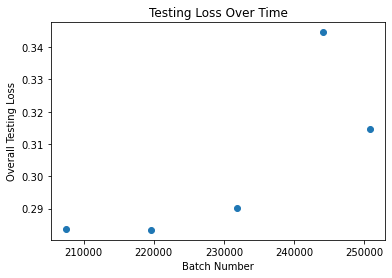

In [19]:
weight_fnames = os.listdir('./saved_weights4/')
#weight_fnames.sort() # isnt perfectly sorted, but too lazy to add the code (not important)
batch_sizes = []
losses = []

for fname in weight_fnames[-5:]:
    
    print(f'Loading: {fname}\n')

    checkpoint = torch.load(f'./saved_weights4/{fname}', map_location=device)
    
    # network weights load
    net = torch.hub.load('zhanghang1989/ResNeSt', 'resnest269', pretrained=True).to(device)
    
    
    # for feature extraction
    #for param in net.parameters():
        #param.requires_grad = False
        
    num_ftrs = net.fc.in_features
    net.fc = nn.Sequential(
               nn.Linear(num_ftrs, 1024),
               nn.BatchNorm1d(1024),
               nn.ReLU(),
               nn.Dropout(p=0.4),
               nn.Linear(1024, 256),
               nn.BatchNorm1d(256),
               nn.ReLU(),
               nn.Dropout(p=0.3),
               nn.Linear(256, 1),
               nn.Sigmoid()).to(device)

    net.load_state_dict(checkpoint['model_state_dict'])  
    criterion = nn.BCELoss()
    
    net.eval()
    
    # set start time for cnn training
    start_time = time.time()
    
    ground_truths = []
    probs = []

    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, testdata in enumerate(test_loader, 0):
            
            image, label = testdata
            image, label = image.to(device), label.to(device)

            # calculate outputs by running images through the network 
            outputs = net(image)
            
            loss = criterion(outputs, label.unsqueeze(-1).float())
            running_loss += loss.item()
        
            # everything saved should be on RAM
            outputs = outputs.to("cpu")
            label = label.to("cpu")
            
            # save for analysis
            ground_truths.append(label)
            
            # # save for analysis
            probs += outputs.squeeze(-1).tolist()

            if i % 10 == 0:
                print(f"\t Processing Batch #{i} ... Running Time {time.time() - start_time}")
                print(f'\t Current Testing Loss: {running_loss / (i+1)}\n')

                
    print(f'******* Final Testing Loss: {running_loss / (i+1)} *******\n')

    batch_sizes.append(checkpoint['mini_batch'])
    losses.append(running_loss / (i+1))
                
    # Save ground-truths and probability results¶
    res = {}
    res["ground_truths"] = ground_truths
    res["probs"] = probs
    res["num_batches"] = checkpoint['mini_batch']
    res["testing_loss"] = running_loss / (i+1)

    pkl_f_name = f'./saved_results4/results_ResNeSt_{checkpoint["mini_batch"]}b.pkl'
    with open(pkl_f_name, 'wb') as f:
        pickle.dump(res, f)

        
plt.plot(batch_sizes, losses, 'o')
plt.title("Testing Loss Over Time")
plt.xlabel("Batch Number")
plt.ylabel("Overall Testing Loss")
plt.show()

## Choose the results from the best performing model (training size)

[Batch 73224] Size Area Under the ROC Curve: 0.8703067162444028 

[Batch 12204] Size Area Under the ROC Curve: 0.8490170594916108 

[Batch 24408] Size Area Under the ROC Curve: 0.8514942736376577 

[Batch 36612] Size Area Under the ROC Curve: 0.8657662720854262 

[Batch 48816] Size Area Under the ROC Curve: 0.875692691632837 

[Batch 85428] Size Area Under the ROC Curve: 0.8736913501569795 

[Batch 97632] Size Area Under the ROC Curve: 0.8703928583973546 

[Batch 109836] Size Area Under the ROC Curve: 0.8832422568240474 

[Batch 122040] Size Area Under the ROC Curve: 0.8687921197493014 

[Batch 146448] Size Area Under the ROC Curve: 0.8704488926133522 

[Batch 158652] Size Area Under the ROC Curve: 0.8745460810338396 

[Batch 170856] Size Area Under the ROC Curve: 0.8788481706919307 

[Batch 183060] Size Area Under the ROC Curve: 0.8672758505910356 

[Batch 195264] Size Area Under the ROC Curve: 0.8675869659395599 

[Batch 207468] Size Area Under the ROC Curve: 0.882139135467317 

[Bat

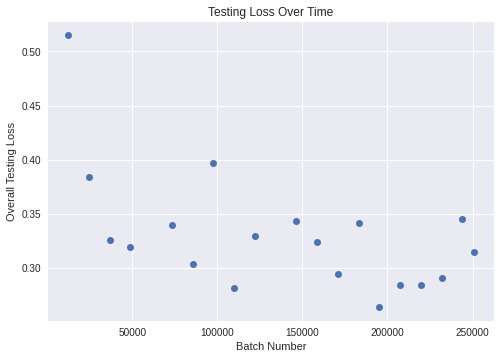

In [20]:
plt.style.use('seaborn')

# in case pkl results were calculated in batch job
# we may wont to visualize the test plot over time
recalc_loss_plot = True

if recalc_loss_plot:
    
    batch_sizes = []
    losses = []
    res_fnames = os.listdir('./saved_results4/')
    
    for fname in res_fnames:
        with open(f'./saved_results4/{fname}', 'rb') as f:
            res = pickle.load(f)
            batch_sizes.append(res["num_batches"])
            losses.append(res["testing_loss"]) 
            
            
            gt = res["ground_truths"]
            probs = np.array(res["probs"])

            # match formats (shouldve done this before, forgot to check)
            ground_truths = []
            for i in range(len(gt)):
                if gt[i].size() > torch.Size([1]):
                    ground_truths += gt[i].squeeze(-1).tolist()
                else:
                    ground_truths.append(gt[i].squeeze(-1).tolist())

            ground_truths = np.array(ground_truths)
            print(f"[Batch {res['num_batches']}] Size Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")
            
    
    plt.plot(batch_sizes, losses, 'o')
    plt.title("Testing Loss Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Overall Testing Loss")
    plt.show()

In [22]:
best_batch_size = 207468


with open(f'./saved_results4/results_ResNeSt_{best_batch_size}b.pkl', 'rb') as f:
    res = pickle.load(f)
    
    
gt = res["ground_truths"]
probs = np.array(res["probs"])


# match formats (shouldve done this before, forgot to check)
ground_truths = []
for i in range(len(gt)):
    if gt[i].size() > torch.Size([1]):
        ground_truths += gt[i].squeeze(-1).tolist()
    else:
        ground_truths.append(gt[i].squeeze(-1).tolist())
        
ground_truths = np.array(ground_truths)

## Testing Results

Max F2-Score is: 0.3167808219178082
Max G-Mean is: 0.8167398142420528
Max Cohen's Kappa is: 0.2101178753049766
Area Under the ROC Curve: 0.882139135467317 



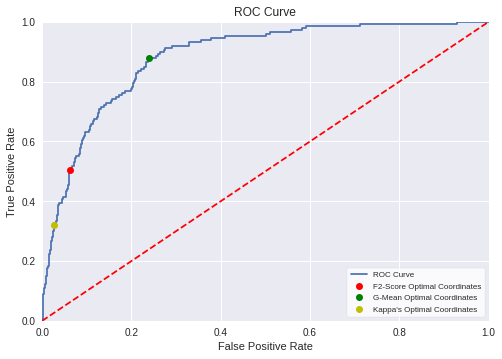


********************* USING F2-SCORE OPTIMAL THRESHOLD *************************
The confusion matrix is:
 [[7628  506]
 [  73   74]] 

Recall / Sensitivity: 0.5034013605442177
Precision: 0.12758620689655173
Specificity: 0.9377919842635849
F2-Score: 0.3167808219178082
G-Mean: 0.6870849734827201
Cohen's Kappa: 0.18036068787013215
********************************************************************************


********************** USING G-MEAN OPTIMAL THRESHOLD **************************
The confusion matrix is:
 [[6183 1951]
 [  19  128]] 

Recall / Sensitivity: 0.8775510204081632
Precision: 0.06156806156806157
Specificity: 0.7601426112613721
F2-Score: 0.2399700037495313
G-Mean: 0.8167398142420528
Cohen's Kappa: 0.08465302980314526
********************************************************************************


********************** USING KAPPA OPTIMAL THRESHOLD ***************************
The confusion matrix is:
 [[7916  218]
 [ 100   47]] 

Recall / Sensitivity: 0.31972789115

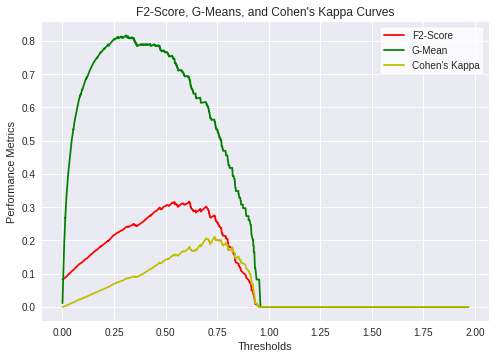

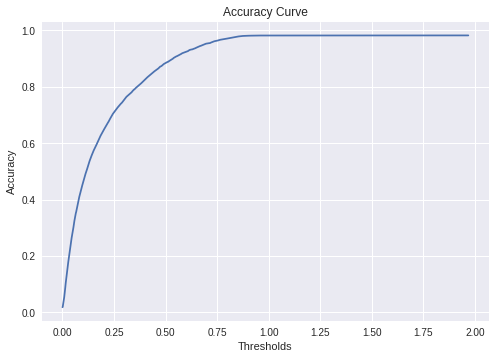

In [23]:
import warnings
warnings.filterwarnings('ignore')

fpr, tpr, thresholds = metrics.roc_curve(ground_truths, probs)
recall = tpr

# compute other metrics using the same thresholds
specificity = np.zeros_like(tpr)
precision = np.zeros_like(tpr)
fbetascores = np.zeros_like(tpr)
CKappas = np.zeros_like(tpr)

for i in range(len(thresholds)):
    preds = probs > thresholds[i]
    tn, fp, fn, tp = metrics.confusion_matrix(ground_truths, preds).ravel()
    
    specificity[i] = tn / (tn + fp)
    precision[i] = tp / (tp + fp)
    
    # more attention put on recall, such as when false negatives are more important to
    # minimize, but false positives are still important.
    fbetascores[i] = metrics.fbeta_score(ground_truths, preds, beta = 2)
    
    CKappas[i] = metrics.cohen_kappa_score(ground_truths, preds,)
    


gmeans = np.sqrt(specificity * recall)


print("Max F2-Score is:", np.nanmax(fbetascores))
print("Max G-Mean is:", np.nanmax(gmeans))
print("Max Cohen's Kappa is:", np.nanmax(CKappas))


print("Area Under the ROC Curve:", metrics.roc_auc_score(ground_truths, probs), "\n")

plt.plot(fpr, tpr)
plt.plot(fpr[np.nanargmax(fbetascores)], tpr[np.nanargmax(fbetascores)], 'ro')
plt.plot(fpr[np.nanargmax(gmeans)], tpr[np.nanargmax(gmeans)], 'go')
plt.plot(fpr[np.nanargmax(CKappas)], tpr[np.nanargmax(CKappas)], 'yo')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.legend(['ROC Curve', 'F2-Score Optimal Coordinates', 'G-Mean Optimal Coordinates', 
            "Kappa's Optimal Coordinates"], loc='lower right', prop={'size': 8}, 
           frameon=True, facecolor = 'white')
plt.show()

fb_opt_thresh = thresholds[np.nanargmax(fbetascores)]
fb_opt_preds = probs > fb_opt_thresh

print('\n********************* USING F2-SCORE OPTIMAL THRESHOLD *************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, fb_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(fbetascores)] )
print("Precision:",  precision[np.nanargmax(fbetascores)] )
print("Specificity:",  specificity[np.nanargmax(fbetascores)] )
print("F2-Score:", fbetascores[np.nanargmax(fbetascores)] )
print("G-Mean:", gmeans[np.nanargmax(fbetascores)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(fbetascores)] )
print('********************************************************************************\n')

gm_opt_thresh = thresholds[np.nanargmax(gmeans)]
gm_opt_preds = probs > gm_opt_thresh

print('\n********************** USING G-MEAN OPTIMAL THRESHOLD **************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, gm_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(gmeans)] )
print("Precision:",  precision[np.nanargmax(gmeans)] )
print("Specificity:",  specificity[np.nanargmax(gmeans)] )
print("F2-Score:", fbetascores[np.nanargmax(gmeans)] )
print("G-Mean:", gmeans[np.nanargmax(gmeans)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(gmeans)] )
print('********************************************************************************\n')


ck_opt_thresh = thresholds[np.nanargmax(CKappas)]
ck_opt_preds = probs > ck_opt_thresh

print('\n********************** USING KAPPA OPTIMAL THRESHOLD ***************************')
print("The confusion matrix is:\n", metrics.confusion_matrix(ground_truths, ck_opt_preds), "\n")
print("Recall / Sensitivity:",  recall[np.nanargmax(CKappas)] )
print("Precision:",  precision[np.nanargmax(CKappas)] )
print("Specificity:",  specificity[np.nanargmax(CKappas)] )
print("F2-Score:", fbetascores[np.nanargmax(CKappas)] )
print("G-Mean:", gmeans[np.nanargmax(CKappas)] )
print("Cohen's Kappa:", CKappas[np.nanargmax(CKappas)] )
print('********************************************************************************\n')


accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(metrics.accuracy_score(ground_truths, [m > thresh for m in probs]))



plt.plot(thresholds, fbetascores, "-r")
plt.plot(thresholds, gmeans, "-g")
plt.plot(thresholds, CKappas, "-y")
plt.title("F2-Score, G-Means, and Cohen's Kappa Curves")
plt.xlabel("Thresholds")
plt.ylabel("Performance Metrics")
plt.legend(['F2-Score', 'G-Mean', "Cohen's Kappa"], loc='upper right',
           frameon=True, facecolor = 'white')
plt.show()    
    

plt.plot(thresholds, accuracy_scores)
plt.title("Accuracy Curve")
plt.xlabel("Thresholds")
plt.ylabel("Accuracy")
plt.show()